# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


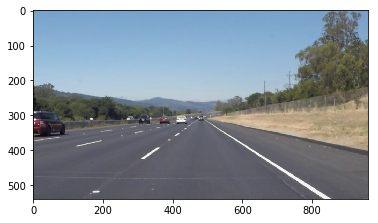

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [143]:
import math

threshold = 0.1

def load_image(source_folder, file_name):
    s = "";
    sequence = (source_folder, file_name)
    fileFullPath = s.join(sequence)
    img = mpimg.imread(fileFullPath)
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global avg_pos_slope
    global avg_neg_slope
    global nFrames
    
    if lines is None:
        return;
    
    # lines is an array of <1,4> tuples
    num_line_segments = lines.shape
    slopes = [None]* num_line_segments[0]
    line_index=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            slopes[line_index] = (y2 - y1) / (x2 - x1);
        line_index+=1
    
    imshape = img.shape
    bottom_y = imshape[0]
    
    
    mean_negative_slope = compute_mean_slope(slopes, 1)
    print('avg_neg_slope(before) = ', avg_neg_slope)
    print('mean_negative_slope = ', mean_negative_slope)
    print('nFrames = ',nFrames)
    if nFrames > 10:
        nFrames_used = 10
    else:
        nFrames_used = nFrames
    if ~np.isinf(mean_negative_slope) and ~np.isnan(mean_negative_slope):
        if avg_neg_slope != 0:
            avg_neg_slope = (mean_negative_slope + avg_neg_slope*nFrames_used)/(nFrames_used+1)
        else:
            avg_neg_slope = mean_negative_slope
    else:
        plt.imshow(img)
    print('avg_neg_slope = ', avg_neg_slope)
    if avg_neg_slope != 0:
        rlp1 = compute_highest_point(lines,1,avg_neg_slope)#[485, 300];
        rlp2 = compute_other_point(avg_neg_slope, rlp1, bottom_y)
        cv2.line(img, (rlp1[0], rlp1[1]), (int(rlp2[0]), int(rlp2[1])), color, 10)
        print('end-points = ', rlp1[0], rlp1[1], int(rlp2[0]), int(rlp2[1]))
    
    mean_positive_slope = compute_mean_slope(slopes, 0)
    print('avg_pos_slope(before) = ', avg_pos_slope)
    print('mean_positive_slope = ',mean_positive_slope)
    if ~np.isinf(mean_positive_slope) and ~np.isnan(mean_positive_slope):
        if avg_pos_slope != 0:
            avg_pos_slope = (mean_positive_slope + avg_pos_slope*nFrames_used)/(nFrames_used+1)
        else:
            avg_pos_slope = mean_positive_slope
    else:
        plt.imshow(img)
    print('avg_pos_slope = ', avg_pos_slope)
    if avg_pos_slope != 0:
        llp1 = compute_highest_point(lines,0,avg_pos_slope)#[485, 310];
        llp2 = compute_other_point(avg_pos_slope, llp1, bottom_y)
        cv2.line(img, (llp1[0], llp1[1]), (int(llp2[0]), int(llp2[1])), color, 10)
        print('end points = ', llp1[0], llp1[1], int(llp2[0]), int(llp2[1]))

def remove_noisy_slopes(slope_candidates):
    global threshold
    mean_slope = np.mean(slope_candidates)
    new_slope_candidates = []
    for slope in slope_candidates:
        if abs(slope - mean_slope) < threshold:
            new_slope_candidates.append(slope)
    return new_slope_candidates
    
def compute_mean_slope(slopes, is_slope_negative):
    num_line_segments = len(slopes)
    if is_slope_negative==1:
        slope_indices =  [i for i in range(num_line_segments) if slopes[i] < 0]
    else:
        slope_indices = [i for i in range(num_line_segments) if slopes[i] > 0]
    slope_candidates = [slopes[i] for i in slope_indices]
    slope_candidates = remove_noisy_slopes(slope_candidates)
    mean_slope = np.mean(slope_candidates)
    return mean_slope

def compute_highest_point(lines, is_slope_negative, mean_slope):
    global threshold
    highest_x = 0
    highest_y = 1000
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1);
            if abs(slope - mean_slope) < threshold:
                if is_slope_negative and slope < 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
            
            if abs(slope - mean_slope) < threshold:
                if not is_slope_negative and slope > 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
    print('highest = ', [highest_x, highest_y])
    return [highest_x, highest_y]

def compute_other_point(slope, point, bottom_y):
    bias = point[1] - slope*point[0]
    bottom_x = (bottom_y - bias)/ slope;
    print('bottom = ',[bottom_x, bottom_y])
    return [bottom_x, bottom_y]
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os, sys
src_folder = "test_images/"
file_list = os.listdir(src_folder)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [83]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
i = 0
for file in file_list:
    
    img = load_image(src_folder, file)
    
    # Compute GrayScale of the  image
    gray = grayscale(img)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Create masked edge image using region of interest
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (450, 320), (490, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 60 #minimum number of pixels making up a line
    max_line_gap = 60   # maximum gap in pixels between connectable line segments
    
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, img)
    
    
    # save image in src_folder 
    s = "";
    new_file_name = s.join((src_folder, "modified_", file))
    mpimg.imsave(new_file_name, lane_overlayed_image)
    

NameError: name 'file_list' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [141]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Compute GrayScale of the  image
    global nFrames
    
    nFrames = nFrames + 1
    
    gray = grayscale(image)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 40
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)
    
   # Create masked edge image using region of interest
    imshape = image.shape
    print(imshape)
    #vertices = np.array([[(50, imshape[0]-20), (imshape[1]/2-10, imshape[0]/2+40), (imshape[1]/2 + 10, imshape[0]/2+40), (imshape[1]-50, imshape[0]-20)]], dtype=np.int32)
    vertices = np.array([[(0, imshape[0]), (480, 310), (490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 150   # maximum gap in pixels between connectable line segments
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #plt.imshow(line_image)
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, image)
    
    
    # save image in src_folder 
    #s = "";
    #new_file_name = s.join((src_folder, "modified_", file))
    #mpimg.imsave(new_file_name, lane_overlayed_image)
    plt.imshow(lane_overlayed_image)
    return lane_overlayed_image

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
avg_neg_slope(before) =  -0.778219651483
mean_negative_slope =  -0.752972105341
nFrames =  1
avg_neg_slope =  -0.765595878412
highest =  [465, 317]
bottom =  [173.72361478411491, 540]
end-points =  465 317 173 540
avg_pos_slope(before) =  0.574077921362
mean_positive_slope =  0.614963605055
avg_pos_slope =  0.594520763208
highest =  [486, 310]
bottom =  [872.86621937101336, 540]
end points =  486 310 872 540
[MoviePy] >>>> Building video test_videos/modified_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/modified_solidWhiteRight.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.765595878412
mean_negative_slope =  -0.752972105341
nFrames =  2
avg_neg_slope =  -0.761387954055
highest =  [465, 317]
bottom =  [172.11383229483408, 540]
end-points =  465 317 172 540
avg_pos_slope(before) =  0.594520763208
mean_positive_slope =  0.614963605055
avg_pos_slope =  0.601335043824
highest =  [486, 310]
bottom =  [868.48228231875623, 540]
end points =  486 310 868 540



  1%|          | 2/222 [00:00<00:12, 17.36it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.761387954055
mean_negative_slope =  -0.747820721945
nFrames =  3
avg_neg_slope =  -0.757996146028
highest =  [473, 313]
bottom =  [173.52618184187617, 540]
end-points =  473 313 173 540
avg_pos_slope(before) =  0.601335043824
mean_positive_slope =  0.57320286369
avg_pos_slope =  0.59430199879
highest =  [491, 310]
bottom =  [878.00862603214614, 540]
end points =  491 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.757996146028
mean_negative_slope =  -0.745546536813
nFrames =  4
avg_neg_slope =  -0.755506224185
highest =  [461, 319]
bottom =  [168.48090098332418, 540]
end-points =  461 319 168 540
avg_pos_slope(before) =  0.59430199879
mean_positive_slope =  0.613957174429
avg_pos_slope =  0.598233033918
highest =  [490, 310]
bottom =  [874.46556268153381, 540]
end points =  490 310 874 540


(540, 960, 3)
avg_neg_slope(before) =  -0.755506224185
mean_negative_slope =  -0.746353425193
nFrames =  5
avg_neg_slope =  -0.753980757686
highest =  [471, 314]
bottom =  [171.25760247039742, 540]
end-points =  471 314 171 540
avg_pos_slope(before) =  0.598233033918
mean_positive_slope =  0.612048716715
avg_pos_slope =  0.600535647718
highest =  [486, 310]
bottom =  [868.99141920074032, 540]
end points =  486


  2%|▏         | 4/222 [00:00<00:13, 16.52it/s]

 310 868 540



  2%|▏         | 5/222 [00:00<00:17, 12.24it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.753980757686
mean_negative_slope =  -0.712859570242
nFrames =  6
avg_neg_slope =  -0.748106302337
highest =  [471, 314]
bottom =  [168.90389508276192, 540]
end-points =  471 314 168 540
avg_pos_slope(before) =  0.600535647718
mean_positive_slope =  0.612520441115
avg_pos_slope =  0.60224776106
highest =  [487, 310]
bottom =  [868.90262358992857, 540]
end points =  487 310 868 540


(540, 960, 3)
avg_neg_slope(before) =  -0.748106302337
mean_negative_slope =  -0.715684513685
nFrames =  7
avg_neg_slope =  -0.744053578755
highest =  [467, 316]
bottom =  [165.9464113932558, 540]
end-points =  467 316 165 540
avg_pos_slope(before) =  0.60224776106
mean_positive_slope =  0.613372225835
avg_pos_slope =  0.603638319157
highest =  [491, 310]
bottom =  [872.02286203633741, 540]
end points =  491 310 872 540



  4%|▎         | 8/222 [00:00<00:17, 12.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.744053578755
mean_negative_slope =  -0.710497342269
nFrames =  8
avg_neg_slope =  -0.740325108035
highest =  [475, 313]
bottom =  [168.37795309604053, 540]
end-points =  475 313 168 540
avg_pos_slope(before) =  0.603638319157
mean_positive_slope =  0.613565047788
avg_pos_slope =  0.604741289005
highest =  [491, 310]
bottom =  [871.32792564650777, 540]
end points =  491 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.740325108035
mean_negative_slope =  -0.712073077828
nFrames =  9
avg_neg_slope =  -0.737499905014
highest =  [467, 316]
bottom =  [163.27114732205385, 540]
end-points =  467 316 163 540
avg_pos_slope(before) =  0.604741289005
mean_positive_slope =  0.615213970669
avg_pos_slope =  0.605788557171
highest =  [491, 310]
bottom =  [870.67042671457125, 540]
end points =  491 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.737499905014
mean_negative_slope =  -0.711443197963
nFrames =  10
avg_neg_slope =  -0.735131113464


highest =  [476, 313]
bottom =  [167.21154601879545, 540]
end-points =  476 313 167 540
avg_pos_slope(before) =  0.605788557171
mean_positive_slope =  0.613416151872
avg_pos_slope =  0.606481974871
highest =  [491, 310]
bottom =  [870.23633270189976, 540]
end points =  491 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.735131113464
mean_negative_slope =  -0.715167531792
nFrames =  11
avg_neg_slope =  -0.733316242403


  5%|▍         | 10/222 [00:00<00:16, 13.17it/s]


highest =  [483, 311]
bottom =  [170.71999478746744, 540]
end-points =  483 311 170 540
avg_pos_slope(before) =  0.606481974871
mean_positive_slope =  0.623862244719
avg_pos_slope =  0.608061999403
highest =  [491, 310]
bottom =  [869.25090241757539, 540]
end points =  491 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.733316242403
mean_negative_slope =  -0.71568060377
nFrames =  12
avg_neg_slope =  -0.731713002527
highest =  [478, 312]
bottom =  [166.40242115072343, 540]
end-points =  478 312 166 540
avg_pos_slope(before) =  0.608061999403
mean_positive_slope =  0.633123998134
avg_pos_slope =  0.610340362924
highest =  [486, 310]
bottom =  [862.83891476247152, 540]
end points =  486 310 862 540
(540, 960, 3)
avg_neg_slope(before) = 


  5%|▌         | 12/222 [00:00<00:15, 13.40it/s]

 -0.731713002527
mean_negative_slope =  -0.716136781484
nFrames =  13
avg_neg_slope =  -0.730296982432
highest =  [475, 312]
bottom =  [162.79824443390501, 540]
end-points =  475 312 162 540
avg_pos_slope(before) =  0.610340362924
mean_positive_slope =  0.616439106279
avg_pos_slope =  0.610894794138
highest =  [478, 311]
bottom =  [852.8599631187102, 540]
end points =  478 311 852 540
(540, 960, 3)
avg_neg_slope(before) =  


  6%|▋         | 14/222 [00:00<00:14, 14.42it/s]

-0.730296982432
mean_negative_slope =  -0.721642883706
nFrames =  14
avg_neg_slope =  -0.729510246184
highest =  [475, 312]
bottom =  [162.46155219546691, 540]
end-points =  475 312 162 540
avg_pos_slope(before) =  0.610894794138
mean_positive_slope =  0.631308735976
avg_pos_slope =  0.612750607032
highest =  [482, 310]
bottom =  [857.35662528985813, 540]
end points =  482 310 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.729510246184
mean_negative_slope =  -0.703530172517
nFrames =  15
avg_neg_slope =  -0.727148421306
highest =  [479, 310]
bottom =  [162.69593708665488, 540]
end-points =  479 310 162 540
avg_pos_slope(before) =  0.612750607032
mean_positive_slope =  0.641630426471
avg_pos_slope =  0.615376045163
highest =  [482, 310]
bottom =  [855.7552051428828, 540]
end points =  482 310 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.727148421306
mean_negative_slope =  -0.714911650608
nFrames =  16
avg_neg_slope =  -0.726035987606
highest =  [463, 318]
bottom =  [157.23003296


  7%|▋         | 16/222 [00:01<00:14, 14.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.726035987606
mean_negative_slope =  -0.710933559429
nFrames =  17
avg_neg_slope =  -0.72466303959
highest =  [456, 321]
bottom =  [153.79057570818173, 540]
end-points =  456 321 153 540
avg_pos_slope(before) =  0.617638335834
mean_positive_slope =  0.637130893072
avg_pos_slope =  0.619410386492
highest =  [490, 310]
bottom =  [861.32086418902065, 540]
end points =  490 310 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.72466303959
mean_negative_slope =  -0.71787585997
nFrames =  18
avg_neg_slope =  -0.724046023261
highest =  [451, 324]
bottom =  [152.67642240856736, 540]
end-points =  451 324 152 540
avg_pos_slope(before) =  0.619410386492
mean_positive_slope =  0.640500039747
avg_pos_slope =  0.621327627697
highest =  


  8%|▊         | 18/222 [00:01<00:12, 15.69it/s]

[490, 310]
bottom =  [860.17507309692598, 540]
end points =  490 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.724046023261
mean_negative_slope =  -0.71136594407
nFrames =  19
avg_neg_slope =  -0.722893288789
highest =  [456, 321]
bottom =  [153.05072187499488, 540]
end-points =  456 321 153 540
avg_pos_slope(before) =  0.621327627697
mean_positive_slope =  0.636219565934
avg_pos_slope =  0.622681440264
highest =  [491, 310]
bottom =  [860.3702511871569, 540]
end points =  491 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722893288789
mean_negative_slope =  -0.680399557527
nFrames =  20
avg_neg_slope =  -0.71903022231
highest =  [474, 313]
bottom =  [158.29699759966897, 540]
end-points =  474 313 158 540
avg_pos_slope(before) =  0.622681440264
mean_positive_slope =  0.63998012283
avg_pos_slope =  0.62425404777
highest =  [487, 310]
bottom =  [855.43974151473435, 540]
end points =  487 310 855 540



  9%|▉         | 20/222 [00:01<00:12, 16.05it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.71903022231
mean_negative_slope =  -0.66201824069
nFrames =  21
avg_neg_slope =  -0.71384731489
highest =  [491, 310]
bottom =  [168.80224818063633, 540]
end-points =  491 310 168 540
avg_pos_slope(before) =  0.62425404777
mean_positive_slope =  0.63498171853
avg_pos_slope =  0.625229290567
highest =  [483, 310]
bottom =  [850.8650432252914, 540]
end points =  483 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71384731489
mean_negative_slope =  -0.694921627742
nFrames =  22
avg_neg_slope =  -0.712126797877
highest =  [479, 311]
bottom =  [157.42805426969662, 540]
end-points =  479 311 157 540
avg_pos_slope(before) =  0.625229290567
mean_positive_slope =  0.643111302918
avg_pos_slope =  0.626854928053
highest =  [484, 311]
bottom =  [849.31578480405642, 540]
end points =  484 311 849 540



 10%|▉         | 22/222 [00:01<00:12, 16.52it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712126797877
mean_negative_slope =  -0.699247199126
nFrames =  23
avg_neg_slope =  -0.710955925263
highest =  [483, 311]
bottom =  [160.89845774869738, 540]
end-points =  483 311 160 540
avg_pos_slope(before) =  0.626854928053
mean_positive_slope =  0.640278670401
avg_pos_slope =  0.628075268266
highest =  [484, 311]
bottom =  [848.6059820697069, 540]
end points =  484 311 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710955925263
mean_negative_slope =  -0.712063641981
nFrames =  24
avg_neg_slope =  -0.711056626783
highest =  [479, 310]
bottom =  [155.53771677711489, 540]
end-points =  479 310 155 540
avg_pos_slope(before) =  0.628075268266
mean_positive_slope =  0.638147854967
avg_pos_slope =  0.628990957967
highest =  [483, 310]
bottom =  [848.66503395147026, 540]
end points =  483 310 848 540



 11%|█         | 24/222 [00:01<00:11, 17.01it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711056626783
mean_negative_slope =  -0.69046553894
nFrames =  25
avg_neg_slope =  -0.709184709706
highest =  [484, 310]
bottom =  [159.68392711790881, 540]
end-points =  484 310 159 540
avg_pos_slope(before) =  0.628990957967
mean_positive_slope =  0.659300361669
avg_pos_slope =  0.631746358303
highest =  [489, 311]
bottom =  [851.48724981193413, 540]
end points =  489 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709184709706
mean_negative_slope =  -0.709876827087
nFrames =  26
avg_neg_slope =  -0.709247629468
highest =  [475, 312]
bottom =  [153.53258787634547, 540]
end-points =  475 312 153 540
avg_pos_slope(before) =  0.631746358303
mean_positive_slope =  0.642203353074
avg_pos_slope =  0.632696994191
highest =  [484, 310]
bottom =  [847.52314316578384, 540]
end points =  484 310 847 540



 12%|█▏        | 26/222 [00:01<00:11, 17.00it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709247629468
mean_negative_slope =  -0.709278038926
nFrames =  27
avg_neg_slope =  -0.709250393964
highest =  [473, 313]
bottom =  [152.94378017730978, 540]
end-points =  473 313 152 540
avg_pos_slope(before) =  0.632696994191
mean_positive_slope =  0.638911580593
avg_pos_slope =  0.633261956592
highest =  [487, 310]
bottom =  [850.19882728775156, 540]
end points =  487 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709250393964
mean_negative_slope =  -0.719365876505
nFrames =  28
avg_neg_slope =  -0.710169983286
highest =  [480, 310]
bottom =  [156.13387581422981, 540]
end-points =  480 


 13%|█▎        | 28/222 [00:01<00:11, 16.78it/s]

310 156 540
avg_pos_slope(before) =  0.633261956592
mean_positive_slope =  0.642625062146
avg_pos_slope =  0.634113148006
highest =  [491, 310]
bottom =  [853.71129328163352, 540]
end points =  491 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710169983286
mean_negative_slope =  -0.713477973955
nFrames =  29
avg_neg_slope =  -0.710470709711
highest =  [481, 310]
bottom =  [157.27096112991265, 540]
end-points =  481 310 157 540
avg_pos_slope(before) =  0.634113148006
mean_positive_slope =  0.639958162226
avg_pos_slope =  0.634644512935
highest =  [485, 310]
bottom =  [847.40760821586264, 540]
end points =  485 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710470709711
mean_negative_slope =  -0.711847283208
nFrames =  30
avg_neg_slope =  -0.710595852756
highest =  [485, 310]
bottom =  [161.32797305531781, 540]
end-points =  485 310 161 540
avg_pos_slope(before) =  0.634644512935


 14%|█▎        | 30/222 [00:01<00:11, 17.26it/s]


mean_positive_slope =  0.639833466264
avg_pos_slope =  0.635116235965
highest =  [483, 310]
bottom =  [845.13843541673964, 540]
end points =  483 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710595852756
mean_negative_slope =  -0.718463538088
nFrames =  31
avg_neg_slope =  -0.711311096877
highest =  [481, 310]
bottom =  [157.65343474917131, 540]
end-points =  481 310 157 540
avg_pos_slope(before) =  0.635116235965
mean_positive_slope =  0.642402248575
avg_pos_slope =  0.635778600747
highest =  [489, 310]
bottom =  [850.76115353620787, 540]
end points =  489 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711311096877
mean_negative_slope =  -0.71342766164
nFrames =  32
avg_neg_slope =  -0.711503511856
highest =  [461, 319]
bottom =  [150.39014872371664, 540]
end-points =  461 319 150 540
avg_pos_slope(before) =  0.635778600747
mean_positive_slope =  0.636664801642
avg_pos_slope =  0.635859164465
highest =  [489, 310]
bottom =  [850.71531819237487, 540]
end points =  489 


 14%|█▍        | 32/222 [00:02<00:11, 17.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711503511856
mean_negative_slope =  -0.711263906014
nFrames =  33
avg_neg_slope =  -0.711481729506
highest =  [474, 313]
bottom =  [154.94753443983541, 540]
end-points =  474 313 154 540
avg_pos_slope(before) =  0.635859164465
mean_positive_slope =  0.631448183335
avg_pos_slope =  0.63545816618
highest =  [488, 310]
bottom =  [849.94357432282914, 540]
end points =  488 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711481729506
mean_negative_slope =  -0.709641342135
nFrames =  34
avg_neg_slope =  -0.711314421563
highest =  [485, 313]
bottom =  [165.87249025395491, 540]
end-points =  485 313 165 540
avg_pos_slope(before) =  0.63545816618
mean_positive_slope =  0.637147307804
avg_pos_slope =  0.63561172451
highest =  [491, 311]
bottom =  [851.28284433641772, 540]
end points =  491 311 851 540


 15%|█▌        | 34/222 [00:02<00:10, 17.17it/s]


(540, 960, 3)
avg_neg_slope(before) =  -0.711314421563
mean_negative_slope =  -0.715848432549
nFrames =  35
avg_neg_slope =  -0.71172660438
highest =  [459, 320]
bottom =  [149.8925440667891, 540]
end-points =  459 320 149 540
avg_pos_slope(before) =  0.63561172451
mean_positive_slope =  0.632699835001
avg_pos_slope =  0.635347007282
highest =  [488, 310]
bottom =  [850.00689916525437, 540]
end points =  488 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71172660438
mean_negative_slope =  -0.730180269054
nFrames =  36
avg_neg_slope =  -0.71340421026
highest =  [473, 313]
bottom =  [154.8073166160072, 540]
end-points =  473 313 154 540
avg_pos_slope(before) =  0.635347007282
mean_positive_slope =  0.636375775889
avg_pos_slope =  0.635440531701
highest =  [482, 310]
bottom =  [843.95361882955353, 540]
end points =  482 310 843 540



 17%|█▋        | 37/222 [00:02<00:10, 18.01it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.71340421026
mean_negative_slope =  -0.714546064501
nFrames =  37
avg_neg_slope =  -0.713508015191
highest =  [479, 310]
bottom =  [156.64903112055458, 540]
end-points =  479 310 156 540
avg_pos_slope(before) =  0.635440531701
mean_positive_slope =  0.630538604109
avg_pos_slope =  0.63499490192
highest =  [483, 310]
bottom =  [845.20763238370205, 540]
end points =  483 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713508015191
mean_negative_slope =  -0.711300611896
nFrames =  38
avg_neg_slope =  -0.713307342164
highest =  [479, 310]
bottom =  [156.55834490326069, 540]
end-points =  479 310 156 540
avg_pos_slope(before) =  0.63499490192
mean_positive_slope =  0.636796302167
avg_pos_slope =  0.635158665578
highest =  [483, 310]
bottom =  [845.11424399059024, 540]
end points =  483 310 845 540



 18%|█▊        | 39/222 [00:02<00:09, 18.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713307342164
mean_negative_slope =  -0.716100215027
nFrames =  39
avg_neg_slope =  -0.713561239697
highest =  [479, 310]
bottom =  [156.67307526727069, 540]
end-points =  479 310 156 540
avg_pos_slope(before) =  0.635158665578
mean_positive_slope =  0.639251504649
avg_pos_slope =  0.635530741858
highest =  [480, 310]
bottom =  [841.90224146789262, 540]
end points =  480 310 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713561239697
mean_negative_slope =  -0.71633934288
nFrames =  40
avg_neg_slope =  -0.713813794532
highest =  [480, 310]
bottom =  [157.78711792636355, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.635530741858
mean_positive_slope =  0.639595155657
avg_pos_slope =  0.635900234021
highest =  [488, 310]
bottom =  [849.69195684294448, 540]
end points =  488 310 849 540
(540, 960, 3)


avg_neg_slope(before) =  -0.713813794532
mean_negative_slope =  -0.718050534507
nFrames =  41
avg_neg_slope =  -0.714198952711
highest =  [478, 313]
bottom =  [160.1613933509073, 540]
end-points =  478 313 160 540
avg_pos_slope(before) =  0.635900234021
mean_positive_slope =  0.679801375717
avg_pos_slope =  0.639891246903
highest =  [489, 310]
bottom =  [848.43607779185675, 540]
end points =  489 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714198952711
mean_negative_slope =  -0.721415130149
nFrames =  42
avg_neg_slope =  -0.714854968842
highest =  [461, 319]
bottom =  [151.8463819479428, 540]
end-points =  461 319 151 540
avg_pos_slope(before) =  0.639891246903
mean_positive_slope =  0.660462533843
avg_pos_slope =  0.641761363897
highest =  [490, 310]
bottom =  [848.38866740637877, 540]
end points =  490 310 848 540
(540, 960, 3)



 19%|█▉        | 42/222 [00:02<00:09, 18.31it/s]

avg_neg_slope(before) =  -0.714854968842
mean_negative_slope =  -0.729169823024
nFrames =  43
avg_neg_slope =  -0.716156319222
highest =  [465, 317]
bottom =  [153.61546841869762, 540]
end-points =  465 317 153 540
avg_pos_slope(before) =  0.641761363897
mean_positive_slope =  0.640405921066
avg_pos_slope =  0.641638141822
highest =  [490, 310]
bottom =  [848.45749341996031, 540]
end points =  490 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716156319222
mean_negative_slope =  -0.714145603328
nFrames =  44
avg_neg_slope =  -0.715973526868
highest =  [463, 318]
bottom =  [152.93266975796783, 540]
end-points =  463 318 152 540
avg_pos_slope(before) =  0.641638141822
mean_positive_slope =  0.623212281302
avg_pos_slope =  0.639963063593
highest =  [490, 311]
bottom =  [847.83315167357568, 540]
end points =  490 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.715973526868
mean_negative_slope =  -0.718002311159
nFrames =  45
avg_neg_slope =  -0.716157961804
highest =  [461, 31


 21%|██        | 46/222 [00:02<00:10, 16.29it/s]


bottom =  [152.40886258753369, 540]
end-points =  461 319 152 540
avg_pos_slope(before) =  0.639963063593
mean_positive_slope =  0.6567284254
avg_pos_slope =  0.641487187393
highest =  [490, 310]
bottom =  [848.54184544922055, 540]
end points =  490 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716157961804
mean_negative_slope =  -0.733698676546
nFrames =  46
avg_neg_slope =  -0.717752572235
highest =  [452, 323]
bottom =  [149.66740183970975, 540]
end-points =  452 323 149 540
avg_pos_slope(before) =  0.641487187393
mean_positive_slope =  0.638821090205
avg_pos_slope =  0.641244814922
highest =  [489, 310]
bottom =  [847.67736416417381, 540]
end points =  489 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717752572235
mean_negative_slope =  -0.735562167992
nFrames =  47
avg_neg_slope =  -0.719371626395
highest =  [459, 320]
bottom =  [153.17754060915522, 540]
end-points =  459 320 153 540
avg_pos_slope(before) =  0.641244814922
mean_positive_slope =  0.629445075091
avg


avg_pos_slope =  0.641303399686
highest =  [489, 310]
bottom =  [847.64459803704972, 540]
end points =  489 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.721762409004
mean_negative_slope =  -0.731916254553
nFrames =  


 23%|██▎       | 50/222 [00:03<00:11, 14.84it/s]

49
avg_neg_slope =  -0.722685485872
highest =  [451, 324]
bottom =  [152.11479444011098, 540]
end-points =  451 324 152 540
avg_pos_slope(before) =  0.641303399686
mean_positive_slope =  0.656982417797
avg_pos_slope =  0.642728764968
highest =  [493, 312]
bottom =  [847.73750737018895, 540]
end points =  493 312 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722685485872
mean_negative_slope =  -0.732660108046
nFrames =  50
avg_neg_slope =  -0.723592269706
highest =  [457, 321]
bottom =  [154.34336701940774, 540]
end-points =  457 321 154 540
avg_pos_slope(before) =  0.642728764968
mean_positive_slope =  0.65078528395
avg_pos_slope =  0.643461175785
highest =  [488, 310]
bottom =  [845.44192292481341, 540]
end points =  488 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.723592269706
mean_negative_slope =  -0.735465689314
nFrames =  51
avg_neg_slope =  -0.724671671489
highest =  [457, 322]
bottom =  [156.17411073595719, 540]
end-points =  457 322 156 540
avg_pos_slope(before) =


 23%|██▎       | 52/222 [00:03<00:11, 14.77it/s]

 -0.724671671489
mean_negative_slope =  -0.706128335868
nFrames =  52
avg_neg_slope =  -0.722985913705
highest =  [461, 319]
bottom =  [155.32322841877686, 540]
end-points =  461 319 155 540
avg_pos_slope(before) =  0.64364707706
mean_positive_slope =  0.650394732065
avg_pos_slope =  0.644260500242
highest =  [488, 310]
bottom =  [844.99845002692689, 540]
end points =  488 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722985913705
mean_negative_slope =  -0.707511482596
nFrames =  53
avg_neg_slope =  -0.72157914724
highest =  [461, 319]
bottom =  [154.72729125391558, 540]
end-points =  461 319 154 540
avg_pos_slope(before) =  0.644260500242
mean_positive_slope =  0.657398268019
avg_pos_slope =  0.645454842767
highest =  [497, 313]
bottom =  [848.68997884777741, 540]
end points =  497 313 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.72157914724
mean_negative_slope =  -0.703401928519
nFrames =  54
avg_neg_slope =  -0.719926672811
highest =  [448, 326]
bottom =  [150.747504597


 25%|██▌       | 56/222 [00:03<00:11, 14.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.717821139588
mean_negative_slope =  -0.707842259314
nFrames =  56
avg_neg_slope =  -0.716913968654
highest =  [452, 323]
bottom =  [149.31375103831763, 540]
end-points =  452 323 149 540
avg_pos_slope(before) =  0.646065378613
mean_positive_slope =  0.670945644
avg_pos_slope =  0.648327220921
highest =  [493, 311]
bottom =  [846.21669769565335, 540]
end points =  493 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716913968654
mean_negative_slope =  -0.691800082589
nFrames =  57
avg_neg_slope =  -0.714630888102
highest =  [467, 316]
bottom =  [153.55147191463701, 540]
end-points =  467 316 153 540
avg_pos_slope(before) =  0.648327220921
mean_positive_slope =  0.643832273362
avg_pos_slope =  0.647918589325
highest =  [485, 310]
bottom =  [839.98286943677158, 540]
end points =  485 310 839 540


(540, 960, 3)
avg_neg_slope(before) =  -0.714630888102
mean_negative_slope =  -0.683992920528
nFrames =  58
avg_neg_slope =  -0.711845618323
highest =  [478, 311]
bottom =  [156.3010331094855, 540]
end-points =  478 311 156 540
avg_pos_slope(before) =  0.647918589325
mean_positive_slope =  0.64164441004
avg_pos_slope =  0.64734820939
highest =  [481, 310]
bottom =  [836.29564562593634, 540]
end points =  481 310 836 540



 26%|██▌       | 58/222 [00:03<00:13, 12.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711845618323
mean_negative_slope =  -0.681007360165
nFrames =  59
avg_neg_slope =  -0.709042140309
highest =  [481, 310]
bottom =  [156.61871583553832, 540]
end-points =  481 310 156 540
avg_pos_slope(before) =  0.64734820939
mean_positive_slope =  0.637064836037
avg_pos_slope =  0.646413357267
highest =  [481, 311]
bottom =  [835.26248146886417, 540]
end points =  481 311 835 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709042140309
mean_negative_slope =  -0.688411238917
nFrames =  60
avg_neg_slope =  -0.707166603818
highest =  [477, 311]
bottom =  [153.17249066416935, 540]
end-points =  477 311 153 540
avg_pos_slope(before) =  0.646413357267
mean_positive_slope =  0.646292653154
avg_pos_slope =  0.646402384166
highest =  [492, 313]
bottom =  [843.17444731111311, 540]
end points =  492 313 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707166603818
mean_negative_slope =  -0.684425148245
nFrames =  61
avg_neg_slope =  -0.705099198766
highes


 27%|██▋       | 60/222 [00:03<00:12, 12.50it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705099198766
mean_negative_slope =  -0.683402607666
nFrames =  62
avg_neg_slope =  -0.703126781394
highest =  [475, 312]
bottom =  [150.73415487300389, 540]
end-points =  475


 28%|██▊       | 62/222 [00:04<00:13, 12.30it/s]

 312 150 540
avg_pos_slope(before) =  0.645211553617
mean_positive_slope =  0.660172454655
avg_pos_slope =  0.646571635529
highest =  [492, 312]
bottom =  [844.62914033228674, 540]
end points =  492 312 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703126781394
mean_negative_slope =  -0.683504690712
nFrames =  63
avg_neg_slope =  -0.701342954968
highest =  [477, 311]
bottom =  [150.48356695126014, 540]
end-points =  477 311 150 540
avg_pos_slope(before) =  0.646571635529
mean_positive_slope =  0.649971944923
avg_pos_slope =  0.646880754565
highest =  [480, 311]
bottom =  [834.00651261283508, 540]
end points =  480 311 834 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701342954968
mean_negative_slope =  -0.686083538842
nFrames =  64
avg_neg_slope =  -0.69995573532
highest =  [463, 319]
bottom =  [147.26574874920149, 540]
end-points =  463 319 147 540
avg_pos_slope(before) =  0.646880754565
mean_positive_slope =  0.663838049451
avg_pos_slope =  0.648422326828
highest =  [483, 311]
bo


 29%|██▉       | 64/222 [00:04<00:12, 12.69it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.69995573532
mean_negative_slope =  -0.677418548916
nFrames =  65
avg_neg_slope =  -0.697906900193
highest =  [482, 312]
bottom =  [155.30886120038514, 540]
end-points =  482 312 155 540
avg_pos_slope(before) =  0.648422326828
mean_positive_slope =  0.661447693435
avg_pos_slope =  0.649606451065
highest =  [486, 312]
bottom =  [836.98173613630581, 540]
end points =  486 312 836 540



 30%|██▉       | 66/222 [00:04<00:11, 13.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.697906900193
mean_negative_slope =  -0.673070409394
nFrames =  66
avg_neg_slope =  -0.695649037393
highest =  [480, 310]
bottom =  [149.37350928846212, 540]
end-points =  480 310 149 540
avg_pos_slope(before) =  0.649606451065
mean_positive_slope =  0.656239618871
avg_pos_slope =  0.65020946632
highest =  [486, 310]
bottom =  [839.7321615783693, 540]
end points =  486 310 839 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695649037393
mean_negative_slope =  -0.643976730274
nFrames =  67
avg_neg_slope =  -0.690951554927
highest =  [478, 316]
bottom =  [153.80939878836912, 540]
end-points =  478 316 153 540
avg_pos_slope(before) =  0.65020946632
mean_positive_slope =  0.658701478361
avg_pos_slope =  0.650981467414
highest =  [484, 311]
bottom =  [835.77652738649158, 540]
end points =  484 311 835 540
(540, 960, 3)
avg_neg_slope(before) =  -0.690951554927


mean_negative_slope =  -0.65561146774
nFrames =  68
avg_neg_slope =  -0.687738819728
highest =  [482, 310]
bottom =  [147.5707175424526, 540]
end-points =  482 310 147 540
avg_pos_slope(before) =  0.650981467414
mean_positive_slope =  0.660043111402
avg_pos_slope =  0.651805253231
highest =  [485, 310]
bottom =  [837.86613426282474, 540]
end points =  485 310 837 540
(540, 960, 3)



 31%|███       | 68/222 [00:04<00:11, 13.20it/s]

avg_neg_slope(before) =  -0.687738819728
mean_negative_slope =  -0.672904901596
nFrames =  69
avg_neg_slope =  -0.686390281716
highest =  [482, 310]
bottom =  [146.91367065272306, 540]
end-points =  482 310 146 540
avg_pos_slope(before) =  0.651805253231
mean_positive_slope =  0.656986264249
avg_pos_slope =  0.652276254233
highest =  [484, 310]
bottom =  [836.61133378285035, 540]
end points =  484 310 836 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686390281716
mean_negative_slope =  -0.658987629087
nFrames =  70
avg_neg_slope =  -0.683899131477
highest =  [483, 310]
bottom =  [146.69309534999002, 540]
end-points =  483 310 146 540
avg_pos_slope(before) =  0.652276254233
mean_positive_slope =  0.640001441795
avg_pos_slope =  0.651160362193
highest =  [482, 310]
bottom =  [835.21560302795376, 540]
end points =  482 310 835 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683899131477
mean_negative_slope =  -0.663916071034
nFrames =  71
avg_neg_slope =  -0.682082489619
highest =  [469, 31


 32%|███▏      | 72/222 [00:04<00:10, 14.16it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682082489619
mean_negative_slope =  -0.677879080642
nFrames =  72
avg_neg_slope =  -0.68170036153
highest =  [465, 317]
bottom =  [137.87680543478615, 540]
end-points =  465 317 137 540
avg_pos_slope(before) =  0.651936707795
mean_positive_slope =  0.659956164759
avg_pos_slope =  0.652665749337
highest =  [484, 310]
bottom =  [836.40090388331498, 540]
end points =  484 310 836 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68170036153
mean_negative_slope =  -0.691936226023
nFrames =  73
avg_neg_slope =  -0.682630894666
highest =  [472, 314]
bottom =  [140.92796419561682, 540]
end-points =  472 314 140 540
avg_pos_slope(before) =  0.652665749337
mean_positive_slope =  0.658930085928
avg_pos_slope =  0.653235234482
highest =  [484, 310]
bottom =  [836.09368365217995, 540]
end points =  484 310 836 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682630894666
mean_negative_slope =  -0.685252461234
nFrames =  74
avg_neg_slope =  -0.682869218899
highest


 34%|███▍      | 76/222 [00:05<00:09, 14.72it/s]

avg_neg_slope(before) =  -0.682869218899
mean_negative_slope =  -0.700107808351
nFrames =  75
avg_neg_slope =  -0.684436363395
highest =  [480, 310]
bottom =  [143.95707139353311, 540]
end-points =  480 310 143 540
avg_pos_slope(before) =  0.653496487912
mean_positive_slope =  0.656655379157
avg_pos_slope =  0.653783659843
highest =  [483, 310]
bottom =  [834.79833043718236, 540]
end points =  483 310 834 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684436363395
mean_negative_slope =  -0.655625040467
nFrames =  76
avg_neg_slope =  -0.68181715222
highest =  [480, 310]
bottom =  [142.66615726634288, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.653783659843
mean_positive_slope =  0.660840464878
avg_pos_slope =  0.654425187574
highest =  [481, 310]
bottom =  [832.45346537270643, 540]
end points =  481 310 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68181715222
mean_negative_slope =  -0.662748781075
nFrames =  77
avg_neg_slope =  -0.680083663934
highest =  [471, 314]


 36%|███▌      | 80/222 [00:05<00:09, 14.81it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680293408899
mean_negative_slope =  -0.673270917672
nFrames =  79
avg_neg_slope =  -0.679655000606
highest =  [456, 321]
bottom =  [133.77769632420151, 540]
end-points =  456 321 133 540
avg_pos_slope(before) =  0.657526301079
mean_positive_slope =  0.672549997318
avg_pos_slope =  0.658892091647
highest =  [485, 310]
bottom =  [834.07081586793856, 540]
end points =  485 310 834 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679655000606
mean_negative_slope =  -0.661000664149
nFrames =  80
avg_neg_slope =  -0.677959151837
highest =  [459, 320]
bottom =  [134.49667350329722, 540]
end-points =  459 320 134 540
avg_pos_slope(before) =  0.658892091647
mean_positive_slope =  0.663499160963
avg_pos_slope =  0.65931091613
highest =  [484, 310]
bottom =  [832.84907010198503, 540]
end points =  484 310 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677959151837
mean_negative_slope =  -0.663501837474
nFrames =  81
avg_neg_slope =  -0.676644850531
highes


 37%|███▋      | 82/222 [00:05<00:09, 15.11it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.676644850531
mean_negative_slope =  -0.662086791738
nFrames =  82
avg_neg_slope =  -0.675321390641
highest =  [471, 314]
bottom =  [136.344526129299, 540]
end-points =  471 314 136 540
avg_pos_slope(before) =  0.659374714303
mean_positive_slope =  0.679982086462
avg_pos_slope =  0.661248111772
highest =  [485, 310]
bottom =  [832.827080192008, 540]
end points =  485 310 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675321390641
mean_negative_slope =  -0.65909394175
nFrames =  83
avg_neg_slope =  -0.673846168015
highest =  [456, 321]
bottom =  [131.00000683352445, 540]
end-points =  456 321 131 540
avg_pos_slope(before) =  0.661248111772
mean_positive_slope =  0.661935684066
avg_pos_slope =  0.661310618344
highest =  [484, 310]
bottom =  [831.7942038432567, 540]
end points =  484 310 831 540
(540, 960, 3)
avg_neg_slope(before) =  -0.673846168015
mean_negative_slope =  -0.663021593632
nFrames =  84
avg_neg_slope =  -0.672862115798
highest =  


 39%|███▊      | 86/222 [00:05<00:09, 14.95it/s]

 -0.670732388502
highest =  [474, 314]
bottom =  [137.05488765068878, 540]
end-points =  474 314 137 540
avg_pos_slope(before) =  0.663323609337
mean_positive_slope =  0.685524272565
avg_pos_slope =  0.665341851448
highest =  [484, 310]
bottom =  [829.6869570120964, 540]
end points =  484 310 829 540
(540, 960, 3)
avg_neg_slope(before) =  -0.670732388502
mean_negative_slope =  -0.633527615466
nFrames =  86
avg_neg_slope =  -0.667350136408
highest =  [479, 310]
bottom =  [134.35333335189983, 540]
end-points =  479 310 134 540
avg_pos_slope(before) =  0.665341851448
mean_positive_slope =  0.680080314029
avg_pos_slope =  0.666681711683
highest =  [484, 310]
bottom =  [828.99221437972142, 540]
end points =  484 310 828 540
(540, 960, 3)
avg_neg_slope(before) =  -0.667350136408
mean_negative_slope =  -0.659721341144
nFrames =  87
avg_neg_slope =  -0.666656609565
highest =  [463, 318]
bottom =  [129.99497640209754, 540]
end-points =  463 318 129 540
avg_pos_slope(before) =  0.666681711683
me


 41%|████      | 90/222 [00:06<00:08, 15.08it/s]

 -0.665925170741
mean_negative_slope =  -0.662982467077
nFrames =  89
avg_neg_slope =  -0.665657652226
highest =  [469, 315]
bottom =  [130.98841214013575, 540]
end-points =  469 315 130 540
avg_pos_slope(before) =  0.669417093452
mean_positive_slope =  0.681039033001
avg_pos_slope =  0.670473633411
highest =  [490, 310]
bottom =  [833.04108101887471, 540]
end points =  490 310 833 540
(540, 960, 3)
avg_neg_slope(before) =  -0.665657652226
mean_negative_slope =  -0.65603564647
nFrames =  90
avg_neg_slope =  -0.66478292443
highest =  [479, 311]
bottom =  [134.52665150609283, 540]
end-points =  479 311 134 540
avg_pos_slope(before) =  0.670473633411
mean_positive_slope =  0.665621153617
avg_pos_slope =  0.670032498884
highest =  [483, 310]
bottom =  [826.26693165322968, 540]
end points =  483 310 826 540
(540, 960, 3)
avg_neg_slope(before) =  -0.66478292443
mean_negative_slope =  -0.659694568779
nFrames =  91
avg_neg_slope =  -0.664320346644
highest =  [469, 315]
bottom =  [130.307980198


 42%|████▏     | 94/222 [00:06<00:08, 15.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.66094261754
mean_negative_slope =  -0.660850552292
nFrames =  94
avg_neg_slope =  -0.660934247972
highest =  [477, 311]
bottom =  [130.5207538380252, 540]
end-points =  477 311 130 540
avg_pos_slope(before) =  0.675693981691
mean_positive_slope =  0.707515919332
avg_pos_slope =  0.678586885113
highest =  [491, 311]
bottom =  [828.46599738943439, 540]
end points =  491 311 828 540
(540, 960, 3)
avg_neg_slope(before) =  -0.660934247972
mean_negative_slope =  -0.662877361998
nFrames =  95
avg_neg_slope =  -0.661110894702
highest =  [477, 311]
bottom =  [130.61333199124334, 540]
end-points =  477 311 130 540
avg_pos_slope(before) =  0.678586885113
mean_positive_slope =  0.685702454526
avg_pos_slope =  0.679233755059
highest =  [482, 310]
bottom =  [820.6168580209345, 540]
end points =  482 310 820 540
(540, 960, 3)
avg_neg_slope(before) =  -0.661110894702
mean_negative_slope =  -0.643602844823
nFrames =  96
avg_neg_slope =  -0.659519253804
highest 


 44%|████▍     | 98/222 [00:06<00:08, 15.16it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.658886303261
mean_negative_slope =  -0.659557328812
nFrames =  98
avg_neg_slope =  -0.658947305584
highest =  [471, 314]
bottom =  [128.0287212877767, 540]
end-points =  471 314 128 540
avg_pos_slope(before) =  0.685228101196
mean_positive_slope =  0.689174457408
avg_pos_slope =  0.685586860851
highest =  [489, 310]
bottom =  [824.4790080346628, 540]
end points =  489 310 824 540
(540, 960, 3)
avg_neg_slope(before) =  -0.658947305584
mean_negative_slope =  -0.659752276236
nFrames =  99
avg_neg_slope =  -0.659020484734
highest =  [471, 314]
bottom =  [128.06680560730061, 540]
end-points =  471 314 128 540
avg_pos_slope(before) =  0.685586860851
mean_positive_slope =  0.710000087352
avg_pos_slope =  0.687806245079
highest =  [501, 316]
bottom =  [826.67311158155928, 540]
end points =  501 316 826 540
(540, 960, 3)
avg_neg_slope(before) =  -0.659020484734
mean_negative_slope =  -0.661924876908
nFrames =  100
avg_neg_slope =  -0.659284520386
highes


 46%|████▌     | 102/222 [00:06<00:07, 15.91it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.660176522279
mean_negative_slope =  -0.664660690283
nFrames =  102
avg_neg_slope =  -0.660584173916
highest =  [475, 312]
bottom =  [129.85095010898698, 540]
end-points =  475 312 129 540
avg_pos_slope(before) =  0.686415969844
mean_positive_slope =  0.686937000031
avg_pos_slope =  0.686463336225
highest =  [513, 321]
bottom =  [832.02650650574992, 540]
end points =  513 321 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.660584173916
mean_negative_slope =  -0.668853619694
nFrames =  103
avg_neg_slope =  -0.661335941714
highest =  [479, 310]
bottom =  [131.21911362621498, 540]
end-points =  479 310 131 540
avg_pos_slope(before) =  0.686463336225
mean_positive_slope =  0.69958093247
avg_pos_slope =  0.687655844974
highest =  [503, 316]
bottom =  [828.74434091872513, 540]
end points =  503 316 828 540
(540, 960, 3)
avg_neg_slope(before) =  -0.661335941714
mean_negative_slope =  -0.669971900038
nFrames =  104
avg_neg_slope =  -0.662121028834
hig


 47%|████▋     | 104/222 [00:07<00:10, 11.74it/s]

[485, 310]
bottom =  [137.99826548760413, 540]
end-points =  485 310 137 540
avg_pos_slope(before) =  0.687214408161
mean_positive_slope =  0.687358333521
avg_pos_slope =  0.687227492284
highest =  [487, 310]
bottom =  [821.67811253519278, 540]
end points =  487 310 821 540



 48%|████▊     | 106/222 [00:07<00:09, 11.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.66282089432
mean_negative_slope =  -0.659433761681
nFrames =  106
avg_neg_slope =  -0.662512973171
highest =  [477, 311]
bottom =  [131.3463912804124, 540]
end-points =  477 311 131 540
avg_pos_slope(before) =  0.687227492284
mean_positive_slope =  0.692658477704
avg_pos_slope =  0.687721218232
highest =  [492, 312]
bottom =  [823.52968667491166, 540]
end points =  492 312 823 540
(540, 960, 3)
avg_neg_slope(before) =  -0.662512973171
mean_negative_slope =  -0.689478557112
nFrames =  107
avg_neg_slope =  -0.664964389893
highest =  [466, 318]
bottom =  [132.1475360570177, 540]
end-points =  466 318 132 540
avg_pos_slope(before) =  0.687721218232
mean_positive_slope =  0.681428810975
avg_pos_slope =  0.687149181208
highest =  [489, 310]
bottom =  [823.71625418455767, 540]
end points =  489 310 823 540
(540, 960, 3)
avg_neg_slope(before) =  -0.664964389893
mean_negative_slope =  -0.685022552308
nFrames =  108
avg_neg_slope =  -0.666787859203
highe


 50%|████▉     | 110/222 [00:07<00:08, 12.60it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.666787859203
mean_negative_slope =  -0.68470263611
nFrames =  109
avg_neg_slope =  -0.668416475286
highest =  [470, 315]
bottom =  [133.38352162269484, 540]
end-points =  470 315 133 540
avg_pos_slope(before) =  0.686783494167
mean_positive_slope =  0.673488252373
avg_pos_slope =  0.685574835822
highest =  [490, 310]
bottom =  [825.48489235936574, 540]
end points =  490 310 825 540
(540, 960, 3)
avg_neg_slope(before) =  -0.668416475286
mean_negative_slope =  -0.685713880206
nFrames =  110
avg_neg_slope =  -0.669988966642
highest =  [472, 314]
bottom =  [134.68101229675455, 540]
end-points =  472 314 134 540
avg_pos_slope(before) =  0.685574835822
mean_positive_slope =  0.685823115694
avg_pos_slope =  0.685597406719
highest =  [488, 310]
bottom =  [823.47384769228563, 540]
end points =  488 310 823 540
(540, 960, 3)
avg_neg_slope(before) =  -0.669988966642
mean_negative_slope =  -0.684877605741
nFrames =  111
avg_neg_slope =  -0.671342479287
hig


 51%|█████▏    | 114/222 [00:07<00:07, 14.37it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.672211854188
mean_negative_slope =  -0.688224405046
nFrames =  113
avg_neg_slope =  -0.67366754063
highest =  [479, 310]
bottom =  [137.58530190572924, 540]
end-points =  479 310 137 540
avg_pos_slope(before) =  0.686272746825
mean_positive_slope =  0.688192040653
avg_pos_slope =  0.686447228082
highest =  [493, 311]
bottom =  [826.60175499551076, 540]
end points =  493 311 826 540
(540, 960, 3)
avg_neg_slope(before) =  -0.67366754063
mean_negative_slope =  -0.689636948495
nFrames =  114
avg_neg_slope =  -0.675119304981
highest =  [480, 310]
bottom =  [139.31947390179661, 540]
end-points =  480 310 139 540
avg_pos_slope(before) =  0.686447228082
mean_positive_slope =  0.656742643955
avg_pos_slope =  0.683746811343
highest =  [487, 310]
bottom =  [823.38182465254124, 540]
end points =  487 310 823 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675119304981
mean_negative_slope =  -0.662061232581
nFrames =  115
avg_neg_slope =  -0.67393220749
highe


 53%|█████▎    | 118/222 [00:08<00:06, 15.38it/s]

137 540
avg_pos_slope(before) =  0.683757657143
mean_positive_slope =  0.646945985911
avg_pos_slope =  0.680411141576
highest =  [503, 316]
bottom =  [832.21271612496184, 540]
end points =  503 316 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.673488937297
mean_negative_slope =  -0.657848431341
nFrames =  117
avg_neg_slope =  -0.67206707312
highest =  [479, 310]
bottom =  [136.77225339666134, 540]
end-points =  479 310 136 540
avg_pos_slope(before) =  0.680411141576
mean_positive_slope =  0.66311007307
avg_pos_slope =  0.678838317167
highest =  [486, 310]
bottom =  [824.81410961008964, 540]
end points =  486 310 824 540
(540, 960, 3)
avg_neg_slope(before) =  -0.67206707312
mean_negative_slope =  -0.649764267792
nFrames =  118
avg_neg_slope =  -0.670039545363
highest =  [480, 310]
bottom =  [136.73667831715764, 540]
end-points =  480 310 136 540
avg_pos_slope(before) =  0.678838317167
mean_positive_slope =  0.640518923513
avg_pos_slope =  0.675354735925
highest =  [479, 310]
bottom 


 55%|█████▍    | 122/222 [00:08<00:06, 15.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.667972137504
mean_negative_slope =  -0.662168065239
nFrames =  121
avg_neg_slope =  -0.66744449457
highest =  [480, 310]
bottom =  [135.40205684366788, 540]
end-points =  480 310 135 540
avg_pos_slope(before) =  0.673451473355
mean_positive_slope =  0.663434596739
avg_pos_slope =  0.672540848208
highest =  [491, 310]
bottom =  [832.98666239051613, 540]
end points =  491 310 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.66744449457
mean_negative_slope =  -0.680876622003
nFrames =  122
avg_neg_slope =  -0.668665597064
highest =  [484, 310]
bottom =  [140.03135407328674, 540]
end-points =  484 310 140 540
avg_pos_slope(before) =  0.672540848208
mean_positive_slope =  0.650734352438
avg_pos_slope =  0.670558439502
highest =  [490, 310]
bottom =  [832.9976963243929, 540]
end points =  490 310 832 540
(540, 960, 3)
avg_neg_slope(before) =  -0.668665597064
mean_negative_slope =  -0.683598509906
nFrames =  123
avg_neg_slope =  -0.670023134595
highe


 57%|█████▋    | 126/222 [00:08<00:05, 16.69it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.668709986963
mean_negative_slope =  -0.665258028854
nFrames =  125
avg_neg_slope =  -0.668396172589
highest =  [484, 310]
bottom =  [139.89270341106499, 540]
end-points =  484 310 139 540
avg_pos_slope(before) =  0.664653425144
mean_positive_slope =  0.646450427545
avg_pos_slope =  0.662998607181
highest =  [491, 310]
bottom =  [837.9087227469247, 540]
end points =  491 310 837 540
(540, 960, 3)
avg_neg_slope(before) =  -0.668396172589
mean_negative_slope =  -0.652317415486
nFrames =  126
avg_neg_slope =  -0.666934467398
highest =  [480, 310]
bottom =  [135.13853123024811, 540]
end-points =  480 310 135 540
avg_pos_slope(before) =  0.662998607181
mean_positive_slope =  0.645971743998
avg_pos_slope =  0.661450710528
highest =  [494, 312]
bottom =  [838.69688575607802, 540]
end points =  494 312 838 540
(540, 960, 3)
avg_neg_slope(before) =  -0.666934467398
mean_negative_slope =  -0.678019971847
nFrames =  127
avg_neg_slope =  -0.66794224053
high


 59%|█████▊    | 130/222 [00:08<00:05, 16.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.670182953464
mean_negative_slope =  -0.695313008727
nFrames =  129
avg_neg_slope =  -0.672467503943
highest =  [481, 310]
bottom =  [138.97603802194126, 540]
end-points =  481 310 138 540
avg_pos_slope(before) =  0.658321870296
mean_positive_slope =  0.63662726425
avg_pos_slope =  0.656349633383
highest =  [491, 310]
bottom =  [841.42298845304208, 540]
end points =  491 310 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.672467503943
mean_negative_slope =  -0.69137323141
nFrames =  130
avg_neg_slope =  -0.67418620644
highest =  [481, 310]
bottom =  [139.84795950576148, 540]
end-points =  481 310 139 540
avg_pos_slope(before) =  0.656349633383
mean_positive_slope =  0.637127146667
avg_pos_slope =  0.65460213459
highest =  [486, 310]
bottom =  [837.35846317388155, 540]
end points =  486 310 837 540
(540, 960, 3)
avg_neg_slope(before) =  -0.67418620644
mean_negative_slope =  -0.699552933527
nFrames =  131
avg_neg_slope =  -0.676492272539
highest


 60%|██████    | 134/222 [00:08<00:05, 16.65it/s]


bottom =  [844.25493086139431, 540]
end points =  491 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679272776911
mean_negative_slope =  -0.685368580601
nFrames =  133
avg_neg_slope =  -0.679826940883
highest =  [480, 310]
bottom =  [141.67860352633926, 540]
end-points =  480 310 141 540
avg_pos_slope(before) =  0.65108786858
mean_positive_slope =  0.63552496194
avg_pos_slope =  0.649673058886
highest =  [485, 310]
bottom =  [839.02422319080563, 540]
end points =  485 310 839 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679826940883
mean_negative_slope =  -0.707140843923
nFrames =  134
avg_neg_slope =  -0.682310022978
highest =  [480, 310]
bottom =  [142.90983240104612, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.649673058886
mean_positive_slope =  0.636423149478
avg_pos_slope =  0.648468521667
highest =  [491, 310]
bottom =  [845.68182697411862, 540]
end points =  491 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682310022978
mean_negative_slope =  -


 62%|██████▏   | 138/222 [00:09<00:05, 16.65it/s]

 310 144 540
avg_pos_slope(before) =  0.647622360374
mean_positive_slope =  0.634755091903
avg_pos_slope =  0.646452608695
highest =  [489, 310]
bottom =  [844.78787509925769, 540]
end points =  489 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688057369508
mean_negative_slope =  -0.707810522672
nFrames =  137
avg_neg_slope =  -0.689853110705
highest =  [471, 314]
bottom =  [143.39402636166591, 540]
end-points =  471 314 143 540
avg_pos_slope(before) =  0.646452608695
mean_positive_slope =  0.637081729967
avg_pos_slope =  0.645600710629
highest =  [491, 310]
bottom =  [847.25735259176133, 540]
end points =  491 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.689853110705
mean_negative_slope =  -0.709833592935
nFrames =  138
avg_neg_slope =  -0.691669518181
highest =  [469, 315]
bottom =  [143.70013628495872, 540]
end-points =  469 315 143 540
avg_pos_slope(before) =  0.645600710629
mean_positive_slope =  0.633749474289
avg_pos_slope =  0.644523325507
highest =  [491, 310]


 63%|██████▎   | 140/222 [00:09<00:07, 10.79it/s]

 -0.693277771298
mean_negative_slope =  -0.721701630957
nFrames =  140
avg_neg_slope =  -0.69586175854
highest =  [487, 310]
bottom =  [156.47458000481231, 540]
end-points =  487 310 156 540
avg_pos_slope(before) =  0.643699769451
mean_positive_slope =  0.634843405989
avg_pos_slope =  0.6428946455
highest =  [490, 310]
bottom =  [847.756907154131, 540]
end points =  490 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69586175854
mean_negative_slope =  -0.699476032748
nFrames =  141
avg_neg_slope =  -0.696190328922
highest =  [485, 310]
bottom =  [154.63057307047177, 540]
end-points =  485 310 154 540
avg_pos_slope(before) =  0.6428946455
mean_positive_slope =  0.635076412384
avg_pos_slope =  0.642183897035
highest =  [489, 311]
bottom =  [845.59567463055305, 540]
end points =  489 311 845 540



 64%|██████▍   | 142/222 [00:09<00:06, 11.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696190328922
mean_negative_slope =  -0.699357568378
nFrames =  142
avg_neg_slope =  -0.696478259782
highest =  [485, 310]
bottom =  [154.76715099197358, 540]
end-points =  485 310 154 540
avg_pos_slope(before) =  0.642183897035
mean_positive_slope =  0.635576998787
avg_pos_slope =  0.641583269921
highest =  [488, 312]
bottom =  [843.37086250387404, 540]
end points =  488 312 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.696478259782
mean_negative_slope =  -0.714053357593
nFrames =  143
avg_neg_slope =  -0.698075995947
highest =  [480, 311]
bottom =  [151.9554871824088, 540]
end-points =  480 311 151 540
avg_pos_slope(before) =  0.641583269921
mean_positive_slope =  0.644481562922
avg_pos_slope =  0.641846751103
highest =  [485, 310]
bottom =  [843.34098965939143, 540]
end points =  485 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698075995947
mean_negative_slope =  -0.713136901619
nFrames =  144
avg_neg_slope =  -0.69944516919
high


 66%|██████▌   | 146/222 [00:09<00:06, 12.66it/s]

avg_neg_slope(before) =  -0.69944516919
mean_negative_slope =  -0.716716375224
nFrames =  145
avg_neg_slope =  -0.701015278829
highest =  [477, 311]
bottom =  [150.33094311084918, 540]
end-points =  477 311 150 540
avg_pos_slope(before) =  0.639826197305
mean_positive_slope =  0.639959410317
avg_pos_slope =  0.639838307579
highest =  [491, 313]
bottom =  [845.77713245877953, 540]
end points =  491 313 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701015278829
mean_negative_slope =  -0.716337437537
nFrames =  146
avg_neg_slope =  -0.702408202348
highest =  [485, 311]
bottom =  [158.97875019898427, 540]
end-points =  485 311 158 540
avg_pos_slope(before) =  0.639838307579
mean_positive_slope =  0.631746967586
avg_pos_slope =  0.639102731216
highest =  [491, 311]
bottom =  [849.31485114203986, 540]
end points =  491 311 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702408202348
mean_negative_slope =  -0.713358511354
nFrames =  147
avg_neg_slope =  -0.703403684985
highest =  [477, 


 67%|██████▋   | 148/222 [00:10<00:05, 12.76it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703403684985
mean_negative_slope =  -0.711100620587
nFrames =  148
avg_neg_slope =  -0.704103406403
highest =  [480, 310]
bottom =  [153.34343519955715, 540]
end-points =  480 310 153 540
avg_pos_slope(before) =  0.638474512844
mean_positive_slope =  0.630751563142
avg_pos_slope =  0.637772426507
highest =  [496, 313]
bottom =  [851.92633134554274, 540]
end points =  496 313 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.704103406403
mean_negative_slope =  -0.706943529021
nFrames =  149
avg_neg_slope =  -0.704361599369
highest =  [481, 310]
bottom =  [154.46317543974925, 540]
end-points =  481 310 154 540
avg_pos_slope(before) =  0.637772426507
mean_positive_slope =  0.632679020098
avg_pos_slope =  0.637309389561
highest =  [505, 319]
bottom =  [851.77034988032619, 540]
end points =  505 319 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.704361599369
mean_negative_slope =  -0.728472952422
nFrames =  150
avg_neg_slope =  -0.706553540555
hi


 68%|██████▊   | 152/222 [00:10<00:04, 14.39it/s]

 -0.709739535594
nFrames =  151
avg_neg_slope =  -0.706843176468
highest =  [481, 310]
bottom =  [155.60957726250078, 540]
end-points =  481 310 155 540
avg_pos_slope(before) =  0.636486720876
mean_positive_slope =  0.627200344116
avg_pos_slope =  0.635642504807
highest =  [496, 313]
bottom =  [853.11897534105606, 540]
end points =  496 313 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706843176468
mean_negative_slope =  -0.745973603026
nFrames =  152
avg_neg_slope =  -0.710400487973
highest =  [478, 311]
bottom =  [155.64661782064829, 540]
end-points =  478 311 155 540
avg_pos_slope(before) =  0.635642504807
mean_positive_slope =  0.617012189491
avg_pos_slope =  0.633948839779
highest =  [497, 313]
bottom =  [855.0730585125699, 540]
end points =  497 313 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710400487973
mean_negative_slope =  -0.714167447219
nFrames =  153
avg_neg_slope =  -0.710742938814
highest =  [486, 310]
bottom =  [162.39495598241004, 540]
end-points =  486 310 


 70%|███████   | 156/222 [00:10<00:04, 14.47it/s]

 315 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711427189585
mean_negative_slope =  -0.713151883043
nFrames =  156
avg_neg_slope =  -0.7115839799
highest =  [481, 310]
bottom =  [157.77743387027772, 540]
end-points =  481 310 157 540
avg_pos_slope(before) =  0.634526284688
mean_positive_slope =  0.632944844551
avg_pos_slope =  0.634382517403
highest =  [513, 321]
bottom =  [858.21758401636282, 540]
end points =  513 321 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7115839799
mean_negative_slope =  -0.740548572788
nFrames =  157
avg_neg_slope =  -0.714217124708
highest =  [480, 310]
bottom =  [157.9690768488604, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.634382517403
mean_positive_slope =  0.606047828714
avg_pos_slope =  0.631806636613
highest =  [488, 310]
bottom =  [852.0354289930317, 540]
end points =  488 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714217124708
mean_negative_slope =  -0.718318758672
nFrames =  158
avg_neg_slope =  -0.71459000


 72%|███████▏  | 160/222 [00:10<00:03, 15.66it/s]

489 310 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717623794689
mean_negative_slope =  -0.737707799604
nFrames =  160
avg_neg_slope =  -0.719449613317
highest =  [475, 312]
bottom =  [158.09107993166734, 540]
end-points =  475 312 158 540
avg_pos_slope(before) =  0.629253401839
mean_positive_slope =  0.614839958503
avg_pos_slope =  0.627943088808
highest =  [497, 313]
bottom =  [858.49772813133688, 540]
end points =  497 313 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719449613317
mean_negative_slope =  -0.729884978386
nFrames =  161
avg_neg_slope =  -0.720398282869
highest =  [482, 311]
bottom =  [164.12028617283093, 540]
end-points =  482 311 164 540
avg_pos_slope(before) =  0.627943088808
mean_positive_slope =  0.61415232687
avg_pos_slope =  0.626689383178
highest =  [497, 313]
bottom =  [859.22091213514466, 540]
end points =  497 313 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.720398282869
mean_negative_slope =  -0.720172451053
nFrames =  162
avg_neg_slope =  -0.


 74%|███████▍  | 164/222 [00:11<00:03, 15.03it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.721947262124
mean_negative_slope =  -0.741988722407
nFrames =  164
avg_neg_slope =  -0.723769213059
highest =  [481, 311]
bottom =  [164.60079999504984, 540]
end-points =  481 311 164 540
avg_pos_slope(before) =  0.620435921818
mean_positive_slope =  0.596454496645
avg_pos_slope =  0.618255792257
highest =  [486, 310]
bottom =  [858.01430682973239, 540]
end points =  486 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.723769213059
mean_negative_slope =  -0.768659378441
nFrames =  165
avg_neg_slope =  -0.727850137184
highest =  [480, 310]
bottom =  [164.00088390486192, 540]
end-points =  480 310 164 540
avg_pos_slope(before) =  0.618255792257
mean_positive_slope =  0.59192088015
avg_pos_slope =  0.615861709338
highest =  [492, 311]
bottom =  [863.83672328981277, 540]
end points =  492 311 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.727850137184
mean_negative_slope =  -0.763348919099
nFrames =  166
avg_neg_slope =  -0.731077299177
hig


 75%|███████▍  | 166/222 [00:11<00:04, 11.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.731077299177
mean_negative_slope =  -0.749330419583
nFrames =  167
avg_neg_slope =  -0.732736673759
highest =  [479, 310]
bottom =  [165.10824565384175, 540]
end-points =  479 310 165 540
avg_pos_slope(before) =  0.613031304771
mean_positive_slope =  0.590867047646
avg_pos_slope =  0.611016372305
highest =  [485, 310]
bottom =  [861.42199198725382, 540]
end points =  485 310 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.732736673759
mean_negative_slope =  -0.76330237247
nFrames =  168
avg_neg_slope =  -0.735515373642
highest =  [479, 310]
bottom =  [166.29409575606715, 540]
end-points =  479 310 166 540
avg_pos_slope(before) =  0.611016372305
mean_positive_slope =  0.589245060308
avg_pos_slope =  0.609037162124
highest =  [484, 310]
bottom =  [861.64526420353161, 540]
end points =  484 310 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.735515373642
mean_negative_slope =  -0.76047929216
nFrames =  169
avg_neg_slope =  -0.73778482078
highe


 77%|███████▋  | 170/222 [00:11<00:03, 13.66it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.73778482078
mean_negative_slope =  -0.748193578125
nFrames =  170
avg_neg_slope =  -0.738731071448
highest =  [483, 310]
bottom =  [171.65530517176998, 540]
end-points =  483 310 171 540
avg_pos_slope(before) =  0.607227603118
mean_positive_slope =  0.589437568618
avg_pos_slope =  0.605610327255
highest =  [484, 310]
bottom =  [863.78216296715857, 540]
end points =  484 310 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.738731071448
mean_negative_slope =  -0.767024643121
nFrames =  171
avg_neg_slope =  -0.741303214327
highest =  [479, 310]
bottom =  [168.73559596826217, 540]
end-points =  479 310 168 540
avg_pos_slope(before) =  0.605610327255
mean_positive_slope =  0.592133533916
avg_pos_slope =  0.604385164224
highest =  [483, 310]
bottom =  [863.55202810178025, 540]
end points =  483 310 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.741303214327
mean_negative_slope =  -0.766118108824
nFrames =  172
avg_neg_slope =  -0.743559113827
hig


 78%|███████▊  | 174/222 [00:11<00:03, 14.09it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.74530447564
mean_negative_slope =  -0.757555612073
nFrames =  174
avg_neg_slope =  -0.746418215316
highest =  [479, 310]
bottom =  [170.86175353081859, 540]
end-points =  479 310 170 540
avg_pos_slope(before) =  0.601884382759
mean_positive_slope =  0.587135918853
avg_pos_slope =  0.600543613313
highest =  [484, 310]
bottom =  [866.98633921201417, 540]
end points =  484 310 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.746418215316
mean_negative_slope =  -0.758559185606
nFrames =  175
avg_neg_slope =  -0.747521939887
highest =  [480, 311]
bottom =  [173.65447650342702, 540]
end-points =  480 311 173 540
avg_pos_slope(before) =  0.600543613313
mean_positive_slope =  0.589382848982
avg_pos_slope =  0.599528998374
highest =  [484, 310]
bottom =  [867.63448744556877, 540]
end points =  484 310 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.747521939887
mean_negative_slope =  -0.766905065803
nFrames =  176
avg_neg_slope =  -0.749284042243
hig


 80%|████████  | 178/222 [00:12<00:02, 15.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.749284042243
mean_negative_slope =  -0.807366442782
nFrames =  177
avg_neg_slope =  -0.754564260474
highest =  [480, 311]
bottom =  [176.51358804607329, 540]
end-points =  480 311 176 540
avg_pos_slope(before) =  0.597957608492
mean_positive_slope =  0.589908848195
avg_pos_slope =  0.59722590301
highest =  [485, 310]
bottom =  [870.11390554357047, 540]
end points =  485 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.754564260474
mean_negative_slope =  -0.794457731407
nFrames =  178
avg_neg_slope =  -0.75819093965
highest =  [479, 310]
bottom =  [175.64633541230563, 540]
end-points =  479 310 175 540
avg_pos_slope(before) =  0.59722590301
mean_positive_slope =  0.589684468882
avg_pos_slope =  0.596540318089
highest =  [484, 310]
bottom =  [869.55650477516667, 540]
end points =  484 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.75819093965
mean_negative_slope =  -0.774257901708
nFrames =  179
avg_neg_slope =  -0.759651572564
highes


 82%|████████▏ | 182/222 [00:12<00:02, 15.57it/s]

872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.763427595567
mean_negative_slope =  -0.789720260692
nFrames =  181
avg_neg_slope =  -0.765817837851
highest =  [478, 311]
bottom =  [178.97327499889573, 540]
end-points =  478 311 178 540
avg_pos_slope(before) =  0.594275312444
mean_positive_slope =  0.589565465119
avg_pos_slope =  0.593847144505
highest =  [486, 310]
bottom =  [873.30505337651437, 540]
end points =  486 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.765817837851
mean_negative_slope =  -0.782689578832
nFrames =  182
avg_neg_slope =  -0.767351632486
highest =  [481, 310]
bottom =  [181.267790849704, 540]
end-points =  481 310 181 540
avg_pos_slope(before) =  0.593847144505
mean_positive_slope =  0.590689090865
avg_pos_slope =  0.59356004872
highest =  [486, 310]
bottom =  [873.49238682112639, 540]
end points =  486 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.767351632486
mean_negative_slope =  -0.798704322434
nFrames =  183
avg_neg_slope =  -0.7702018770


 83%|████████▎ | 184/222 [00:12<00:02, 14.47it/s]

 -0.770201877026
mean_negative_slope =  -0.798177991978
nFrames =  184
avg_neg_slope =  -0.772745160204
highest =  [481, 310]
bottom =  [183.35983109963922, 540]
end-points =  481 310 183 540
avg_pos_slope(before) =  0.593311712756
mean_positive_slope =  0.598292638584
avg_pos_slope =  0.593764524195
highest =  [489, 311]
bottom =  [874.67477622635181, 540]
end points =  489 311 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.772745160204
mean_negative_slope =  -0.800672076337
nFrames =  185
avg_neg_slope =  -0.775283970761
highest =  [481, 310]
bottom =  [184.33450880699192, 540]
end-points =  481 310 184 540
avg_pos_slope(before) =  0.593764524195
mean_positive_slope =  0.589462300838
avg_pos_slope =  0.593373412981
highest =  [501, 316]
bottom =  [878.50258960008125, 540]
end points =  501 316 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.775283970761
mean_negative_slope =  -0.813891812321
nFrames =  186
avg_neg_slope =  -0.77879377454
highest =  [477, 311]
bottom =  [182.9555


 84%|████████▍ | 186/222 [00:12<00:02, 14.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.77879377454
mean_negative_slope =  -0.778578112759
nFrames =  187
avg_neg_slope =  -0.778774168923
highest =  [481, 310]
bottom =  [185.66406157507566, 540]
end-points =  481 310 185 540
avg_pos_slope(before) =  0.591944417456
mean_positive_slope =  0.590675855064
avg_pos_slope =  0.591829093602
highest =  [501, 315]
bottom =  [881.17732219019786, 540]
end points =  501 315 881 540
(540, 960, 3)
avg_neg_slope(before) =  -0.778774168923
mean_negative_slope =  -0.783757377498
nFrames =  188
avg_neg_slope =  -0.779227187884
highest =  [480, 310]
bottom =  [184.83576089736272, 540]
end-points =  480 310 184 540
avg_pos_slope(before) =  0.591829093602
mean_positive_slope =  0.590443848099
avg_pos_slope =  0.591703162193
highest =  [491, 310]
bottom =  [879.70841782823254, 540]
end points =  491 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.779227187884
mean_negative_slope =  -0.758546872395
nFrames =  189
avg_neg_slope =  -0.777347159204
hig


 86%|████████▌ | 190/222 [00:13<00:02, 14.04it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.777347159204
mean_negative_slope =  -0.81378256293
nFrames =  190
avg_neg_slope =  -0.780659468633
highest =  [479, 310]
bottom =  [184.37730054993611, 540]
end-points =  479 310 184 540
avg_pos_slope(before) =  0.591116130871
mean_positive_slope =  0.584712232982
avg_pos_slope =  0.590533958336
highest =  [523, 328]
bottom =  [881.9971364177768, 540]
end points =  523 328 881 540
(540, 960, 3)
avg_neg_slope(before) =  -0.780659468633
mean_negative_slope =  -0.796612940136
nFrames =  191
avg_neg_slope =  -0.782109784224
highest =  [461, 320]
bottom =  [179.7095668184906, 540]
end-points =  461 320 179 540
avg_pos_slope(before) =  0.590533958336
mean_positive_slope =  0.565528668482
avg_pos_slope =  0.588260750167
highest =  [490, 310]
bottom =  [880.98308009605216, 540]
end points =  490 310 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.782109784224
mean_negative_slope =  -0.793532919084
nFrames =  192
avg_neg_slope =  -0.78314825103
highes


 87%|████████▋ | 194/222 [00:13<00:01, 14.99it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.783455679118
mean_negative_slope =  -0.77460185821
nFrames =  194
avg_neg_slope =  -0.782650786308
highest =  [485, 310]
bottom =  [191.1269163415364, 540]
end-points =  485 310 191 540
avg_pos_slope(before) =  0.584941851498
mean_positive_slope =  0.558074552431
avg_pos_slope =  0.582499369764
highest =  [479, 310]
bottom =  [873.850212615793, 540]
end points =  479 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.782650786308
mean_negative_slope =  -0.766089461806
nFrames =  195
avg_neg_slope =  -0.781145211353
highest =  [479, 311]
bottom =  [185.84067869619187, 540]
end-points =  479 311 185 540
avg_pos_slope(before) =  0.582499369764
mean_positive_slope =  0.561798951755
avg_pos_slope =  0.580617513582
highest =  [490, 311]
bottom =  [884.40766880654701, 540]
end points =  490 311 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.781145211353
mean_negative_slope =  -0.778875773753
nFrames =  196
avg_neg_slope =  -0.780938898844
highes


 89%|████████▉ | 198/222 [00:13<00:01, 14.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.780102865191
mean_negative_slope =  -0.768034488539
nFrames =  198
avg_neg_slope =  -0.77900574004
highest =  [479, 311]
bottom =  [185.0355421923912, 540]
end-points =  479 311 185 540
avg_pos_slope(before) =  0.582049688465
mean_positive_slope =  0.589347423656
avg_pos_slope =  0.582713118937
highest =  [493, 312]
bottom =  [884.27315413116685, 540]
end points =  493 312 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.77900574004
mean_negative_slope =  -0.77880212969
nFrames =  199
avg_neg_slope =  -0.778987230009
highest =  [479, 310]
bottom =  [183.74483901685539, 540]
end-points =  479 310 183 540
avg_pos_slope(before) =  0.582713118937
mean_positive_slope =  0.587777359784
avg_pos_slope =  0.583173504468
highest =  [490, 310]
bottom =  [884.39377515907699, 540]
end points =  490 310 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.778987230009
mean_negative_slope =  -0.7865801927
nFrames =  200
avg_neg_slope =  -0.779677499344
highest 


 91%|█████████ | 202/222 [00:13<00:01, 14.11it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.780848664752
mean_negative_slope =  -0.798847700145
nFrames =  202
avg_neg_slope =  -0.782484940697
highest =  [481, 311]
bottom =  [188.34261058627393, 540]
end-points =  481 311 188 540
avg_pos_slope(before) =  0.582994371902
mean_positive_slope =  0.585068424157
avg_pos_slope =  0.583182922107
highest =  [502, 316]
bottom =  [886.0990390984756, 540]
end points =  502 316 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.782484940697
mean_negative_slope =  -0.763782235879
nFrames =  203
avg_neg_slope =  -0.780784694805
highest =  [481, 310]
bottom =  [186.42455361841596, 540]
end-points =  481 310 186 540
avg_pos_slope(before) =  0.583182922107
mean_positive_slope =  0.558261584264
avg_pos_slope =  0.58091734594
highest =  [486, 311]
bottom =  [880.20410080821796, 540]
end points =  486 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.780784694805
mean_negative_slope =  -0.799424263379
nFrames =  204
avg_neg_slope =  -0.782479201039
high


 93%|█████████▎| 206/222 [00:14<00:01, 15.31it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.782479201039
mean_negative_slope =  -0.774112877657
nFrames =  205
avg_neg_slope =  -0.781718626186
highest =  [482, 311]
bottom =  [189.05572014149638, 540]
end-points =  482 311 189 540
avg_pos_slope(before) =  0.579370428795
mean_positive_slope =  0.567714039608
avg_pos_slope =  0.578310757051
highest =  [489, 311]
bottom =  [884.98087569338782, 540]
end points =  489 311 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.781718626186
mean_negative_slope =  -0.754680727281
nFrames =  206
avg_neg_slope =  -0.779260635376
highest =  [482, 310]
bottom =  [186.84842996216744, 540]
end-points =  482 310 186 540
avg_pos_slope(before) =  0.578310757051
mean_positive_slope =  0.567687814056
avg_pos_slope =  0.577345034961
highest =  [490, 310]
bottom =  [888.37529739156616, 540]
end points =  490 310 888 540
(540, 960, 3)
avg_neg_slope(before) =  -0.779260635376
mean_negative_slope =  -0.771180010002
nFrames =  207
avg_neg_slope =  -0.77852603307
hig


 95%|█████████▍| 210/222 [00:14<00:00, 16.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.780632504586
mean_negative_slope =  -0.796195564088
nFrames =  209
avg_neg_slope =  -0.782047328177
highest =  [469, 317]
bottom =  [183.85101736761908, 540]
end-points =  469 317 183 540
avg_pos_slope(before) =  0.572491564221
mean_positive_slope =  0.56412278398
avg_pos_slope =  0.571730766017
highest =  [490, 310]
bottom =  [892.28725419511807, 540]
end points =  490 310 892 540
(540, 960, 3)
avg_neg_slope(before) =  -0.782047328177
mean_negative_slope =  -0.792863204068
nFrames =  210
avg_neg_slope =  -0.783030589621
highest =  [483, 310]
bottom =  [189.26945735136101, 540]
end-points =  483 310 189 540
avg_pos_slope(before) =  0.571730766017
mean_positive_slope =  0.562539536069
avg_pos_slope =  0.570895199658
highest =  [488, 310]
bottom =  [890.87604474100726, 540]
end points =  488 310 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.783030589621
mean_negative_slope =  -0.790186404112
nFrames =  211
avg_neg_slope =  -0.783681118212
hig


 96%|█████████▋| 214/222 [00:14<00:00, 16.71it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.782652986384
mean_negative_slope =  -0.783383740136
nFrames =  213
avg_neg_slope =  -0.782719418543
highest =  [480, 311]
bottom =  [187.43028143324477, 540]
end-points =  480 311 187 540
avg_pos_slope(before) =  0.570081937771
mean_positive_slope =  0.562297714918
avg_pos_slope =  0.569374281148
highest =  [489, 310]
bottom =  [892.9522114283011, 540]
end points =  489 310 892 540
(540, 960, 3)
avg_neg_slope(before) =  -0.782719418543
mean_negative_slope =  -0.751309545646
nFrames =  214
avg_neg_slope =  -0.779863975553
highest =  [481, 310]
bottom =  [186.07677337325026, 540]
end-points =  481 310 186 540
avg_pos_slope(before) =  0.569374281148
mean_positive_slope =  0.567897713
avg_pos_slope =  0.56924004768
highest =  [489, 310]
bottom =  [893.04746808927098, 540]
end points =  489 310 893 540
(540, 960, 3)
avg_neg_slope(before) =  -0.779863975553
mean_negative_slope =  -0.762182976314
nFrames =  215
avg_neg_slope =  -0.778256611986
highest


 98%|█████████▊| 218/222 [00:14<00:00, 16.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.777752083236
mean_negative_slope =  -0.801572772739
nFrames =  217
avg_neg_slope =  -0.779917600464
highest =  [483, 311]
bottom =  [189.37923818635957, 540]
end-points =  483 311 189 540
avg_pos_slope(before) =  0.568253087385
mean_positive_slope =  0.565319052649
avg_pos_slope =  0.567986356954
highest =  [484, 311]
bottom =  [887.17869821373881, 540]
end points =  484 311 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.779917600464
mean_negative_slope =  -0.790405159776
nFrames =  218
avg_neg_slope =  -0.780871014947
highest =  [481, 310]
bottom =  [186.4571169916731, 540]
end-points =  481 310 186 540
avg_pos_slope(before) =  0.567986356954
mean_positive_slope =  0.565024063086
avg_pos_slope =  0.567717057512
highest =  [482, 310]
bottom =  [887.1313888789233, 540]
end points =  482 310 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.780871014947
mean_negative_slope =  -0.791001969489
nFrames =  219
avg_neg_slope =  -0.781792010814
high


100%|█████████▉| 221/222 [00:15<00:00, 14.73it/s]

 0.567561093926
highest =  [482, 310]
bottom =  [887.24271741184225, 540]
end points =  482 310 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.783280119794
mean_negative_slope =  -0.794092706167
nFrames =  221
avg_neg_slope =  -0.784263082191
highest =  [479, 312]
bottom =  [188.28122822904973, 540]
end-points =  479 312 188 540
avg_pos_slope(before) =  0.567561093926
mean_positive_slope =  0.57105900782
avg_pos_slope =  0.567879086099
highest =  [481, 310]
bottom =  [886.01579584506464, 540]
end points =  481 310 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.784263082191
mean_negative_slope =  -0.767281481927
nFrames =  222
avg_neg_slope =  -0.782719300349
highest =  [482, 310]
bottom =  [188.15264003662284, 540]
end-points =  482 310 188 540
avg_pos_slope(before) =  0.567879086099
mean_positive_slope =  0.563017995924
avg_pos_slope =  0.56743716881
highest =  [486, 310]
bottom =  [891.3312201636802, 540]
end points =  486 310 891 540
[MoviePy] Done.
[MoviePy] >>>> Video ready:

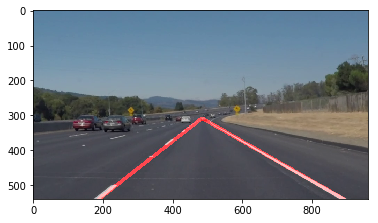

In [144]:
nFrames = 0
white_output = 'test_videos/modified_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [254]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
nFrames = 0
yellow_output = 'test_videos/modified_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960, 3)
avg_neg_slope(before) =  -0.782719300349
mean_negative_slope =  -0.646139690388
nFrames =  1
avg_neg_slope =  -0.714429495369
highest =  [463, 318]
bottom =  [152.26254943409512, 540]
end-points =  463 318 152 540
avg_pos_slope(before) =  0.56743716881
mean_positive_slope =  0.686782617083
avg_pos_slope =  0.627109892947
highest =  [509, 319]
bottom =  [861.41032311184495, 540]
end points =  509 319 861 540
[MoviePy] >>>> Building video test_videos/modified_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/modified_solidYellowLeft.mp4



  0%|          | 0/683 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714429495369
mean_negative_slope =  -0.646139690388
nFrames =  2
avg_neg_slope =  -0.691666227042
highest =  [463, 318]
bottom =  [142.03594057296144, 540]
end-points =  463 318 142 540
avg_pos_slope(before) =  0.627109892947
mean_positive_slope =  0.686782617083
avg_pos_slope =  0.647000800992
highest =  [509, 319]
bottom =  [850.57608408064732, 540]
end points =  509 319 850 540



  0%|          | 2/683 [00:00<00:46, 14.49it/s]

(540, 960, 3)
(540, 960, 3)


(540, 960, 3)



  1%|          | 4/683 [00:00<00:58, 11.56it/s]

(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) =  -0.691666227042
mean_negative_slope =  -0.0581504702194
nFrames =  7
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.647000800992
mean_positive_slope =  nan



  1%|          | 6/683 [00:00<00:54, 12.35it/s]

avg_pos_slope =  0.647000800992
highest =  [0, 1000]
bottom =  [-710.97284469274996, 540]
end points =  0 1000 -710 540
(540, 960, 3)
(540, 960, 3)



  1%|          | 8/683 [00:00<00:50, 13.39it/s]

(540, 960, 3)



  1%|▏         | 10/683 [00:00<00:50, 13.30it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  11
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.647000800992
mean_positive_slope =  0.72493202301
avg_pos_slope =  0.654085457539
highest =  [651, 409]
bottom =  [851.27964005317915, 540]
end points =  651 409 851 540
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  14



  2%|▏         | 13/683 [00:00<00:45, 14.57it/s]

avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.654085457539
mean_positive_slope =  0.628448584847
avg_pos_slope =  0.651754832749
highest =  [614, 383]
bottom =  [854.88812558206575, 540]
end points =  614 383 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  15
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.651754832749
mean_positive_slope =  0.63032870937
avg_pos_slope =  0.649807003351
highest =  [623, 389]
bottom =  [855.37668911122125, 540]
end points =  623 389 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  16
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.649807003351
mean_positive_sl


  2%|▏         | 17/683 [00:01<00:53, 12.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  17
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.645083380849
mean_positive_slope =  0.597949097298
avg_pos_slope =  0.640798445981
highest =  [640, 404]
bottom =  [852.23522131331924, 540]
end points =  640 404 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  18
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.640798445981
mean_positive_slope =  0.601050095781
avg_pos_slope =  0.637184959599
highest =  [655, 413]
bottom =  [854.31418356123697, 540]
end points =  655 413 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  19
avg_neg_slope = 


  3%|▎         | 21/683 [00:01<00:45, 14.55it/s]

 -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.637184959599
mean_positive_slope =  0.674846625767
avg_pos_slope =  0.640608747433
highest =  [673, 426]
bottom =  [850.95573422450241, 540]
end points =  673 426 850 540
(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  21
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.640608747433
mean_positive_slope =  0.603299822914
avg_pos_slope =  0.637217027022
highest =  [604, 379]
bottom =  [856.66117064145385, 540]
end points =  604 379 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  22
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.637217027022
mean_positive_slo


  4%|▎         | 25/683 [00:01<00:43, 15.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  24
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.636235279769
mean_positive_slope =  0.6125
avg_pos_slope =  0.634077527063
highest =  [592, 371]
bottom =  [858.52892239048936, 540]
end points =  592 371 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  25
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.634077527063
mean_positive_slope =  0.628251208909
avg_pos_slope =  0.633547861776
highest =  [564, 352]
bottom =  [860.74159024550829, 540]
end points =  564 352 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  26
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 5


  4%|▍         | 27/683 [00:01<00:44, 14.76it/s]

avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.6327184926
mean_positive_slope =  0.642838161019
avg_pos_slope =  0.633638462456
highest =  [539, 337]
bottom =  [859.37196607831481, 540]
end points =  539 337 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  28
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.633638462456
mean_positive_slope =  0.622385569786
avg_pos_slope =  0.632615472214
highest =  [539, 339]
bottom =  [856.72855522591908, 540]
end points =  539 339 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  -0.599943534726
nFrames =  29
avg_neg_slope =  -0.611337373556
highest =  [300, 442]
bottom =  [139.69571591881677, 540]
end-points =  300 442 139 540
avg_pos_slope(before) =  0.632615472214
mea


  5%|▍         | 33/683 [00:02<00:37, 17.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.608196040173
mean_negative_slope =  -0.534653465347
nFrames =  31
avg_neg_slope =  -0.601510351553
highest =  [242, 484]
bottom =  [148.90102031421071, 540]
end-points =  242 484 148 540
avg_pos_slope(before) =  0.632641738027
mean_positive_slope =  0.623935489491
avg_pos_slope =  0.631850260888
highest =  [545, 339]
bottom =  [863.11334495238589, 540]
end points =  545 339 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.601510351553
mean_negative_slope =  -0.708778992454
nFrames =  32
avg_neg_slope =  -0.61126204618
highest =  [448, 325]
bottom =  [96.268690419144079, 540]
end-points =  448 325 96 540
avg_pos_slope(before) =  0.631850260888
mean_positive_slope =  0.609595552261
avg_pos_slope =  0.629827105558
highest =  [540, 334]
bottom =  [867.07388771005151, 540]
end points =  540 334 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.61126204618
mean_negative_slope =  -0.712087566488
nFrames =  33
avg_neg_slope =  -0.620428002572
highest 


  5%|▌         | 36/683 [00:02<00:35, 18.04it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.632030902872
mean_negative_slope =  -0.710685703973
nFrames =  35
avg_neg_slope =  -0.639181339336
highest =  [401, 364]
bottom =  [125.64778120271956, 540]
end-points =  401 364 125 540
avg_pos_slope(before) =  0.628174116012
mean_positive_slope =  0.598220461157
avg_pos_slope =  0.62545105648
highest =  [533, 332]
bottom =  [865.55999465529123, 540]
end points =  533 332 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.639181339336
mean_negative_slope =  -0.711461986895
nFrames =  36
avg_neg_slope =  -0.645752307296
highest =  [437, 334]
bottom =  [117.99223545538369, 540]
end-points =  437 334 117 540
avg_pos_slope(before) =  0.62545105648
mean_positive_slope =  0.639475491117
avg_pos_slope =  0.626726005083
highest =  [531, 330]
bottom =  [866.07465510735335, 540]
end points =  531 330 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.645752307296
mean_negative_slope =  -0.736822503685
nFrames =  37
avg_neg_slope =  -0.654031416059
highest


  6%|▌         | 42/683 [00:02<00:31, 20.17it/s]

540
avg_pos_slope(before) =  0.627260567167
mean_positive_slope =  0.606762976014
avg_pos_slope =  0.62539714979
highest =  [535, 332]
bottom =  [867.58865997375324, 540]
end points =  535 332 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.667615702743
mean_negative_slope =  -0.735043799992
nFrames =  40
avg_neg_slope =  -0.673745529766
highest =  [439, 330]
bottom =  [127.30962029087013, 540]
end-points =  439 330 127 540
avg_pos_slope(before) =  0.62539714979
mean_positive_slope =  0.612788678105
avg_pos_slope =  0.624250925091
highest =  [536, 333]
bottom =  [867.59742609873729, 540]
end points =  536 333 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.673745529766
mean_negative_slope =  -0.728857434468
nFrames =  41
avg_neg_slope =  -0.67875570292
highest =  [438, 330]
bottom =  [128.61033432729957, 540]
end-points =  438 330 128 540
avg_pos_slope(before) =  0.624250925091
mean_positive_slope =  0.580924790858
avg_pos_slope =  0.620312185615
highest =  [538, 333]
bottom =  [87


  7%|▋         | 45/683 [00:02<00:34, 18.25it/s]

 -0.691213422421
mean_negative_slope =  -0.727529680447
nFrames =  44
avg_neg_slope =  -0.694514900423
highest =  [440, 329]
bottom =  [136.19082344884359, 540]
end-points =  440 329 136 540
avg_pos_slope(before) =  0.618224663208
mean_positive_slope =  0.636820493492
avg_pos_slope =  0.619915193234
highest =  [525, 327]
bottom =  [868.59538582842526, 540]
end points =  525 327 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694514900423
mean_negative_slope =  -0.727346582738
nFrames =  45
avg_neg_slope =  -0.697499598815
highest =  [442, 328]
bottom =  [138.05717284983001, 540]
end-points =  442 328 138 540
avg_pos_slope(before) =  0.619915193234
mean_positive_slope =  0.600242338785
avg_pos_slope =  0.61812675192
highest =  [524, 327]
bottom =  [868.5895187974985, 540]
end points =  524 327 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697499598815
mean_negative_slope =  -0.719517845198
nFrames =  46
avg_neg_slope =  -0.699501257577
highest =  [443, 328]
bottom =  [139.92692085


  7%|▋         | 49/683 [00:03<00:39, 16.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70229986194
mean_negative_slope =  -0.719499232391
nFrames =  49
avg_neg_slope =  -0.703863441072
highest =  [446, 326]
bottom =  [141.96375161324599, 540]
end-points =  446 326 141 540
avg_pos_slope(before) =  0.620622389095
mean_positive_slope =  0.628119603361
avg_pos_slope =  0.621303954028
highest =  [513, 321]
bottom =  [865.48447813704274, 540]
end points =  513 321 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703863441072
mean_negative_slope =  -0.737456809839
nFrames =  50
avg_neg_slope =  -0.706917383687
highest =  [439, 332]
bottom =  [144.76476855722549, 540]
end-points =  439 332 144 540
avg_pos_slope(before) =  0.621303954028
mean_positive_slope =  0.613811420243
avg_pos_slope =  0.620622814593
highest =  [516, 323]
bottom =  [865.64876394745318, 540]
end points =  516 323 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706917383687
mean_negative_slope =  -0.730486320134
nFrames =  51
avg_neg_slope =  -0.709060014273
highes


  8%|▊         | 53/683 [00:03<00:42, 14.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709060014273
mean_negative_slope =  -0.738362644627
nFrames =  52
avg_neg_slope =  -0.71172388976
highest =  [444, 327]
bottom =  [144.72663983227034, 540]
end-points =  444 327 144 540
avg_pos_slope(before) =  0.619525287803
mean_positive_slope =  0.609951662577
avg_pos_slope =  0.618654958237
highest =  [519, 324]
bottom =  [868.14453868674684, 540]
end points =  519 324 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71172388976
mean_negative_slope =  -0.738756391742
nFrames =  53
avg_neg_slope =  -0.71418138994
highest =  [444, 327]
bottom =  [145.75644030999916, 540]
end-points =  444 327 145 540
avg_pos_slope(before) =  0.618654958237
mean_positive_slope =  0.626919749668
avg_pos_slope =  0.619406302913
highest =  [518, 325]
bottom =  [865.10657445520349, 540]
end points =  518 325 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71418138994
mean_negative_slope =  -0.742293726068
nFrames =  54
avg_neg_slope =  -0.716737056861
highest =


  8%|▊         | 55/683 [00:03<00:41, 15.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716737056861
mean_negative_slope =  -0.73299824534
nFrames =  55
avg_neg_slope =  -0.718215346722
highest =  [448, 325]
bottom =  [148.64688678519158, 540]
end-points =  448 325 148 540
avg_pos_slope(before) =  0.618361562803
mean_positive_slope =  0.607943999553
avg_pos_slope =  0.617414511599
highest =  [511, 320]
bottom =  [867.32463420771785, 540]
end points =  511 320 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718215346722
mean_negative_slope =  -0.700509452784
nFrames =  56
avg_neg_slope =  -0.716605720001
highest =  [448, 325]
bottom =  [147.97448527232484, 540]
end-points =  448 325 147 540
avg_pos_slope(before) =  0.617414511599
mean_positive_slope =  0.613017220265
avg_pos_slope =  0.617014757841
highest =  [511, 320]
bottom =  [867.5554911031993, 540]
end points =  511 320 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716605720001
mean_negative_slope =  nan
nFrames =  57
avg_neg_slope =  -0.716605720001
highest =  [446, 32


  9%|▊         | 59/683 [00:03<00:45, 13.82it/s]

 -0.716605720001
mean_negative_slope =  -0.72641375416
nFrames =  58
avg_neg_slope =  -0.71749735947
highest =  [446, 326]
bottom =  [147.74106263168517, 540]
end-points =  446 326 147 540
avg_pos_slope(before) =  0.618138052562
mean_positive_slope =  0.644586338625
avg_pos_slope =  0.620542442204
highest =  [511, 320]
bottom =  [865.5285302620947, 540]
end points =  511 320 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71749735947
mean_negative_slope =  -0.737342995236
nFrames =  59
avg_neg_slope =  -0.719301508176
highest =  [446, 326]
bottom =  [148.48915431478693, 540]
end-points =  446 326 148 540
avg_pos_slope(before) =  0.620542442204
mean_positive_slope =  0.646853306815
avg_pos_slope =  0.622934338987
highest =  [507, 318]
bottom =  [863.37784932665568, 540]
end points =  507 318 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719301508176
mean_negative_slope =  -0.735242494745
nFrames =  60
avg_neg_slope =  -0.720750688773
highest =  [446, 326]
bottom =  [149.0873458277


  9%|▉         | 61/683 [00:04<00:44, 14.05it/s]


avg_neg_slope(before) =  -0.720750688773
mean_negative_slope =  -0.737822162635
nFrames =  61
avg_neg_slope =  -0.722302640942
highest =  [448, 325]
bottom =  [150.34083635697002, 540]
end-points =  448 325 150 540
avg_pos_slope(before) =  0.623805572997
mean_positive_slope =  0.62800600091
avg_pos_slope =  0.62418743008
highest =  [507, 318]
bottom =  [862.66240090996109, 540]
end points =  507 318 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722302640942
mean_negative_slope =  -0.710723455033
nFrames =  62
avg_neg_slope =  -0.721249987678
highest =  [444, 327]
bottom =  [148.67937103776168, 540]
end-points =  444 327 148 540
avg_pos_slope(before) =  0.62418743008
mean_positive_slope =  0.610718170199
avg_pos_slope =  0.622962951909
highest =  [509, 320]
bottom =  [862.15101696804732, 540]
end points =  509 320 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.721249987678
mean_negative_slope =  -0.736263386523
nFrames =  63
avg_neg_slope =  -0.722614842118
highest =  [446, 326]


 10%|▉         | 65/683 [00:04<00:41, 14.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.72016043693
mean_negative_slope =  -0.713297624842
nFrames =  65
avg_neg_slope =  -0.719536544922
highest =  [448, 325]
bottom =  [149.1965528127071, 540]
end-points =  448 325 149 540
avg_pos_slope(before) =  0.621131758718
mean_positive_slope =  0.603198980015
avg_pos_slope =  0.619501506108
highest =  [507, 318]
bottom =  [865.3526396806061, 540]
end points =  507 318 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719536544922
mean_negative_slope =  -0.713322121383
nFrames =  66
avg_neg_slope =  -0.718971597328
highest =  [448, 325]
bottom =  [148.96176149502563, 540]
end-points =  448 325 148 540
avg_pos_slope(before) =  0.619501506108
mean_positive_slope =  0.60866907136
avg_pos_slope =  0.618516739313
highest =  [505, 317]
bottom =  [865.53995927048766, 540]
end points =  505 317 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718971597328
mean_negative_slope =  -0.702062297762
nFrames =  67
avg_neg_slope =  -0.717434388276
highest =


 10%|█         | 69/683 [00:04<00:40, 15.09it/s]

highest =  [450, 324]
bottom =  [149.80369938929579, 540]
end-points =  450 324 149 540
avg_pos_slope(before) =  0.620335928235
mean_positive_slope =  0.625166136706
avg_pos_slope =  0.620775038096
highest =  [505, 317]
bottom =  [864.2283618297995, 540]
end points =  505 317 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719529186604
mean_negative_slope =  -0.687638344836
nFrames =  69
avg_neg_slope =  -0.716630019171
highest =  [451, 324]
bottom =  [149.58923820976329, 540]
end-points =  451 324 149 540
avg_pos_slope(before) =  0.620775038096
mean_positive_slope =  0.649211087409
avg_pos_slope =  0.623360133488
highest =  [503, 316]
bottom =  [862.34283886044489, 540]
end points =  503 316 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716630019171
mean_negative_slope =  -0.702059887428
nFrames =  70
avg_neg_slope =  -0.71530546174
highest =  [452, 324]
bottom =  [150.03110481680514, 540]
end-points =  452 324 150 540
avg_pos_slope(before) =  0.623360133488
mean_positive_slope 


 11%|█         | 73/683 [00:04<00:37, 16.36it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712575053579
mean_negative_slope =  -0.709992533156
nFrames =  73
avg_neg_slope =  -0.712340278995
highest =  [453, 323]
bottom =  [148.37030770447259, 540]
end-points =  453 323 148 540
avg_pos_slope(before) =  0.628694014373
mean_positive_slope =  0.631266095296
avg_pos_slope =  0.628927839912
highest =  [502, 316]
bottom =  [858.16168626182036, 540]
end points =  502 316 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712340278995
mean_negative_slope =  -0.691650879021
nFrames =  74
avg_neg_slope =  -0.710459424452
highest =  [446, 329]
bottom =  [149.00907731256024, 540]
end-points =  446 329 149 540
avg_pos_slope(before) =  0.628927839912
mean_positive_slope =  0.643563987182
avg_pos_slope =  0.630258398755
highest =  [501, 315]
bottom =  [857.99643264510894, 540]
end points =  501 315 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710459424452
mean_negative_slope =  -0.701158819891
nFrames =  75
avg_neg_slope =  -0.709613914947
highe


 11%|█▏        | 77/683 [00:04<00:36, 16.66it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708846713513
mean_negative_slope =  -0.714940196772
nFrames =  77
avg_neg_slope =  -0.709400666537
highest =  [454, 322]
bottom =  [146.69834342801735, 540]
end-points =  454 322 146 540
avg_pos_slope(before) =  0.629344492997
mean_positive_slope =  0.641566344819
avg_pos_slope =  0.630455570435
highest =  [499, 314]
bottom =  [857.47093847380643, 540]
end points =  499 314 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709400666537
mean_negative_slope =  -0.709947054206
nFrames =  78
avg_neg_slope =  -0.709450338143
highest =  [456, 321]
bottom =  [147.31031697972949, 540]
end-points =  456 321 147 540
avg_pos_slope(before) =  0.630455570435
mean_positive_slope =  0.64412535178
avg_pos_slope =  0.63169827783
highest =  [499, 314]
bottom =  [856.76573711145124, 540]
end points =  499 314 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709450338143
mean_negative_slope =  -0.719875919226
nFrames =  79
avg_neg_slope =  -0.710398118241
highest


 12%|█▏        | 83/683 [00:05<00:34, 17.51it/s]

 [508, 319]
bottom =  [858.7451679649738, 540]
end points =  508 319 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710473760839
mean_negative_slope =  -0.713218502081
nFrames =  81
avg_neg_slope =  -0.71072328277
highest =  [452, 324]
bottom =  [148.08424933242625, 540]
end-points =  452 324 148 540
avg_pos_slope(before) =  0.630087083686
mean_positive_slope =  0.649921041669
avg_pos_slope =  0.631890170775
highest =  [501, 315]
bottom =  [857.0745370100193, 540]
end points =  501 315 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71072328277
mean_negative_slope =  -0.697099134673
nFrames =  82
avg_neg_slope =  -0.709484723852
highest =  [456, 321]
bottom =  [147.32527785670177, 540]
end-points =  456 321 147 540
avg_pos_slope(before) =  0.631890170775
mean_positive_slope =  0.658534130683
avg_pos_slope =  0.634312348949
highest =  [501, 315]
bottom =  [855.71483469131056, 540]
end points =  501 315 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709484723852
mean_negative_slo


 12%|█▏        | 85/683 [00:05<00:36, 16.58it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708878864531
mean_negative_slope =  -0.694556455871
nFrames =  85
avg_neg_slope =  -0.70757682738
highest =  [452, 323]
bottom =  [145.31952149495905, 540]
end-points =  452 323 145 540
avg_pos_slope(before) =  0.638962431909
mean_positive_slope =  0.639345353468
avg_pos_slope =  0.638997242959
highest =  [502, 316]
bottom =  [852.54924331530515, 540]
end points =  502 316 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.70757682738
mean_negative_slope =  -0.707986140191
nFrames =  86
avg_neg_slope =  -0.707614037636
highest =  [452, 323]
bottom =  [145.33564844886857, 540]
end-points =  452 323 145 540
avg_pos_slope(before) =  0.638997242959
mean_positive_slope =  0.655241558726
avg_pos_slope =  0.640473998938
highest =  [503, 316]
bottom =  [852.74097367160584, 540]
end points =  503 316 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707614037636
mean_negative_slope =  -0.703939392367
nFrames =  87
avg_neg_slope =  -0.707279978975
highest


 13%|█▎        | 89/683 [00:05<00:36, 16.10it/s]

 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706228279306
mean_negative_slope =  -0.688736734596
nFrames =  89
avg_neg_slope =  -0.704638138878
highest =  [454, 322]
bottom =  [144.62134452859502, 540]
end-points =  454 322 144 540
avg_pos_slope(before) =  0.641206618874
mean_positive_slope =  0.637826311142
avg_pos_slope =  0.640899318171
highest =  [503, 317]
bottom =  [850.9485680160949, 540]
end points =  503 317 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.704638138878
mean_negative_slope =  -0.692041942503
nFrames =  90
avg_neg_slope =  -0.703493030117
highest =  [449, 326]
bottom =  [144.80366707473067, 540]
end-points =  449 326 144 540
avg_pos_slope(before) =  0.640899318171
mean_positive_slope =  0.637327342848
avg_pos_slope =  0.640574593141
highest =  [501, 315]
bottom =  [852.24714968257592, 540]
end points =  501 315 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703493030117
mean_negative_slope =  -0.688158605644
nFrames =  91
avg_neg_slope =  -0.702098991528
h


 14%|█▎        | 93/683 [00:06<00:38, 15.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700767491896
mean_negative_slope =  -0.686253380225
nFrames =  93
avg_neg_slope =  -0.699448027199
highest =  [459, 320]
bottom =  [144.46626561935844, 540]
end-points =  459 320 144 540
avg_pos_slope(before) =  0.642167938393
mean_positive_slope =  0.632918767382
avg_pos_slope =  0.641327104665
highest =  [490, 310]
bottom =  [848.63134167745886, 540]
end points =  490 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699448027199
mean_negative_slope =  nan
nFrames =  94
avg_neg_slope =  -0.699448027199
highest =  [481, 310]
bottom =  [152.16927769296555, 540]
end-points =  481 310 152 540
avg_pos_slope(before) =  0.641327104665
mean_positive_slope =  0.64356681171
avg_pos_slope =  0.641530714396
highest =  [485, 310]
bottom =  [843.51751886352429, 540]
end points =  485 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699448027199
mean_negative_slope =  nan
nFrames =  95
avg_neg_slope =  -0.699448027199
highest =  [467, 316]
bottom =


 14%|█▍        | 97/683 [00:06<00:38, 15.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.699448027199
mean_negative_slope =  -0.686611846821
nFrames =  96
avg_neg_slope =  -0.69828110171
highest =  [467, 316]
bottom =  [146.21228363261872, 540]
end-points =  467 316 146 540
avg_pos_slope(before) =  0.645417167096
mean_positive_slope =  0.664816384808
avg_pos_slope =  0.647180732343
highest =  [493, 313]
bottom =  [843.75209853388435, 540]
end points =  493 313 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69828110171
mean_negative_slope =  -0.688643151679
nFrames =  97
avg_neg_slope =  -0.697404924434
highest =  [467, 316]
bottom =  [145.80926538953312, 540]
end-points =  467 316 145 540
avg_pos_slope(before) =  0.647180732343
mean_positive_slope =  0.658207781346
avg_pos_slope =  0.648183191343
highest =  [491, 312]
bottom =  [842.75241049908743, 540]
end points =  491 312 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697404924434
mean_negative_slope =  -0.69285205415
nFrames =  98
avg_neg_slope =  -0.696991027136
highest 


 14%|█▍        | 99/683 [00:06<00:38, 14.98it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696991027136
mean_negative_slope =  -0.697701277262
nFrames =  99
avg_neg_slope =  -0.697055595329
highest =  [492, 311]
bottom =  [163.47527179392614, 540]
end-points =  492 311 163 540
avg_pos_slope(before) =  0.648924560091
mean_positive_slope =  0.608333333333
avg_pos_slope =  0.645234448567
highest =  [493, 312]
bottom =  [846.35993065200125, 540]
end points =  493 312 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697055595329
mean_negative_slope =  -0.695413576959
nFrames =  100
avg_neg_slope =  -0.696906320932
highest =  [461, 319]
bottom =  [143.8842078738642, 540]
end-points =  461 319 143 540
avg_pos_slope(before) =  0.645234448567
mean_positive_slope =  0.638128056914
avg_pos_slope =  0.644588412962
highest =  [492, 311]
bottom =  [847.26546148659043, 540]
end points =  492 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.696906320932
mean_negative_slope =  -0.700028353225
nFrames =  101
avg_neg_slope =  -0.697190142049
high


 15%|█▌        | 103/683 [00:06<00:37, 15.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696669973949
mean_negative_slope =  -0.688941870454
nFrames =  103
avg_neg_slope =  -0.695967419086
highest =  [463, 318]
bottom =  [144.01955075481047, 540]
end-points =  463 318 144 540
avg_pos_slope(before) =  0.645005211825
mean_positive_slope =  0.662511208592
avg_pos_slope =  0.646596666076
highest =  [491, 311]
bottom =  [845.16204879256338, 540]
end points =  491 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695967419086
mean_negative_slope =  -0.674968258647
nFrames =  104
avg_neg_slope =  -0.6940584045
highest =  [463, 318]
bottom =  [143.14219183788518, 540]
end-points =  463 318 143 540
avg_pos_slope(before) =  0.646596666076
mean_positive_slope =  0.642157023673
avg_pos_slope =  0.646193062221
highest =  [491, 311]
bottom =  [845.3832538417912, 540]
end points =  491 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.6940584045
mean_negative_slope =  -0.685169116346
nFrames =  105
avg_neg_slope =  -0.693250287395
highest


 16%|█▌        | 107/683 [00:07<01:18,  7.36it/s]

mean_negative_slope =  -0.709848919033
nFrames =  106
avg_neg_slope =  -0.694759253908
highest =  [463, 318]
bottom =  [143.46485347080878, 540]
end-points =  463 318 143 540
avg_pos_slope(before) =  0.645845753856
mean_positive_slope =  0.641887154752
avg_pos_slope =  0.64548588121
highest =  [493, 311]
bottom =  [847.77150882180661, 540]
end points =  493 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694759253908
mean_negative_slope =  -0.669311721082
nFrames =  107
avg_neg_slope =  -0.692445841833
highest =  [463, 318]
bottom =  [142.39730938037914, 540]
end-points =  463 318 142 540
avg_pos_slope(before) =  0.64548588121
mean_positive_slope =  0.631878163334
avg_pos_slope =  0.644248815948
highest =  [491, 311]
bottom =  [846.45272933546289, 540]
end points =  491 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692445841833
mean_negative_slope =  nan
nFrames =  108
avg_neg_slope =  -0.692445841833
highest =  [438, 337]
bottom =  [144.83627839737363, 540]
end-points = 

 16%|█▋        | 111/683 [00:07<00:54, 10.55it/s]

 324 138 540
avg_pos_slope(before) =  0.645507474096
mean_positive_slope =  0.663508056186
avg_pos_slope =  0.647143890649
highest =  [492, 312]
bottom =  [844.31731813336762, 540]
end points =  492 312 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692445841833
mean_negative_slope =  -0.674569324812
nFrames =  110
avg_neg_slope =  -0.690820703922
highest =  [467, 316]
bottom =  [142.74799260025594, 540]
end-points =  467 316 142 540
avg_pos_slope(before) =  0.647143890649
mean_positive_slope =  0.657910240292
avg_pos_slope =  0.648122649708
highest =  [490, 312]
bottom =  [841.78526796244864, 540]
end points =  490 312 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.690820703922
mean_negative_slope =  -0.671735190464
nFrames =  111
avg_neg_slope =  -0.689085657244
highest =  [443, 335]
bottom =  [145.50432896847445, 540]
end-points =  443 335 145 540
avg_pos_slope(before) =  0.648122649708
mean_positive_slope =  0.643379536543
avg_pos_slope =  0.647691457602
highest =  [492, 313]

 17%|█▋        | 115/683 [00:08<00:42, 13.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688560867955
mean_negative_slope =  -0.688703599275
nFrames =  114
avg_neg_slope =  -0.688573843529
highest =  [469, 315]
bottom =  [142.23766054386525, 540]
end-points =  469 315 142 540
avg_pos_slope(before) =  0.647739711405
mean_positive_slope =  0.628591476954
avg_pos_slope =  0.645998962818
highest =  [487, 310]
bottom =  [843.03772333724032, 540]
end points =  487 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688573843529
mean_negative_slope =  -0.68764862306
nFrames =  115
avg_neg_slope =  -0.688489732578
highest =  [469, 315]
bottom =  [142.19774086157253, 540]
end-points =  469 315 142 540
avg_pos_slope(before) =  0.645998962818
mean_positive_slope =  0.636973277509
avg_pos_slope =  0.645178445972
highest =  [487, 310]
bottom =  [843.49052046915938, 540]
end points =  487 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688489732578
mean_negative_slope =  -0.687861152967
nFrames =  116
avg_neg_slope =  -0.688432588977
hig

 17%|█▋        | 119/683 [00:08<00:39, 14.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688366817647
mean_negative_slope =  -0.687338090889
nFrames =  118
avg_neg_slope =  -0.688273297033
highest =  [480, 310]
bottom =  [145.8304179581346, 540]
end-points =  480 310 145 540
avg_pos_slope(before) =  0.644154949453
mean_positive_slope =  0.634793798508
avg_pos_slope =  0.643303935731
highest =  [490, 310]
bottom =  [847.52929093895966, 540]
end points =  490 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688273297033
mean_negative_slope =  nan
nFrames =  119
avg_neg_slope =  -0.688273297033
highest =  [480, 310]
bottom =  [145.8304179581346, 540]
end-points =  480 310 145 540
avg_pos_slope(before) =  0.643303935731
mean_positive_slope =  0.639689008396
avg_pos_slope =  0.642975305973
highest =  [491, 310]
bottom =  [848.71202698365653, 540]
end points =  491 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688273297033
mean_negative_slope =  nan
nFrames =  120
avg_neg_slope =  -0.688273297033
highest =  [480, 310]
bottom

 18%|█▊        | 121/683 [00:08<00:39, 14.40it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688273297033
mean_negative_slope =  -0.68317049207
nFrames =  121
avg_neg_slope =  -0.687809405673
highest =  [480, 310]
bottom =  [145.605038106281, 540]
end-points =  480 310 145 540
avg_pos_slope(before) =  0.642392909377
mean_positive_slope =  0.648426807496
avg_pos_slope =  0.642941445569
highest =  [488, 310]
bottom =  [845.73086582761891, 540]
end points =  488 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.687809405673
mean_negative_slope =  -0.668086208496
nFrames =  122
avg_neg_slope =  -0.686016387747
highest =  [487, 310]
bottom =  [151.73104125801333, 540]
end-points =  487 310 151 540
avg_pos_slope(before) =  0.642941445569
mean_positive_slope =  0.63098344441
avg_pos_slope =  0.641854354555
highest =  [488, 310]
bottom =  [846.33674472691723, 540]
end points =  488 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686016387747
mean_negative_slope =  -0.714481648759
nFrames =  123
avg_neg_slope =  -0.688604138748
highes

 19%|█▊        | 127/683 [00:08<00:32, 16.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690743862363
mean_negative_slope =  -0.713724359417
nFrames =  125
avg_neg_slope =  -0.692832998459
highest =  [471, 314]
bottom =  [144.80306581408865, 540]
end-points =  471 314 144 540
avg_pos_slope(before) =  0.642554372709
mean_positive_slope =  0.64140684389
avg_pos_slope =  0.642450051907
highest =  [490, 311]
bottom =  [846.44794380548967, 540]
end points =  490 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692832998459
mean_negative_slope =  -0.706406486294
nFrames =  126
avg_neg_slope =  -0.694066951898
highest =  [471, 315]
bottom =  [146.82378128696428, 540]
end-points =  471 315 146 540
avg_pos_slope(before) =  0.642450051907
mean_positive_slope =  0.627489604498
avg_pos_slope =  0.641090011233
highest =  [486, 311]
bottom =  [843.20413044558416, 540]
end points =  486 311 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694066951898
mean_negative_slope =  -0.708883295763
nFrames =  127
avg_neg_slope =  -0.695413892249
hig

 19%|█▉        | 129/683 [00:08<00:32, 17.07it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.695963269027
mean_negative_slope =  -0.704762036795
nFrames =  129
avg_neg_slope =  -0.696763157006
highest =  [479, 310]
bottom =  [148.90217882889615, 540]
end-points =  479 310 148 540
avg_pos_slope(before) =  0.638025428582
mean_positive_slope =  0.626615817173
avg_pos_slope =  0.636988191181
highest =  [485, 310]
bottom =  [846.07419758202036, 540]
end points =  485 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.696763157006
mean_negative_slope =  -0.701398187593
nFrames =  130
avg_neg_slope =  -0.697184523423
highest =  [479, 310]
bottom =  [149.10168431345559, 540]
end-points =  479 310 149 540
avg_pos_slope(before) =  0.636988191181
mean_positive_slope =  0.639317502722
avg_pos_slope =  0.637199946776
highest =  [485, 310]
bottom =  [845.95420466330904, 540]
end points =  485 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697184523423
mean_negative_slope =  -0.699633033011
nFrames =  131
avg_neg_slope =  -0.697407115204
hi

 20%|█▉        | 135/683 [00:09<00:31, 17.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.697407115204
mean_negative_slope =  -0.694987791639
nFrames =  133
avg_neg_slope =  -0.697187176698
highest =  [478, 311]
bottom =  [149.53727484686794, 540]
end-points =  478 311 149 540
avg_pos_slope(before) =  0.636012508519
mean_positive_slope =  0.649788484445
avg_pos_slope =  0.637264869967
highest =  [483, 310]
bottom =  [843.91743141596623, 540]
end points =  483 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697187176698
mean_negative_slope =  -0.69918753762
nFrames =  134
avg_neg_slope =  -0.697369027691
highest =  [478, 311]
bottom =  [149.62292716340161, 540]
end-points =  478 311 149 540
avg_pos_slope(before) =  0.637264869967
mean_positive_slope =  0.640215895457
avg_pos_slope =  0.637533145011
highest =  [483, 310]
bottom =  [843.76555673972052, 540]
end points =  483 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697369027691
mean_negative_slope =  -0.707153499618
nFrames =  135
avg_neg_slope =  -0.698258525139
hig

 20%|██        | 137/683 [00:09<00:30, 17.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698480924606
mean_negative_slope =  -0.704401167623
nFrames =  137
avg_neg_slope =  -0.699019128517
highest =  [484, 310]
bottom =  [154.96751631383447, 540]
end-points =  484 310 154 540
avg_pos_slope(before) =  0.636194499991
mean_positive_slope =  0.630408933575
avg_pos_slope =  0.635668539408
highest =  [485, 310]
bottom =  [846.82378982325861, 540]
end points =  485 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699019128517
mean_negative_slope =  -0.715787533356
nFrames =  138
avg_neg_slope =  -0.700543528957
highest =  [479, 310]
bottom =  [150.68349932151062, 540]
end-points =  479 310 150 540
avg_pos_slope(before) =  0.635668539408
mean_positive_slope =  0.616287231472
avg_pos_slope =  0.633906602323
highest =  [480, 310]
bottom =  [842.82947544194735, 540]
end points =  480 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700543528957
mean_negative_slope =  -0.716601889482
nFrames =  139
avg_neg_slope =  -0.702003379913
hi

 21%|██        | 141/683 [00:09<00:34, 15.79it/s]

0.646895621831
avg_pos_slope =  0.634728798696
highest =  [484, 311]
bottom =  [844.7840080213897, 540]
end points =  484 311 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700696964599
mean_negative_slope =  -0.707792145754
nFrames =  141
avg_neg_slope =  -0.701341981068
highest =  [477, 311]
bottom =  [150.48311354272806, 540]
end-points =  477 311 150 540
avg_pos_slope(before) =  0.634728798696
mean_positive_slope =  0.634329414538
avg_pos_slope =  0.634692491045
highest =  [484, 310]
bottom =  [846.38021285133868, 540]
end points =  484 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701341981068
mean_negative_slope =  -0.699687416549
nFrames =  142
avg_neg_slope =  -0.701191566111
highest =  [480, 311]
bottom =  [153.41307130953092, 540]
end-points =  480 311 153 540
avg_pos_slope(before) =  0.634692491045
mean_positive_slope =  0.622416219338
avg_pos_slope =  0.633576466344
highest =  [482, 310]
bottom =  [845.01853401705523, 540]
end points =  482 310 845 540
(540, 960,

 21%|██        | 145/683 [00:09<00:34, 15.78it/s]


avg_neg_slope(before) =  -0.702346885226
mean_negative_slope =  -0.675996703902
nFrames =  144
avg_neg_slope =  -0.699951414196
highest =  [482, 311]
bottom =  [154.83443485433898, 540]
end-points =  482 311 154 540
avg_pos_slope(before) =  0.636643072439
mean_positive_slope =  0.651811160444
avg_pos_slope =  0.638021989531
highest =  [483, 310]
bottom =  [843.48914265357701, 540]
end points =  483 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699951414196
mean_negative_slope =  -0.637264680315
nFrames =  145
avg_neg_slope =  -0.694252620207
highest =  [482, 310]
bottom =  [150.70848837210059, 540]
end-points =  482 310 150 540
avg_pos_slope(before) =  0.638021989531
mean_positive_slope =  0.606656346187
avg_pos_slope =  0.635170567408
highest =  [481, 311]
bottom =  [841.53307843650214, 540]
end points =  481 311 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694252620207
mean_negative_slope =  -0.683538805241
nFrames =  146
avg_neg_slope =  -0.693278637028
highest =  [482

 22%|██▏       | 150/683 [00:10<00:30, 17.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.693260703551
mean_negative_slope =  -0.720444224282
nFrames =  148
avg_neg_slope =  -0.695731932709
highest =  [477, 313]
bottom =  [150.72490850567974, 540]
end-points =  477 313 150 540
avg_pos_slope(before) =  0.636266807427
mean_positive_slope =  0.608645537972
avg_pos_slope =  0.633755782931
highest =  [480, 312]
bottom =  [839.76003082033378, 540]
end points =  480 312 839 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695731932709
mean_negative_slope =  -0.7170142803
nFrames =  149
avg_neg_slope =  -0.69766669158
highest =  [481, 311]
bottom =  [152.76303131051804, 540]
end-points =  481 311 152 540
avg_pos_slope(before) =  0.633755782931
mean_positive_slope =  0.629530369828
avg_pos_slope =  0.633371654468
highest =  [480, 311]
bottom =  [841.55707061523879, 540]
end points =  480 311 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69766669158
mean_negative_slope =  -0.713545634524
nFrames =  150
avg_neg_slope =  -0.699110231848
highes

 23%|██▎       | 154/683 [00:10<00:29, 17.93it/s]


avg_neg_slope(before) =  -0.699465542741
mean_negative_slope =  -0.694155441718
nFrames =  152
avg_neg_slope =  -0.698982806284
highest =  [492, 311]
bottom =  [164.3810686883275, 540]
end-points =  492 311 164 540
avg_pos_slope(before) =  0.632067463731
mean_positive_slope =  0.611243405105
avg_pos_slope =  0.630174367492
highest =  [483, 310]
bottom =  [847.97834863600337, 540]
end points =  483 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698982806284
mean_negative_slope =  -0.708046107364
nFrames =  153
avg_neg_slope =  -0.699806742746
highest =  [486, 310]
bottom =  [157.33783378887011, 540]
end-points =  486 310 157 540
avg_pos_slope(before) =  0.630174367492
mean_positive_slope =  0.600750005938
avg_pos_slope =  0.627499425533
highest =  [482, 310]
bottom =  [848.5342000987149, 540]
end points =  482 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699806742746
mean_negative_slope =  -0.724101100536
nFrames =  154
avg_neg_slope =  -0.702015320727
highest =  [474, 

 23%|██▎       | 156/683 [00:10<00:29, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702762088065
mean_negative_slope =  -0.688126675237
nFrames =  156
avg_neg_slope =  -0.701431595989
highest =  [486, 310]
bottom =  [158.09917358288561, 540]
end-points =  486 310 158 540
avg_pos_slope(before) =  0.62389718417
mean_positive_slope =  0.613131433712
avg_pos_slope =  0.622918479583
highest =  [484, 310]
bottom =  [853.22969463671097, 540]
end points =  484 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701431595989
mean_negative_slope =  -0.691096088116
nFrames =  157
avg_neg_slope =  -0.700492004365
highest =  [489, 310]
bottom =  [160.65935004692599, 540]
end-points =  489 310 160 540
avg_pos_slope(before) =  0.622918479583
mean_positive_slope =  0.61281864498
avg_pos_slope =  0.622000312801
highest =  [493, 312]
bottom =  [859.55930118957258, 540]
end points =  493 312 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700492004365
mean_negative_slope =  -0.696692039721
nFrames =  158
avg_neg_slope =  -0.700146553033
high

 24%|██▎       | 161/683 [00:10<00:31, 16.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698778484765
mean_negative_slope =  -0.70048394021
nFrames =  160
avg_neg_slope =  -0.698933526169
highest =  [489, 310]
bottom =  [159.9272178417275, 540]
end-points =  489 310 159 540
avg_pos_slope(before) =  0.617959176044
mean_positive_slope =  0.600527143748
avg_pos_slope =  0.616374445835
highest =  [485, 311]
bottom =  [856.52740764527232, 540]
end points =  485 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698933526169
mean_negative_slope =  -0.688372952337
nFrames =  161
avg_neg_slope =  -0.697973474002
highest =  [488, 310]
bottom =  [158.47458310813238, 540]
end-points =  488 310 158 540
avg_pos_slope(before) =  0.616374445835
mean_positive_slope =  0.603057121379
avg_pos_slope =  0.615163779976
highest =  [483, 312]
bottom =  [853.63300444801791, 540]
end points =  483 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697973474002
mean_negative_slope =  -0.711982972617
nFrames =  162
avg_neg_slope =  -0.699247064785
high

 24%|██▍       | 163/683 [00:10<00:33, 15.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.699247064785
mean_negative_slope =  -0.710902774568
nFrames =  163
avg_neg_slope =  -0.700306674766
highest =  [489, 310]
bottom =  [160.5724577707397, 540]
end-points =  489 310 160 540
avg_pos_slope(before) =  0.615037844895
mean_positive_slope =  0.588612105737
avg_pos_slope =  0.612635504972
highest =  [482, 313]
bottom =  [852.53027151997469, 540]
end points =  482 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700306674766
mean_negative_slope =  -0.724064052495
nFrames =  164
avg_neg_slope =  -0.702466436377
highest =  [490, 310]
bottom =  [162.58222159889604, 540]
end-points =  490 310 162 540
avg_pos_slope(before) =  0.612635504972
mean_positive_slope =  0.577615738056
avg_pos_slope =  0.609451889798
highest =  [478, 311]
bottom =  [853.74746068312072, 540]
end points =  478 311 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702466436377
mean_negative_slope =  -0.714754363052
nFrames =  165
avg_neg_slope =  -0.70358352062
high

 24%|██▍       | 167/683 [00:11<00:31, 16.44it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70511428279
mean_negative_slope =  -0.710329791651
nFrames =  167
avg_neg_slope =  -0.705588419959
highest =  [485, 310]
bottom =  [159.03093149773397, 540]
end-points =  485 310 159 540
avg_pos_slope(before) =  0.604589529755
mean_positive_slope =  0.604924861849
avg_pos_slope =  0.604620014491
highest =  [486, 310]
bottom =  [866.40421171567709, 540]
end points =  486 310 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.705588419959
mean_negative_slope =  -0.71529487803
nFrames =  168
avg_neg_slope =  -0.706470825238
highest =  [484, 310]
bottom =  [158.4380775774263, 540]
end-points =  484 310 158 540
avg_pos_slope(before) =  0.604620014491
mean_positive_slope =  0.594724674962
avg_pos_slope =  0.60372043817
highest =  [491, 310]
bottom =  [871.97103470120942, 540]
end points =  491 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706470825238
mean_negative_slope =  -0.712069049188
nFrames =  169
avg_neg_slope =  -0.706979754688
highes

 25%|██▌       | 171/683 [00:11<00:30, 16.90it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706271456939
mean_negative_slope =  -0.707504463559
nFrames =  171
avg_neg_slope =  -0.70638354845
highest =  [491, 310]
bottom =  [165.39785297294168, 540]
end-points =  491 310 165 540
avg_pos_slope(before) =  0.60061676578
mean_positive_slope =  0.605614716425
avg_pos_slope =  0.60107112493
highest =  [486, 310]
bottom =  [868.65022301135309, 540]
end points =  486 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.70638354845
mean_negative_slope =  -0.713283032454
nFrames =  172
avg_neg_slope =  -0.707010774269
highest =  [487, 310]
bottom =  [161.68671147499094, 540]
end-points =  487 310 161 540
avg_pos_slope(before) =  0.60107112493
mean_positive_slope =  0.566165730743
avg_pos_slope =  0.597897907276
highest =  [485, 310]
bottom =  [869.68105875758636, 540]
end points =  485 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707010774269
mean_negative_slope =  -0.717319112669
nFrames =  173
avg_neg_slope =  -0.707947895942
highest

 26%|██▌       | 177/683 [00:11<00:28, 17.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710640934337
mean_negative_slope =  -0.722831305257
nFrames =  175
avg_neg_slope =  -0.711749149876
highest =  [487, 310]
bottom =  [163.85244156567299, 540]
end-points =  487 310 163 540
avg_pos_slope(before) =  0.591629769148
mean_positive_slope =  0.583221983723
avg_pos_slope =  0.590865425018
highest =  [490, 311]
bottom =  [877.56710124467986, 540]
end points =  490 311 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711749149876
mean_negative_slope =  -0.737015378858
nFrames =  176
avg_neg_slope =  -0.714046079783
highest =  [480, 310]
bottom =  [157.89193651218659, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.590865425018
mean_positive_slope =  0.580069214482
avg_pos_slope =  0.589883951333
highest =  [484, 310]
bottom =  [873.90720035736308, 540]
end points =  484 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714046079783
mean_negative_slope =  -0.726883768735
nFrames =  177
avg_neg_slope =  -0.715213142415
hi

 26%|██▌       | 179/683 [00:11<00:28, 17.53it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.718306031528
mean_negative_slope =  -0.748105871766
nFrames =  179
avg_neg_slope =  -0.721015107914
highest =  [483, 310]
bottom =  [164.00529728764977, 540]
end-points =  483 310 164 540
avg_pos_slope(before) =  0.588825618826
mean_positive_slope =  0.580586757841
avg_pos_slope =  0.588076631464
highest =  [486, 310]
bottom =  [877.10549152005706, 540]
end points =  486 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.721015107914
mean_negative_slope =  -0.74961080147
nFrames =  180
avg_neg_slope =  -0.723614716419
highest =  [486, 310]
bottom =  [168.15129573604878, 540]
end-points =  486 310 168 540
avg_pos_slope(before) =  0.588076631464
mean_positive_slope =  0.576930341564
avg_pos_slope =  0.587063332382
highest =  [490, 310]
bottom =  [881.78055809900866, 540]
end points =  490 310 881 540
(540, 960, 3)
avg_neg_slope(before) =  -0.723614716419
mean_negative_slope =  -0.727802752803
nFrames =  181
avg_neg_slope =  -0.723995446999
hig

 27%|██▋       | 185/683 [00:12<00:27, 18.34it/s]

end points =  483 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.723995446999
mean_negative_slope =  -0.749556987322
nFrames =  183
avg_neg_slope =  -0.726319223392
highest =  [485, 310]
bottom =  [168.33483048148219, 540]
end-points =  485 310 168 540
avg_pos_slope(before) =  0.581824419194
mean_positive_slope =  0.550325316254
avg_pos_slope =  0.578960864382
highest =  [485, 311]
bottom =  [880.53623411928208, 540]
end points =  485 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.726319223392
mean_negative_slope =  -0.761435496094
nFrames =  184
avg_neg_slope =  -0.72951161182
highest =  [483, 310]
bottom =  [167.72057706341027, 540]
end-points =  483 310 167 540
avg_pos_slope(before) =  0.578960864382
mean_positive_slope =  0.564031442573
avg_pos_slope =  0.577603644217
highest =  [487, 310]
bottom =  [885.19693366313049, 540]
end points =  487 310 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.72951161182
mean_negative_slope =  -0.766929598024
nFrames =  185
avg_neg

 27%|██▋       | 187/683 [00:12<00:27, 17.89it/s]


avg_neg_slope(before) =  -0.736043199458
mean_negative_slope =  -0.787144419774
nFrames =  187
avg_neg_slope =  -0.740688764942
highest =  [486, 310]
bottom =  [175.47821151556059, 540]
end-points =  486 310 175 540
avg_pos_slope(before) =  0.575329268191
mean_positive_slope =  0.533622018849
avg_pos_slope =  0.571537700069
highest =  [481, 312]
bottom =  [879.92381547632419, 540]
end points =  481 312 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.740688764942
mean_negative_slope =  -0.793882924056
nFrames =  188
avg_neg_slope =  -0.745524597588
highest =  [486, 310]
bottom =  [177.49240582535543, 540]
end-points =  486 310 177 540
avg_pos_slope(before) =  0.571537700069
mean_positive_slope =  0.551715666155
avg_pos_slope =  0.569735696986
highest =  [482, 311]
bottom =  [883.94076167523872, 540]
end points =  482 311 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.745524597588
mean_negative_slope =  -0.767872474183
nFrames =  189
avg_neg_slope =  -0.747556222733
highest =  [485

 28%|██▊       | 191/683 [00:12<00:28, 17.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.749446210651
mean_negative_slope =  -0.76927707274
nFrames =  191
avg_neg_slope =  -0.751249016295
highest =  [484, 310]
bottom =  [177.84319312094999, 540]
end-points =  484 310 177 540
avg_pos_slope(before) =  0.568441426023
mean_positive_slope =  0.569045406306
avg_pos_slope =  0.568496333321
highest =  [482, 312]
bottom =  [883.05799569191254, 540]
end points =  482 312 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.751249016295
mean_negative_slope =  -0.766168564471
nFrames =  192
avg_neg_slope =  -0.752605338857
highest =  [485, 310]
bottom =  [179.39493965139442, 540]
end-points =  485 310 179 540
avg_pos_slope(before) =  0.568496333321
mean_positive_slope =  0.567063542521
avg_pos_slope =  0.568366079612
highest =  [484, 311]
bottom =  [886.90933645495738, 540]
end points =  484 311 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.752605338857
mean_negative_slope =  -0.766402031641
nFrames =  193
avg_neg_slope =  -0.753859583655
hig

 29%|██▊       | 195/683 [00:12<00:28, 17.37it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.753859583655
mean_negative_slope =  -0.780053395184
nFrames =  195
avg_neg_slope =  -0.756240839249
highest =  [474, 313]
bottom =  [173.83107468054246, 540]
end-points =  474 313 173 540
avg_pos_slope(before) =  0.569367682101
mean_positive_slope =  0.546430500986
avg_pos_slope =  0.567282483818
highest =  [484, 311]
bottom =  [887.67895454598056, 540]
end points =  484 311 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.756240839249
mean_negative_slope =  -0.788510789938
nFrames =  196
avg_neg_slope =  -0.75917447113
highest =  [477, 311]
bottom =  [175.35655872456653, 540]
end-points =  477 311 175 540
avg_pos_slope(before) =  0.567282483818
mean_positive_slope =  0.590650787068
avg_pos_slope =  0.569406875023
highest =  [487, 310]
bottom =  [890.92908847616263, 540]
end points =  487 310 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.75917447113
mean_negative_slope =  -0.765784020194
nFrames =  197
avg_neg_slope =  -0.759775339226
high

 29%|██▉       | 200/683 [00:13<00:28, 17.17it/s]

avg_neg_slope(before) =  -0.760390017974
mean_negative_slope =  -0.769470827716
nFrames =  199
avg_neg_slope =  -0.761215546132
highest =  [483, 310]
bottom =  [180.85167792672803, 540]
end-points =  483 310 180 540
avg_pos_slope(before) =  0.57024996578
mean_positive_slope =  0.566312940577
avg_pos_slope =  0.569892054398
highest =  [489, 312]
bottom =  [889.07576564781527, 540]
end points =  489 312 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.761215546132
mean_negative_slope =  -0.77323001622
nFrames =  200
avg_neg_slope =  -0.762307770686
highest =  [481, 310]
bottom =  [179.28459207088582, 540]
end-points =  481 310 179 540
avg_pos_slope(before) =  0.569892054398
mean_positive_slope =  0.56234814068
avg_pos_slope =  0.56920624406
highest =  [490, 310]
bottom =  [894.07146337565086, 540]
end points =  490 310 894 540
(540, 960, 3)
avg_neg_slope(before) =  -0.762307770686
mean_negative_slope =  -0.771754715075
nFrames =  201
avg_neg_slope =  -0.763166583812
highest =  [480, 310

 30%|██▉       | 204/683 [00:13<00:27, 17.54it/s]

 -0.763166583812
mean_negative_slope =  -0.767026314708
nFrames =  202
avg_neg_slope =  -0.763517468439
highest =  [491, 310]
bottom =  [189.76262232712875, 540]
end-points =  491 310 189 540
avg_pos_slope(before) =  0.568046569348
mean_positive_slope =  0.595879440122
avg_pos_slope =  0.570576830328
highest =  [483, 310]
bottom =  [886.10084071906363, 540]
end points =  483 310 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.763517468439
mean_negative_slope =  -0.769481324581
nFrames =  203
avg_neg_slope =  -0.764059637179
highest =  [476, 312]
bottom =  [177.59397394458068, 540]
end-points =  476 312 177 540
avg_pos_slope(before) =  0.570576830328
mean_positive_slope =  0.550750326968
avg_pos_slope =  0.568774420932
highest =  [477, 313]
bottom =  [876.10374244363766, 540]
end points =  477 313 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764059637179
mean_negative_slope =  -0.772871408756
nFrames =  204
avg_neg_slope =  -0.764860707323
highest =  [479, 310]
bottom =  [178.291

 30%|███       | 208/683 [00:13<00:26, 17.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.768430770721
mean_negative_slope =  -0.74876021362
nFrames =  207
avg_neg_slope =  -0.766642538257
highest =  [480, 310]
bottom =  [179.99055815137868, 540]
end-points =  480 310 179 540
avg_pos_slope(before) =  0.570579489555
mean_positive_slope =  0.586073485414
avg_pos_slope =  0.571988034633
highest =  [481, 310]
bottom =  [883.10631354835868, 540]
end points =  481 310 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.766642538257
mean_negative_slope =  -0.742652274241
nFrames =  208
avg_neg_slope =  -0.764461605165
highest =  [483, 310]
bottom =  [182.13466098750135, 540]
end-points =  483 310 182 540
avg_pos_slope(before) =  0.571988034633
mean_positive_slope =  0.580562971498
avg_pos_slope =  0.572767574348
highest =  [487, 312]
bottom =  [885.06722693685253, 540]
end points =  487 312 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764461605165
mean_negative_slope =  -0.746785943996
nFrames =  209
avg_neg_slope =  -0.762854726877
hig

 31%|███       | 212/683 [00:13<00:26, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.763766789545
mean_negative_slope =  -0.73784677994
nFrames =  211
avg_neg_slope =  -0.761410425036
highest =  [483, 310]
bottom =  [180.92901116483762, 540]
end-points =  483 310 180 540
avg_pos_slope(before) =  0.574644106366
mean_positive_slope =  0.568930392255
avg_pos_slope =  0.57412467781
highest =  [488, 311]
bottom =  [886.86806620708433, 540]
end points =  488 311 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.761410425036
mean_negative_slope =  -0.743271012204
nFrames =  212
avg_neg_slope =  -0.759761387506
highest =  [475, 312]
bottom =  [174.90578127626134, 540]
end-points =  475 312 174 540
avg_pos_slope(before) =  0.57412467781
mean_positive_slope =  0.577406634594
avg_pos_slope =  0.574423037518
highest =  [487, 310]
bottom =  [887.40176834444992, 540]
end points =  487 310 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.759761387506
mean_negative_slope =  -0.743952385123
nFrames =  213
avg_neg_slope =  -0.758324205471
highe

 32%|███▏      | 216/683 [00:13<00:25, 18.33it/s]


bottom =  [883.02476752606822, 540]
end points =  487 312 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.756194660365
mean_negative_slope =  -0.743573386841
nFrames =  215
avg_neg_slope =  -0.755047271863
highest =  [479, 310]
bottom =  [174.38331099127683, 540]
end-points =  479 310 174 540
avg_pos_slope(before) =  0.575721567679
mean_positive_slope =  0.593983310997
avg_pos_slope =  0.577381726163
highest =  [481, 313]
bottom =  [874.15411228646974, 540]
end points =  481 313 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755047271863
mean_negative_slope =  -0.737097944289
nFrames =  216
avg_neg_slope =  -0.753415514811
highest =  [474, 314]
bottom =  [174.03272356726154, 540]
end-points =  474 314 174 540
avg_pos_slope(before) =  0.577381726163
mean_positive_slope =  0.593502407619
avg_pos_slope =  0.578847242659
highest =  [474, 313]
bottom =  [866.15873078586856, 540]
end points =  474 313 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.753415514811
mean_negative_slope = 

 32%|███▏      | 220/683 [00:14<00:25, 18.16it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.7495766382
mean_negative_slope =  nan
nFrames =  219
avg_neg_slope =  -0.7495766382
highest =  [478, 311]
bottom =  [172.4942140274643, 540]
end-points =  478 311 172 540
avg_pos_slope(before) =  0.580256897524
mean_positive_slope =  0.591073503239
avg_pos_slope =  0.581240225316
highest =  [478, 312]
bottom =  [870.26466109786088, 540]
end points =  478 312 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7495766382
mean_negative_slope =  -0.721305855869
nFrames =  220
avg_neg_slope =  -0.747006567079
highest =  [479, 310]
bottom =  [171.10444708763333, 540]
end-points =  479 310 171 540
avg_pos_slope(before) =  0.581240225316
mean_positive_slope =  0.583638652477
avg_pos_slope =  0.581458264149
highest =  [479, 311]
bottom =  [872.83738114933305, 540]
end points =  479 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.747006567079
mean_negative_slope =  -0.717065025048
nFrames =  221
avg_neg_slope =  -0.744284608713
highest =  [486, 311]

 33%|███▎      | 224/683 [00:14<00:25, 17.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.741148091612
mean_negative_slope =  -0.71377898837
nFrames =  223
avg_neg_slope =  -0.738659991317
highest =  [479, 310]
bottom =  [167.62534494399765, 540]
end-points =  479 310 167 540
avg_pos_slope(before) =  0.58415430673
mean_positive_slope =  0.609483583847
avg_pos_slope =  0.586456968286
highest =  [486, 310]
bottom =  [878.18563754508932, 540]
end points =  486 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.738659991317
mean_negative_slope =  -0.726561332358
nFrames =  224
avg_neg_slope =  -0.73756011323
highest =  [475, 312]
bottom =  [165.87265443141646, 540]
end-points =  475 312 165 540
avg_pos_slope(before) =  0.586456968286
mean_positive_slope =  0.613820388801
avg_pos_slope =  0.588944551969
highest =  [487, 310]
bottom =  [877.52912405927862, 540]
end points =  487 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.73756011323
mean_negative_slope =  -0.723360001555
nFrames =  225
avg_neg_slope =  -0.736269193987
highes

 33%|███▎      | 228/683 [00:14<00:24, 18.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.734785502383
mean_negative_slope =  -0.738524730958
nFrames =  227
avg_neg_slope =  -0.735125432253
highest =  [475, 312]
bottom =  [164.8488475616571, 540]
end-points =  475 312 164 540
avg_pos_slope(before) =  0.590667647181
mean_positive_slope =  0.600940891419
avg_pos_slope =  0.591601578475
highest =  [481, 312]
bottom =  [866.39450923635468, 540]
end points =  481 312 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.735125432253
mean_negative_slope =  -0.7437036231
nFrames =  228
avg_neg_slope =  -0.735905267785
highest =  [477, 312]
bottom =  [167.17751335522672, 540]
end-points =  477 312 167 540
avg_pos_slope(before) =  0.591601578475
mean_positive_slope =  0.613086189607
avg_pos_slope =  0.593554724942
highest =  [481, 310]
bottom =  [868.49586236129744, 540]
end points =  481 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.735905267785
mean_negative_slope =  -0.746706351222
nFrames =  229
avg_neg_slope =  -0.736887184461
highe

 34%|███▍      | 233/683 [00:14<00:24, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.73488475013
mean_negative_slope =  -0.713073587032
nFrames =  231
avg_neg_slope =  -0.732901917121
highest =  [478, 311]
bottom =  [165.54345615626946, 540]
end-points =  478 311 165 540
avg_pos_slope(before) =  0.59497325392
mean_positive_slope =  0.608963115026
avg_pos_slope =  0.596245059475
highest =  [491, 310]
bottom =  [876.74743110256918, 540]
end points =  491 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.732901917121
mean_negative_slope =  -0.699538918886
nFrames =  232
avg_neg_slope =  -0.729868917281
highest =  [477, 311]
bottom =  [163.24503033637993, 540]
end-points =  477 311 163 540
avg_pos_slope(before) =  0.596245059475
mean_positive_slope =  0.586124317067
avg_pos_slope =  0.595324991983
highest =  [481, 310]
bottom =  [867.34359903792938, 540]
end points =  481 310 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.729868917281
mean_negative_slope =  -0.711196318752
nFrames =  233
avg_neg_slope =  -0.728171408324
high

 35%|███▍      | 237/683 [00:15<00:24, 18.58it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.725833174994
mean_negative_slope =  -0.708172003418
nFrames =  235
avg_neg_slope =  -0.724227613942
highest =  [477, 313]
bottom =  [163.5626280602936, 540]
end-points =  477 313 163 540
avg_pos_slope(before) =  0.598546219399
mean_positive_slope =  0.600711630362
avg_pos_slope =  0.598743074941
highest =  [492, 311]
bottom =  [874.46788912370721, 540]
end points =  492 311 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.724227613942
mean_negative_slope =  -0.707257295248
nFrames =  236
avg_neg_slope =  -0.722684857697
highest =  [477, 313]
bottom =  [162.89351557262057, 540]
end-points =  477 313 162 540
avg_pos_slope(before) =  0.598743074941
mean_positive_slope =  0.60531960266
avg_pos_slope =  0.599340941097
highest =  [487, 312]
bottom =  [867.41786296574048, 540]
end points =  487 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722684857697
mean_negative_slope =  -0.711809133338
nFrames =  237
avg_neg_slope =  -0.721696155482
high

 35%|███▌      | 241/683 [00:15<00:23, 18.52it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.719198712899
mean_negative_slope =  -0.722091694481
nFrames =  239
avg_neg_slope =  -0.719461711225
highest =  [481, 310]
bottom =  [161.31655276215275, 540]
end-points =  481 310 161 540
avg_pos_slope(before) =  0.596413505565
mean_positive_slope =  0.605368271605
avg_pos_slope =  0.597227575205
highest =  [487, 310]
bottom =  [872.11282725175727, 540]
end points =  487 310 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719461711225
mean_negative_slope =  -0.707593135841
nFrames =  240
avg_neg_slope =  -0.718382749826
highest =  [478, 311]
bottom =  [159.22842585606153, 540]
end-points =  478 311 159 540
avg_pos_slope(before) =  0.597227575205
mean_positive_slope =  0.622325456328
avg_pos_slope =  0.599509200762
highest =  [497, 313]
bottom =  [875.64306287800343, 540]
end points =  497 313 875 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718382749826
mean_negative_slope =  -0.708907173144
nFrames =  241
avg_neg_slope =  -0.717521333764
hi

 36%|███▌      | 243/683 [00:15<00:23, 18.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716895128409
mean_negative_slope =  -0.709623752177
nFrames =  243
avg_neg_slope =  -0.716234094206
highest =  [477, 312]
bottom =  [158.66832346519243, 540]
end-points =  477 312 158 540
avg_pos_slope(before) =  0.599465293557
mean_positive_slope =  0.603233064968
avg_pos_slope =  0.599807818231
highest =  [487, 310]
bottom =  [870.45615547066996, 540]
end points =  487 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716234094206
mean_negative_slope =  -0.699918260328
nFrames =  244
avg_neg_slope =  -0.714750836581
highest =  [481, 311]
bottom =  [160.60862963729292, 540]
end-points =  481 311 160 540
avg_pos_slope(before) =  0.599807818231
mean_positive_slope =  0.600593697174
avg_pos_slope =  0.599879261771
highest =  [485, 310]
bottom =  [868.41048717200124, 540]
end points =  485 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714750836581
mean_negative_slope =  nan
nFrames =  245
avg_neg_slope =  -0.714750836581
highest =  [47

 36%|███▌      | 247/683 [00:15<00:24, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714255293383
mean_negative_slope =  -0.700295993168
nFrames =  247
avg_neg_slope =  -0.712986266091
highest =  [476, 313]
bottom =  [157.620795804815, 540]
end-points =  476 313 157 540
avg_pos_slope(before) =  0.595842802778
mean_positive_slope =  0.60357816924
avg_pos_slope =  0.596546017911
highest =  [487, 312]
bottom =  [869.20018767085696, 540]
end points =  487 312 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712986266091
mean_negative_slope =  -0.701013316265
nFrames =  248
avg_neg_slope =  -0.711897816106
highest =  [476, 313]
bottom =  [157.13401268523134, 540]
end-points =  476 313 157 540
avg_pos_slope(before) =  0.596546017911
mean_positive_slope =  0.614439933766
avg_pos_slope =  0.598172737534
highest =  [487, 310]
bottom =  [871.50431717767276, 540]
end points =  487 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711897816106
mean_negative_slope =  -0.713678282327
nFrames =  249
avg_neg_slope =  -0.712059676672
highe

 37%|███▋      | 252/683 [00:15<00:23, 18.37it/s]

avg_neg_slope(before) =  -0.712728937572
mean_negative_slope =  -0.689419250975
nFrames =  251
avg_neg_slope =  -0.710609875154
highest =  [488, 310]
bottom =  [164.33436004498523, 540]
end-points =  488 310 164 540
avg_pos_slope(before) =  0.598333352212
mean_positive_slope =  0.618133306738
avg_pos_slope =  0.600133348078
highest =  [481, 312]
bottom =  [860.91556498267312, 540]
end points =  481 312 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710609875154
mean_negative_slope =  -0.682604018045
nFrames =  252
avg_neg_slope =  -0.708063888144
highest =  [480, 312]
bottom =  [157.99515860402678, 540]
end-points =  480 312 157 540
avg_pos_slope(before) =  0.600133348078
mean_positive_slope =  0.587627181818
avg_pos_slope =  0.598996423873
highest =  [486, 311]
bottom =  [868.30612216263148, 540]
end points =  486 311 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708063888144
mean_negative_slope =  -0.68282593588
nFrames =  253
avg_neg_slope =  -0.705769528847
highest =  [487, 

 37%|███▋      | 256/683 [00:16<00:24, 17.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707430114193
mean_negative_slope =  -0.701073192203
nFrames =  255
avg_neg_slope =  -0.706852212193
highest =  [488, 310]
bottom =  [162.6137367438258, 540]
end-points =  488 310 162 540
avg_pos_slope(before) =  0.595458686192
mean_positive_slope =  0.592756254483
avg_pos_slope =  0.595213010582
highest =  [481, 313]
bottom =  [862.37607203512403, 540]
end points =  481 313 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706852212193
mean_negative_slope =  -0.714440362051
nFrames =  256
avg_neg_slope =  -0.707542043999
highest =  [489, 313]
bottom =  [168.17100909352382, 540]
end-points =  489 313 168 540
avg_pos_slope(before) =  0.595213010582
mean_positive_slope =  0.607384248102
avg_pos_slope =  0.59631948672
highest =  [486, 311]
bottom =  [870.02233215533465, 540]
end points =  486 311 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707542043999
mean_negative_slope =  -0.715606486353
nFrames =  257
avg_neg_slope =  -0.708275175122
high

 38%|███▊      | 260/683 [00:16<00:23, 17.78it/s]


highest =  [485, 313]
bottom =  [864.46466564014065, 540]
end points =  485 313 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707895913491
mean_negative_slope =  -0.718498172791
nFrames =  259
avg_neg_slope =  -0.708859755246
highest =  [474, 313]
bottom =  [153.76740346705904, 540]
end-points =  474 313 153 540
avg_pos_slope(before) =  0.598211165767
mean_positive_slope =  0.586358522743
avg_pos_slope =  0.597133652765
highest =  [480, 313]
bottom =  [860.14940030416562, 540]
end points =  480 313 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708859755246
mean_negative_slope =  -0.722679584143
nFrames =  260
avg_neg_slope =  -0.710116103327
highest =  [474, 313]
bottom =  [154.33396378928097, 540]
end-points =  474 313 154 540
avg_pos_slope(before) =  0.597133652765
mean_positive_slope =  0.577018124539
avg_pos_slope =  0.595304968381
highest =  [485, 312]
bottom =  [867.99697148538837, 540]
end points =  485 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710116103327


 39%|███▊      | 264/683 [00:16<00:23, 18.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714677875104
mean_negative_slope =  -0.711705258228
nFrames =  263
avg_neg_slope =  -0.714407637206
highest =  [486, 310]
bottom =  [164.05495347239713, 540]
end-points =  486 310 164 540
avg_pos_slope(before) =  0.595350724543
mean_positive_slope =  0.592798342233
avg_pos_slope =  0.595118689788
highest =  [486, 312]
bottom =  [869.11685368401777, 540]
end points =  486 312 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714407637206
mean_negative_slope =  -0.713707357287
nFrames =  264
avg_neg_slope =  -0.714343975395
highest =  [495, 312]
bottom =  [175.82603360122357, 540]
end-points =  495 312 175 540
avg_pos_slope(before) =  0.595118689788
mean_positive_slope =  0.599889446976
avg_pos_slope =  0.595552394987
highest =  [485, 312]
bottom =  [867.83785258747344, 540]
end points =  485 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714343975395
mean_negative_slope =  -0.712074666213
nFrames =  265
avg_neg_slope =  -0.714137674561
hi

 39%|███▉      | 268/683 [00:16<00:23, 17.47it/s]


avg_neg_slope(before) =  -0.714110776251
mean_negative_slope =  -0.713638585374
nFrames =  267
avg_neg_slope =  -0.714067849808
highest =  [481, 311]
bottom =  [160.30218387286885, 540]
end-points =  481 311 160 540
avg_pos_slope(before) =  0.594567938455
mean_positive_slope =  0.60255196626
avg_pos_slope =  0.595293759164
highest =  [487, 310]
bottom =  [873.36386902986089, 540]
end points =  487 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714067849808
mean_negative_slope =  -0.710353497711
nFrames =  268
avg_neg_slope =  -0.713730181436
highest =  [475, 312]
bottom =  [155.55155024910817, 540]
end-points =  475 312 155 540
avg_pos_slope(before) =  0.595293759164
mean_positive_slope =  0.580835103507
avg_pos_slope =  0.593979335923
highest =  [485, 312]
bottom =  [868.85173727610174, 540]
end points =  485 312 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713730181436
mean_negative_slope =  nan
nFrames =  269
avg_neg_slope =  -0.713730181436
highest =  [473, 313]
bottom

 40%|███▉      | 272/683 [00:17<00:24, 16.65it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713783280667
mean_negative_slope =  -0.710083875946
nFrames =  271
avg_neg_slope =  -0.713446971147
highest =  [476, 312]
bottom =  [156.42474182291483, 540]
end-points =  476 312 156 540
avg_pos_slope(before) =  0.592990989069
mean_positive_slope =  0.585635311773
avg_pos_slope =  0.592322291133
highest =  [488, 310]
bottom =  [876.30211768697131, 540]
end points =  488 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713446971147
mean_negative_slope =  -0.712398297471
nFrames =  272
avg_neg_slope =  -0.713351637177
highest =  [477, 311]
bottom =  [155.98019985434701, 540]
end-points =  477 311 155 540
avg_pos_slope(before) =  0.592322291133
mean_positive_slope =  0.578468499864
avg_pos_slope =  0.591062855563
highest =  [488, 310]
bottom =  [877.12951107544154, 540]
end points =  488 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713351637177
mean_negative_slope =  -0.721681386937
nFrames =  273
avg_neg_slope =  -0.714108887155
hi

 40%|████      | 276/683 [00:17<00:23, 17.44it/s]

avg_neg_slope(before) =  -0.714108887155
mean_negative_slope =  -0.718281179515
nFrames =  274
avg_neg_slope =  -0.71448818646
highest =  [477, 312]
bottom =  [157.89045512487382, 540]
end-points =  477 312 157 540
avg_pos_slope(before) =  0.590658640641
mean_positive_slope =  0.58041432881
avg_pos_slope =  0.589727339566
highest =  [487, 312]
bottom =  [873.61934881276386, 540]
end points =  487 312 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71448818646
mean_negative_slope =  -0.715231583793
nFrames =  275
avg_neg_slope =  -0.714555768036
highest =  [488, 310]
bottom =  [166.12169422105123, 540]
end-points =  488 310 166 540
avg_pos_slope(before) =  0.589727339566
mean_positive_slope =  0.564397128334
avg_pos_slope =  0.58742459309
highest =  [486, 312]
bottom =  [874.13492434938166, 540]
end points =  486 312 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714555768036
mean_negative_slope =  -0.722517030794
nFrames =  276
avg_neg_slope =  -0.715279519196
highest =  [489, 310

 41%|████      | 278/683 [00:17<00:24, 16.67it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.715071386229
mean_negative_slope =  -0.658904697267
nFrames =  278
avg_neg_slope =  -0.709965323596
highest =  [477, 312]
bottom =  [155.8575548378607, 540]
end-points =  477 312 155 540
avg_pos_slope(before) =  0.584627229106
mean_positive_slope =  0.564510058791
avg_pos_slope =  0.582798395441
highest =  [486, 311]
bottom =  [878.93176129428934, 540]
end points =  486 311 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709965323596
mean_negative_slope =  -0.711123301854
nFrames =  279
avg_neg_slope =  -0.710070594347
highest =  [477, 311]
bottom =  [154.49685478717194, 540]
end-points =  477 311 154 540
avg_pos_slope(before) =  0.582798395441
mean_positive_slope =  0.584173051955
avg_pos_slope =  0.582923364215
highest =  [486, 311]
bottom =  [878.84752346218954, 540]
end points =  486 311 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710070594347
mean_negative_slope =  -0.708090581536
nFrames =  280
avg_neg_slope =  -0.709890593182
hig

 41%|████▏     | 282/683 [00:17<00:23, 17.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.71014323753
mean_negative_slope =  -0.637300632158
nFrames =  282
avg_neg_slope =  -0.703521182496
highest =  [490, 310]
bottom =  [163.07309897359659, 540]
end-points =  490 310 163 540
avg_pos_slope(before) =  0.580804871289
mean_positive_slope =  0.584478397605
avg_pos_slope =  0.581138828227
highest =  [484, 313]
bottom =  [874.61234420127573, 540]
end points =  484 313 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703521182496
mean_negative_slope =  -0.682208314534
nFrames =  283
avg_neg_slope =  -0.701583649045
highest =  [486, 311]
bottom =  [159.59558576998822, 540]
end-points =  486 311 159 540
avg_pos_slope(before) =  0.581138828227
mean_positive_slope =  0.568060153386
avg_pos_slope =  0.579949857787
highest =  [471, 315]
bottom =  [858.9645748318801, 540]
end points =  471 315 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701583649045
mean_negative_slope =  -0.745961451456
nFrames =  284
avg_neg_slope =  -0.705617994719
high

 42%|████▏     | 286/683 [00:17<00:22, 17.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706598617038
mean_negative_slope =  -0.735273636853
nFrames =  286
avg_neg_slope =  -0.709205437021
highest =  [487, 310]
bottom =  [162.69340561459506, 540]
end-points =  487 310 162 540
avg_pos_slope(before) =  0.581979118549
mean_positive_slope =  0.582017248818
avg_pos_slope =  0.581982584937
highest =  [492, 311]
bottom =  [885.48256447345091, 540]
end points =  492 311 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709205437021
mean_negative_slope =  -0.703978824786
nFrames =  287
avg_neg_slope =  -0.708730290454
highest =  [486, 310]
bottom =  [161.47598416809544, 540]
end-points =  486 310 161 540
avg_pos_slope(before) =  0.581982584937
mean_positive_slope =  0.556879751434
avg_pos_slope =  0.579700509164
highest =  [476, 312]
bottom =  [869.30653742002391, 540]
end points =  476 312 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708730290454
mean_negative_slope =  -0.717934625819
nFrames =  288
avg_neg_slope =  -0.709567048215
hi

 42%|████▏     | 290/683 [00:18<00:24, 15.76it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709461636373
mean_negative_slope =  -0.709248712205
nFrames =  290
avg_neg_slope =  -0.709442279631
highest =  [485, 312]
bottom =  [163.62078910959073, 540]
end-points =  485 312 163 540
avg_pos_slope(before) =  0.57805145363
mean_positive_slope =  nan
avg_pos_slope =  0.57805145363
highest =  [469, 315]
bottom =  [858.23870632465184, 540]
end points =  469 315 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709442279631
mean_negative_slope =  nan
nFrames =  291
avg_neg_slope =  -0.709442279631
highest =  [485, 312]
bottom =  [163.62078910959073, 540]
end-points =  485 312 163 540
avg_pos_slope(before) =  0.57805145363
mean_positive_slope =  0.577845996948
avg_pos_slope =  0.57803277575
highest =  [473, 314]
bottom =  [863.98128943789447, 540]
end points =  473 314 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709442279631
mean_negative_slope =  -0.735140248245
nFrames =  292
avg_neg_slope =  -0.711778458596
highest =  [484, 312]
bottom 

 43%|████▎     | 294/683 [00:18<00:25, 15.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711778458596
mean_negative_slope =  nan
nFrames =  293
avg_neg_slope =  -0.711778458596
highest =  [490, 312]
bottom =  [169.67561079348343, 540]
end-points =  490 312 169 540
avg_pos_slope(before) =  0.57803277575
mean_positive_slope =  0.607793628265
avg_pos_slope =  0.580738307797
highest =  [483, 311]
bottom =  [877.32563157210348, 540]
end points =  483 311 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711778458596
mean_negative_slope =  -0.71128851562
nFrames =  294
avg_neg_slope =  -0.711733918325
highest =  [485, 310]
bottom =  [161.84552600604775, 540]
end-points =  485 310 161 540
avg_pos_slope(before) =  0.580738307797
mean_positive_slope =  0.591517697514
avg_pos_slope =  0.581718252316
highest =  [478, 313]
bottom =  [868.22327234206728, 540]
end points =  478 313 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711733918325
mean_negative_slope =  nan
nFrames =  295
avg_neg_slope =  -0.711733918325
highest =  [477, 312]
bottom

 44%|████▎     | 298/683 [00:18<00:23, 16.60it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711733918325
mean_negative_slope =  -0.725654290903
nFrames =  296
avg_neg_slope =  -0.712999406741
highest =  [482, 310]
bottom =  [159.41908643207086, 540]
end-points =  482 310 159 540
avg_pos_slope(before) =  0.583149520637
mean_positive_slope =  0.618844665399
avg_pos_slope =  0.586394533797
highest =  [482, 311]
bottom =  [872.52205776393373, 540]
end points =  482 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712999406741
mean_negative_slope =  -0.726710337637
nFrames =  297
avg_neg_slope =  -0.714245855005
highest =  [482, 310]
bottom =  [159.98203043327899, 540]
end-points =  482 310 159 540
avg_pos_slope(before) =  0.586394533797
mean_positive_slope =  0.59677016091
avg_pos_slope =  0.587337772626
highest =  [482, 311]
bottom =  [871.89489638354451, 540]
end points =  482 311 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714245855005
mean_negative_slope =  -0.719053779528
nFrames =  298
avg_neg_slope =  -0.714682939052
hig

 44%|████▍     | 302/683 [00:18<00:21, 17.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.715818776103
mean_negative_slope =  -0.709506149423
nFrames =  300
avg_neg_slope =  -0.71524490095
highest =  [482, 310]
bottom =  [160.43182147196558, 540]
end-points =  482 310 160 540
avg_pos_slope(before) =  0.592560168714
mean_positive_slope =  0.632725150259
avg_pos_slope =  0.596211530673
highest =  [479, 311]
bottom =  [863.09186709550249, 540]
end points =  479 311 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71524490095
mean_negative_slope =  -0.713473459158
nFrames =  301
avg_neg_slope =  -0.715083860787
highest =  [483, 310]
bottom =  [161.35940284429381, 540]
end-points =  483 310 161 540
avg_pos_slope(before) =  0.596211530673
mean_positive_slope =  0.619645079802
avg_pos_slope =  0.598341853321
highest =  [491, 311]
bottom =  [873.72435519759551, 540]
end points =  491 311 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.715083860787
mean_negative_slope =  -0.701543103016
nFrames =  302
avg_neg_slope =  -0.713852882808
high

 45%|████▍     | 304/683 [00:18<00:21, 17.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714552408751
mean_negative_slope =  -0.713762900908
nFrames =  304
avg_neg_slope =  -0.714480635311
highest =  [481, 310]
bottom =  [159.08784642572286, 540]
end-points =  481 310 159 540
avg_pos_slope(before) =  0.600267009148
mean_positive_slope =  0.611878334391
avg_pos_slope =  0.60132258417
highest =  [484, 312]
bottom =  [863.16420570638263, 540]
end points =  484 312 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714480635311
mean_negative_slope =  -0.745594155744
nFrames =  305
avg_neg_slope =  -0.717309137168
highest =  [480, 310]
bottom =  [159.35721422987893, 540]
end-points =  480 310 159 540
avg_pos_slope(before) =  0.60132258417
mean_positive_slope =  0.615274898797
avg_pos_slope =  0.602590976409
highest =  [487, 315]
bottom =  [860.3876025509237, 540]
end points =  487 315 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717309137168
mean_negative_slope =  -0.722422746142
nFrames =  306
avg_neg_slope =  -0.717774010711
highe

 45%|████▌     | 310/683 [00:19<00:20, 18.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.717774010711
mean_negative_slope =  -0.71476831037
nFrames =  308
avg_neg_slope =  -0.717500765226
highest =  [474, 313]
bottom =  [157.62403080004651, 540]
end-points =  474 313 157 540
avg_pos_slope(before) =  0.602925419462
mean_positive_slope =  0.613586018197
avg_pos_slope =  0.603894564802
highest =  [487, 314]
bottom =  [861.23751292446912, 540]
end points =  487 314 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717500765226
mean_negative_slope =  -0.721505437328
nFrames =  309
avg_neg_slope =  -0.717864826326
highest =  [473, 313]
bottom =  [156.78447908948726, 540]
end-points =  473 313 156 540
avg_pos_slope(before) =  0.603894564802
mean_positive_slope =  0.606387841438
avg_pos_slope =  0.604121226314
highest =  [480, 312]
bottom =  [857.40769578826814, 540]
end points =  480 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717864826326
mean_negative_slope =  -0.716141035876
nFrames =  310
avg_neg_slope =  -0.717708118103
hig

 46%|████▌     | 314/683 [00:19<00:20, 18.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.719328300254
mean_negative_slope =  -0.713365542793
nFrames =  312
avg_neg_slope =  -0.718786231394
highest =  [474, 313]
bottom =  [158.18983268514705, 540]
end-points =  474 313 158 540
avg_pos_slope(before) =  0.60466602706
mean_positive_slope =  0.615114518758
avg_pos_slope =  0.605615889941
highest =  [491, 310]
bottom =  [870.77867460230675, 540]
end points =  491 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718786231394
mean_negative_slope =  -0.719026253228
nFrames =  313
avg_neg_slope =  -0.71880805156
highest =  [474, 313]
bottom =  [158.19941943159179, 540]
end-points =  474 313 158 540
avg_pos_slope(before) =  0.605615889941
mean_positive_slope =  0.604512287227
avg_pos_slope =  0.605515562422
highest =  [478, 314]
bottom =  [851.23565904088105, 540]
end points =  478 314 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71880805156
mean_negative_slope =  -0.713287156732
nFrames =  314
avg_neg_slope =  -0.718306152031
highe

 46%|████▋     | 316/683 [00:19<00:20, 17.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713837855639
mean_negative_slope =  -0.714689323509
nFrames =  316
avg_neg_slope =  -0.713915261809
highest =  [478, 311]
bottom =  [157.23363983026891, 540]
end-points =  478 311 157 540
avg_pos_slope(before) =  0.605222094831
mean_positive_slope =  0.603444825558
avg_pos_slope =  0.605060524897
highest =  [490, 310]
bottom =  [870.12726088698309, 540]
end points =  490 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713915261809
mean_negative_slope =  -0.697900066235
nFrames =  317
avg_neg_slope =  -0.712459334938
highest =  [480, 310]
bottom =  [157.17455759084896, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.605060524897
mean_positive_slope =  0.61803723244
avg_pos_slope =  0.606240225583
highest =  [490, 310]
bottom =  [869.38756006969015, 540]
end points =  490 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712459334938
mean_negative_slope =  -0.7128556872
nFrames =  318
avg_neg_slope =  -0.712495366962
highe

 47%|████▋     | 322/683 [00:19<00:19, 18.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709157719966
mean_negative_slope =  -0.69977224145
nFrames =  320
avg_neg_slope =  -0.708304494646
highest =  [480, 310]
bottom =  [155.28089721502306, 540]
end-points =  480 310 155 540
avg_pos_slope(before) =  0.60407551729
mean_positive_slope =  0.605510956222
avg_pos_slope =  0.604206011739
highest =  [477, 312]
bottom =  [854.35473591851303, 540]
end points =  477 312 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708304494646
mean_negative_slope =  -0.727010098516
nFrames =  321
avg_neg_slope =  -0.710005004089
highest =  [454, 324]
bottom =  [149.77679205619546, 540]
end-points =  454 324 149 540
avg_pos_slope(before) =  0.604206011739
mean_positive_slope =  0.58918210081
avg_pos_slope =  0.602840201654
highest =  [477, 311]
bottom =  [856.86849478789952, 540]
end points =  477 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710005004089
mean_negative_slope =  -0.722070401275
nFrames =  322
avg_neg_slope =  -0.711101858378
highe

 48%|████▊     | 326/683 [00:20<00:19, 18.28it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712373732689
mean_negative_slope =  -0.70502163084
nFrames =  324
avg_neg_slope =  -0.711705359794
highest =  [490, 310]
bottom =  [166.8325588179984, 540]
end-points =  490 310 166 540
avg_pos_slope(before) =  0.599664681486
mean_positive_slope =  0.60069759155
avg_pos_slope =  0.599758582401
highest =  [479, 310]
bottom =  [862.48763443977396, 540]
end points =  479 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711705359794
mean_negative_slope =  -0.715328687397
nFrames =  325
avg_neg_slope =  -0.712034753212
highest =  [480, 310]
bottom =  [156.98205886375541, 540]
end-points =  480 310 156 540
avg_pos_slope(before) =  0.599758582401
mean_positive_slope =  0.591959478082
avg_pos_slope =  0.599049572918
highest =  [479, 310]
bottom =  [862.94151402158479, 540]
end points =  479 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712034753212
mean_negative_slope =  -0.702726780799
nFrames =  326
avg_neg_slope =  -0.711188573902
highe

 48%|████▊     | 330/683 [00:20<00:18, 18.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711695148707
mean_negative_slope =  -0.718866126987
nFrames =  328
avg_neg_slope =  -0.712347055823
highest =  [481, 310]
bottom =  [158.12367431047014, 540]
end-points =  481 310 158 540
avg_pos_slope(before) =  0.598823164987
mean_positive_slope =  0.592900553482
avg_pos_slope =  0.598284745759
highest =  [480, 312]
bottom =  [861.08944213620748, 540]
end points =  480 312 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712347055823
mean_negative_slope =  -0.715297674992
nFrames =  329
avg_neg_slope =  -0.71261529393
highest =  [480, 310]
bottom =  [157.24520935876455, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.598284745759
mean_positive_slope =  0.592004981453
avg_pos_slope =  0.597713858095
highest =  [486, 312]
bottom =  [867.45342777668088, 540]
end points =  486 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71261529393
mean_negative_slope =  -0.713390157776
nFrames =  330
avg_neg_slope =  -0.712685736097
high

 49%|████▊     | 332/683 [00:20<00:20, 17.33it/s]

avg_neg_slope(before) =  -0.711409916375
mean_negative_slope =  nan
nFrames =  332
avg_neg_slope =  -0.711409916375
highest =  [471, 314]
bottom =  [153.32098710186, 540]
end-points =  471 314 153 540
avg_pos_slope(before) =  0.60007654896
mean_positive_slope =  0.632258558681
avg_pos_slope =  0.603002186207
highest =  [479, 310]
bottom =  [860.42481944662507, 540]
end points =  479 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711409916375
mean_negative_slope =  -0.710946415287
nFrames =  333
avg_neg_slope =  -0.711367779913
highest =  [471, 314]
bottom =  [153.30217001427283, 540]
end-points =  471 314 153 540
avg_pos_slope(before) =  0.603002186207
mean_positive_slope =  0.591953917119
avg_pos_slope =  0.601997798108
highest =  [477, 311]
bottom =  [857.40006245806978, 540]
end points =  477 311 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711367779913
mean_negative_slope =  -0.7002890405
nFrames =  334
avg_neg_slope =  -0.710360621784
highest =  [470, 315]
bottom =  [1

 49%|████▉     | 336/683 [00:20<00:19, 17.51it/s]

end points =  478 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708048097073
mean_negative_slope =  -0.688104471059
nFrames =  336
avg_neg_slope =  -0.706235040162
highest =  [481, 311]
bottom =  [156.74534400427407, 540]
end-points =  481 311 156 540
avg_pos_slope(before) =  0.60086923601
mean_positive_slope =  0.622167849176
avg_pos_slope =  0.602805473571
highest =  [481, 310]
bottom =  [862.54928925503202, 540]
end points =  481 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706235040162
mean_negative_slope =  -0.688933065724
nFrames =  337
avg_neg_slope =  -0.704662133395
highest =  [481, 310]
bottom =  [154.6024413689278, 540]
end-points =  481 310 154 540
avg_pos_slope(before) =  0.602805473571
mean_positive_slope =  0.607046071644
avg_pos_slope =  0.603190982487
highest =  [489, 310]
bottom =  [870.30543505779394, 540]
end points =  489 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.704662133395
mean_negative_slope =  -0.685567287232
nFrames =  338
avg_neg

 50%|█████     | 342/683 [00:21<00:19, 17.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701191579866
mean_negative_slope =  -0.689104873098
nFrames =  340
avg_neg_slope =  -0.700092788341
highest =  [481, 310]
bottom =  [152.47211936739194, 540]
end-points =  481 310 152 540
avg_pos_slope(before) =  0.600795919382
mean_positive_slope =  0.586934883496
avg_pos_slope =  0.59953582521
highest =  [474, 313]
bottom =  [852.62624793164855, 540]
end points =  474 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700092788341
mean_negative_slope =  -0.681388207227
nFrames =  341
avg_neg_slope =  -0.698392371877
highest =  [482, 310]
bottom =  [152.67223345810484, 540]
end-points =  482 310 152 540
avg_pos_slope(before) =  0.59953582521
mean_positive_slope =  0.591413970658
avg_pos_slope =  0.598797474796
highest =  [481, 310]
bottom =  [865.10315621015707, 540]
end points =  481 310 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698392371877
mean_negative_slope =  -0.680178747947
nFrames =  342
avg_neg_slope =  -0.696736587883
high

 50%|█████     | 344/683 [00:21<00:19, 17.15it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.694199731606
mean_negative_slope =  nan
nFrames =  344
avg_neg_slope =  -0.694199731606
highest =  [482, 310]
bottom =  [150.6832484534979, 540]
end-points =  482 310 150 540
avg_pos_slope(before) =  0.600348805363
mean_positive_slope =  0.598354036978
avg_pos_slope =  0.600167462782
highest =  [481, 310]
bottom =  [864.22637307545563, 540]
end points =  481 310 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694199731606
mean_negative_slope =  -0.684807834934
nFrames =  345
avg_neg_slope =  -0.693345922817
highest =  [481, 310]
bottom =  [149.27525419712666, 540]
end-points =  481 310 149 540
avg_pos_slope(before) =  0.600167462782
mean_positive_slope =  0.590329502888
avg_pos_slope =  0.599273102792
highest =  [476, 312]
bottom =  [856.4609266421985, 540]
end points =  476 312 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.693345922817
mean_negative_slope =  -0.684197703154
nFrames =  346
avg_neg_slope =  -0.692514266484
highest =  [482,

 51%|█████     | 350/683 [00:21<00:18, 18.11it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692033386576
mean_negative_slope =  -0.686887769103
nFrames =  348
avg_neg_slope =  -0.691565603169
highest =  [482, 310]
bottom =  [149.42128447967966, 540]
end-points =  482 310 149 540
avg_pos_slope(before) =  0.599867390697
mean_positive_slope =  0.60868848806
avg_pos_slope =  0.600669308639
highest =  [481, 310]
bottom =  [863.90619595872556, 540]
end points =  481 310 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.691565603169
mean_negative_slope =  -0.661503035608
nFrames =  349
avg_neg_slope =  -0.688832642482
highest =  [482, 310]
bottom =  [148.10177013187985, 540]
end-points =  482 310 148 540
avg_pos_slope(before) =  0.600669308639
mean_positive_slope =  0.625484855961
avg_pos_slope =  0.602925267486
highest =  [479, 312]
bottom =  [857.15631935715692, 540]
end points =  479 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688832642482
mean_negative_slope =  -0.689343819677
nFrames =  350
avg_neg_slope =  -0.688879113136
hig

 52%|█████▏    | 354/683 [00:21<00:18, 18.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688466690646
mean_negative_slope =  -0.68694465817
nFrames =  352
avg_neg_slope =  -0.688328324057
highest =  [482, 311]
bottom =  [149.30992754992957, 540]
end-points =  482 311 149 540
avg_pos_slope(before) =  0.605581789373
mean_positive_slope =  0.628017571477
avg_pos_slope =  0.607621405928
highest =  [490, 310]
bottom =  [868.52517662523212, 540]
end points =  490 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688328324057
mean_negative_slope =  -0.690817567611
nFrames =  353
avg_neg_slope =  -0.688554618926
highest =  [482, 310]
bottom =  [147.96694920312859, 540]
end-points =  482 310 147 540
avg_pos_slope(before) =  0.607621405928
mean_positive_slope =  0.603324834344
avg_pos_slope =  0.607230808511
highest =  [481, 310]
bottom =  [859.76866057574898, 540]
end points =  481 310 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688554618926
mean_negative_slope =  -0.691972096437
nFrames =  354
avg_neg_slope =  -0.688865298699
hig

 52%|█████▏    | 356/683 [00:21<00:19, 17.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688769347976
mean_negative_slope =  nan
nFrames =  356
avg_neg_slope =  -0.688769347976
highest =  [474, 313]
bottom =  [144.42668105519732, 540]
end-points =  474 313 144 540
avg_pos_slope(before) =  0.60852504641
mean_positive_slope =  0.613203099251
avg_pos_slope =  0.608950323941
highest =  [480, 310]
bottom =  [857.69911757571742, 540]
end points =  480 310 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688769347976
mean_negative_slope =  -0.69011681323
nFrames =  357
avg_neg_slope =  -0.688891844818
highest =  [478, 311]
bottom =  [145.58207152148555, 540]
end-points =  478 311 145 540
avg_pos_slope(before) =  0.608950323941
mean_positive_slope =  0.603578277863
avg_pos_slope =  0.608461956116
highest =  [481, 310]
bottom =  [859.00226898036317, 540]
end points =  481 310 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688891844818
mean_negative_slope =  -0.686680192032
nFrames =  358
avg_neg_slope =  -0.688690785473
highest =  [480,

 53%|█████▎    | 360/683 [00:22<00:18, 17.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.687485223441
mean_negative_slope =  -0.696694597325
nFrames =  360
avg_neg_slope =  -0.688322439249
highest =  [479, 310]
bottom =  [144.85427572143178, 540]
end-points =  479 310 144 540
avg_pos_slope(before) =  0.606532959049
mean_positive_slope =  0.601075676087
avg_pos_slope =  0.606036842416
highest =  [480, 310]
bottom =  [859.51488078341094, 540]
end points =  480 310 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688322439249
mean_negative_slope =  -0.703694548151
nFrames =  361
avg_neg_slope =  -0.689719903695
highest =  [489, 312]
bottom =  [158.43102732180122, 540]
end-points =  489 312 158 540
avg_pos_slope(before) =  0.606036842416
mean_positive_slope =  0.607914931242
avg_pos_slope =  0.606207577764
highest =  [489, 313]
bottom =  [863.45919240609021, 540]
end points =  489 313 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.689719903695
mean_negative_slope =  -0.691046197374
nFrames =  362
avg_neg_slope =  -0.689840475847
hi

 54%|█████▎    | 366/683 [00:22<00:17, 17.80it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689481210518
mean_negative_slope =  -0.75230312255
nFrames =  364
avg_neg_slope =  -0.69519229343
highest =  [489, 313]
bottom =  [162.47163922073213, 540]
end-points =  489 313 162 540
avg_pos_slope(before) =  0.605914558715
mean_positive_slope =  0.604031431727
avg_pos_slope =  0.605743365352
highest =  [479, 310]
bottom =  [858.69875223694567, 540]
end points =  479 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69519229343
mean_negative_slope =  -0.687677782003
nFrames =  365
avg_neg_slope =  -0.694509156027
highest =  [479, 310]
bottom =  [147.83085989014918, 540]
end-points =  479 310 147 540
avg_pos_slope(before) =  0.605743365352
mean_positive_slope =  0.579833397276
avg_pos_slope =  0.603387913709
highest =  [489, 311]
bottom =  [868.52367754999523, 540]
end points =  489 311 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694509156027
mean_negative_slope =  -0.699229126967
nFrames =  366
avg_neg_slope =  -0.694938244295
highe

 54%|█████▍    | 370/683 [00:22<00:16, 18.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696538375482
mean_negative_slope =  -0.709130349762
nFrames =  368
avg_neg_slope =  -0.697683100417
highest =  [481, 310]
bottom =  [151.3374356313617, 540]
end-points =  481 310 151 540
avg_pos_slope(before) =  0.605823781181
mean_positive_slope =  0.641682016693
avg_pos_slope =  0.609083620773
highest =  [489, 312]
bottom =  [863.33283743631637, 540]
end points =  489 312 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697683100417
mean_negative_slope =  -0.718754881855
nFrames =  369
avg_neg_slope =  -0.699598716911
highest =  [481, 310]
bottom =  [152.24010602028522, 540]
end-points =  481 310 152 540
avg_pos_slope(before) =  0.609083620773
mean_positive_slope =  0.570325646694
avg_pos_slope =  0.605560168584
highest =  [483, 315]
bottom =  [854.55680256525397, 540]
end points =  483 315 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699598716911
mean_negative_slope =  -0.731365987251
nFrames =  370
avg_neg_slope =  -0.702486650578
hig

 55%|█████▍    | 374/683 [00:22<00:17, 18.02it/s]

avg_neg_slope(before) =  -0.70506028053
mean_negative_slope =  -0.711476528497
nFrames =  372
avg_neg_slope =  -0.7056435758
highest =  [477, 311]
bottom =  [152.47355654656113, 540]
end-points =  477 311 152 540
avg_pos_slope(before) =  0.602218543888
mean_positive_slope =  0.62527904781
avg_pos_slope =  0.604314953336
highest =  [480, 310]
bottom =  [860.59624162932221, 540]
end points =  480 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7056435758
mean_negative_slope =  -0.71317959608
nFrames =  373
avg_neg_slope =  -0.706328668552
highest =  [480, 310]
bottom =  [154.37255453414039, 540]
end-points =  480 310 154 540
avg_pos_slope(before) =  0.604314953336
mean_positive_slope =  0.617792570342
avg_pos_slope =  0.605540191245
highest =  [479, 310]
bottom =  [858.82615080753078, 540]
end points =  479 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706328668552
mean_negative_slope =  -0.743193076084
nFrames =  374
avg_neg_slope =  -0.709679978328
highest =  [466, 317]
b

 55%|█████▌    | 376/683 [00:23<00:17, 17.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711334843616
mean_negative_slope =  -0.709485328298
nFrames =  376
avg_neg_slope =  -0.71116670586
highest =  [493, 314]
bottom =  [175.21234467542993, 540]
end-points =  493 314 175 540
avg_pos_slope(before) =  0.605170661669
mean_positive_slope =  0.610826417942
avg_pos_slope =  0.60568482133
highest =  [479, 310]
bottom =  [858.73545299509885, 540]
end points =  479 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71116670586
mean_negative_slope =  -0.71256628077
nFrames =  377
avg_neg_slope =  -0.711293939942
highest =  [471, 315]
bottom =  [154.67507810026439, 540]
end-points =  471 315 154 540
avg_pos_slope(before) =  0.60568482133
mean_positive_slope =  0.613758339947
avg_pos_slope =  0.606418777568
highest =  [490, 311]
bottom =  [867.62682896863964, 540]
end points =  490 311 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711293939942
mean_negative_slope =  -0.707962110329
nFrames =  378
avg_neg_slope =  -0.710991046341
highest

 56%|█████▌    | 380/683 [00:23<00:18, 16.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709955249282
mean_negative_slope =  -0.699514407512
nFrames =  380
avg_neg_slope =  -0.709006081848
highest =  [448, 325]
bottom =  [144.75859558277381, 540]
end-points =  448 325 144 540
avg_pos_slope(before) =  0.605683344089
mean_positive_slope =  0.615254972647
avg_pos_slope =  0.60655349214
highest =  [479, 311]
bottom =  [856.54295864689766, 540]
end points =  479 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709006081848
mean_negative_slope =  -0.69223231046
nFrames =  381
avg_neg_slope =  -0.70748119354
highest =  [452, 323]
bottom =  [145.27806593111717, 540]
end-points =  452 323 145 540
avg_pos_slope(before) =  0.60655349214
mean_positive_slope =  0.588508478191
avg_pos_slope =  0.604913036326
highest =  [477, 312]
bottom =  [853.91368231164347, 540]
end points =  477 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.70748119354
mean_negative_slope =  -0.690044361823
nFrames =  382
avg_neg_slope =  -0.70589602702
highest 

 56%|█████▌    | 384/683 [00:23<00:17, 17.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70613622636
mean_negative_slope =  -0.708219008243
nFrames =  384
avg_neg_slope =  -0.706325570168
highest =  [467, 316]
bottom =  [149.86579240401701, 540]
end-points =  467 316 149 540
avg_pos_slope(before) =  0.601043245278
mean_positive_slope =  0.576632531418
avg_pos_slope =  0.598824089472
highest =  [473, 313]
bottom =  [852.07626628723767, 540]
end points =  473 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706325570168
mean_negative_slope =  -0.717034865257
nFrames =  385
avg_neg_slope =  -0.707299142449
highest =  [454, 323]
bottom =  [147.19911904782862, 540]
end-points =  454 323 147 540
avg_pos_slope(before) =  0.598824089472
mean_positive_slope =  0.584782561409
avg_pos_slope =  0.597547586921
highest =  [475, 312]
bottom =  [856.55956946426659, 540]
end points =  475 312 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707299142449
mean_negative_slope =  -0.704223208634
nFrames =  386
avg_neg_slope =  -0.707019512102
hig

 57%|█████▋    | 390/683 [00:23<00:16, 17.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703860029351
mean_negative_slope =  -0.717085077268
nFrames =  388
avg_neg_slope =  -0.705062306434
highest =  [454, 322]
bottom =  [144.80746763709547, 540]
end-points =  454 322 144 540
avg_pos_slope(before) =  0.600328942331
mean_positive_slope =  0.609209008964
avg_pos_slope =  0.601136221116
highest =  [475, 313]
bottom =  [852.61823697556963, 540]
end points =  475 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.705062306434
mean_negative_slope =  -0.691449313114
nFrames =  389
avg_neg_slope =  -0.703824761587
highest =  [454, 322]
bottom =  [144.26381011589547, 540]
end-points =  454 322 144 540
avg_pos_slope(before) =  0.601136221116
mean_positive_slope =  0.606817392574
avg_pos_slope =  0.601652691249
highest =  [478, 314]
bottom =  [853.63199381851723, 540]
end points =  478 314 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703824761587
mean_negative_slope =  -0.703667509789
nFrames =  390
avg_neg_slope =  -0.703810465969
hi

 57%|█████▋    | 392/683 [00:23<00:16, 17.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70229919475
mean_negative_slope =  -0.687327562121
nFrames =  392
avg_neg_slope =  -0.700938137238
highest =  [479, 310]
bottom =  [150.86833219520025, 540]
end-points =  479 310 150 540
avg_pos_slope(before) =  0.600197785047
mean_positive_slope =  0.626592061263
avg_pos_slope =  0.602597264703
highest =  [483, 310]
bottom =  [864.68112182400193, 540]
end points =  483 310 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700938137238
mean_negative_slope =  -0.67419517892
nFrames =  393
avg_neg_slope =  -0.698506959209
highest =  [480, 310]
bottom =  [150.72625838930011, 540]
end-points =  480 310 150 540
avg_pos_slope(before) =  0.602597264703
mean_positive_slope =  0.609831744013
avg_pos_slope =  0.60325494464
highest =  [479, 310]
bottom =  [860.26500585432689, 540]
end points =  479 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698506959209
mean_negative_slope =  -0.689376248811
nFrames =  394
avg_neg_slope =  -0.697676894628
highe

 58%|█████▊    | 397/683 [00:24<00:15, 18.21it/s]


avg_neg_slope(before) =  -0.696722378507
mean_negative_slope =  -0.687886555598
nFrames =  396
avg_neg_slope =  -0.695919121879
highest =  [479, 310]
bottom =  [148.50182460980142, 540]
end-points =  479 310 148 540
avg_pos_slope(before) =  0.604151871069
mean_positive_slope =  0.638096403962
avg_pos_slope =  0.607237737696
highest =  [484, 310]
bottom =  [862.76433844950532, 540]
end points =  484 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695919121879
mean_negative_slope =  -0.665108270045
nFrames =  397
avg_neg_slope =  -0.693118135348
highest =  [479, 310]
bottom =  [147.16623563822711, 540]
end-points =  479 310 147 540
avg_pos_slope(before) =  0.607237737696
mean_positive_slope =  0.611112202191
avg_pos_slope =  0.607589961741
highest =  [477, 314]
bottom =  [848.96137894116805, 540]
end points =  477 314 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.693118135348
mean_negative_slope =  -0.686849430518
nFrames =  398
avg_neg_slope =  -0.692548253091
highest =  [479

 59%|█████▊    | 401/683 [00:24<00:15, 18.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692404659162
mean_negative_slope =  -0.688814378101
nFrames =  400
avg_neg_slope =  -0.692078269975
highest =  [479, 311]
bottom =  [148.11257015998058, 540]
end-points =  479 311 148 540
avg_pos_slope(before) =  0.610063181066
mean_positive_slope =  0.640225511856
avg_pos_slope =  0.612805211138
highest =  [480, 310]
bottom =  [855.32317907804156, 540]
end points =  480 310 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692078269975
mean_negative_slope =  -0.67622219994
nFrames =  401
avg_neg_slope =  -0.690636809062
highest =  [472, 314]
bottom =  [144.76577640445637, 540]
end-points =  472 314 144 540
avg_pos_slope(before) =  0.612805211138
mean_positive_slope =  0.633606904676
avg_pos_slope =  0.614696274187
highest =  [479, 311]
bottom =  [851.54170818395437, 540]
end points =  479 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.690636809062
mean_negative_slope =  -0.686386743236
nFrames =  402
avg_neg_slope =  -0.690250439442
hig

 59%|█████▉    | 405/683 [00:24<00:15, 18.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689019912095
mean_negative_slope =  -0.663413946033
nFrames =  404
avg_neg_slope =  -0.686692096998
highest =  [485, 310]
bottom =  [150.06094797732908, 540]
end-points =  485 310 150 540
avg_pos_slope(before) =  0.617270562207
mean_positive_slope =  0.633274969738
avg_pos_slope =  0.618725508346
highest =  [481, 311]
bottom =  [851.11566019359452, 540]
end points =  481 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686692096998
mean_negative_slope =  -0.650429799427
nFrames =  405
avg_neg_slope =  -0.683395524492
highest =  [477, 311]
bottom =  [141.90854593999063, 540]
end-points =  477 311 141 540
avg_pos_slope(before) =  0.618725508346
mean_positive_slope =  0.616121230169
avg_pos_slope =  0.618488755784
highest =  [481, 311]
bottom =  [851.25733751562336, 540]
end points =  481 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683395524492
mean_negative_slope =  -0.650089844721
nFrames =  406
avg_neg_slope =  -0.680367735422
hi

 60%|█████▉    | 409/683 [00:24<00:14, 18.34it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.67983175057
mean_negative_slope =  -0.685692225814
nFrames =  408
avg_neg_slope =  -0.680364521047
highest =  [478, 311]
bottom =  [141.41572360689804, 540]
end-points =  478 311 141 540
avg_pos_slope(before) =  0.6213114596
mean_positive_slope =  0.647856333467
avg_pos_slope =  0.623724629951
highest =  [484, 310]
bottom =  [852.75247337590736, 540]
end points =  484 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680364521047
mean_negative_slope =  -0.685378372329
nFrames =  409
avg_neg_slope =  -0.680820325709
highest =  [478, 311]
bottom =  [141.64106453245824, 540]
end-points =  478 311 141 540
avg_pos_slope(before) =  0.623724629951
mean_positive_slope =  0.655290759783
avg_pos_slope =  0.626594278118
highest =  [484, 310]
bottom =  [851.06367745789316, 540]
end points =  484 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680820325709
mean_negative_slope =  -0.672776992092
nFrames =  410
avg_neg_slope =  -0.680089113562
highe

 60%|██████    | 413/683 [00:25<00:14, 18.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680388354452
mean_negative_slope =  -0.699086764317
nFrames =  412
avg_neg_slope =  -0.682088209895
highest =  [478, 311]
bottom =  [142.26629770451254, 540]
end-points =  478 311 142 540
avg_pos_slope(before) =  0.626282688802
mean_positive_slope =  0.636179073793
avg_pos_slope =  0.627182360165
highest =  [481, 311]
bottom =  [846.12506496487902, 540]
end points =  481 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682088209895
mean_negative_slope =  -0.683622487651
nFrames =  413
avg_neg_slope =  -0.682227689691
highest =  [480, 310]
bottom =  [142.86915134694834, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.627182360165
mean_positive_slope =  0.618393608875
avg_pos_slope =  0.626383382775
highest =  [482, 310]
bottom =  [849.18726314407252, 540]
end points =  482 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682227689691
mean_negative_slope =  -0.686333285419
nFrames =  414
avg_neg_slope =  -0.682600925666
hi

 61%|██████    | 417/683 [00:25<00:14, 18.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682514061409
mean_negative_slope =  -0.682316535116
nFrames =  416
avg_neg_slope =  -0.682496104473
highest =  [472, 314]
bottom =  [140.86257882106901, 540]
end-points =  472 314 140 540
avg_pos_slope(before) =  0.629376963968
mean_positive_slope =  0.639997554318
avg_pos_slope =  0.630342472181
highest =  [480, 310]
bottom =  [844.88101333885947, 540]
end points =  480 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682496104473
mean_negative_slope =  -0.671009099272
nFrames =  417
avg_neg_slope =  -0.681451831273
highest =  [481, 310]
bottom =  [143.48531525663117, 540]
end-points =  481 310 143 540
avg_pos_slope(before) =  0.630342472181
mean_positive_slope =  0.608562782113
avg_pos_slope =  0.628362500357
highest =  [483, 310]
bottom =  [849.03075433270999, 540]
end points =  483 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681451831273
mean_negative_slope =  -0.683812408932
nFrames =  418
avg_neg_slope =  -0.681666429242
hi

 62%|██████▏   | 421/683 [00:25<00:14, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683301972037
mean_negative_slope =  -0.689423615103
nFrames =  420
avg_neg_slope =  -0.683858485043
highest =  [481, 311]
bottom =  [146.13539714948135, 540]
end-points =  481 311 146 540
avg_pos_slope(before) =  0.629478299067
mean_positive_slope =  0.636660645585
avg_pos_slope =  0.63013123966
highest =  [480, 310]
bottom =  [845.00332871000637, 540]
end points =  480 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683858485043
mean_negative_slope =  -0.690401094412
nFrames =  421
avg_neg_slope =  -0.684453267713
highest =  [479, 311]
bottom =  [144.42639095714205, 540]
end-points =  479 311 144 540
avg_pos_slope(before) =  0.63013123966
mean_positive_slope =  0.635613494568
avg_pos_slope =  0.63062962647
highest =  [477, 311]
bottom =  [840.12914964363483, 540]
end points =  477 311 840 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684453267713
mean_negative_slope =  -0.68587807871
nFrames =  422
avg_neg_slope =  -0.684582795986
highes

 62%|██████▏   | 425/683 [00:25<00:14, 18.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.684077162528
mean_negative_slope =  -0.684253655037
nFrames =  424
avg_neg_slope =  -0.684093207301
highest =  [480, 310]
bottom =  [143.78850492116834, 540]
end-points =  480 310 143 540
avg_pos_slope(before) =  0.632627923368
mean_positive_slope =  0.630055582996
avg_pos_slope =  0.632394074243
highest =  [485, 310]
bottom =  [848.69727258334262, 540]
end points =  485 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684093207301
mean_negative_slope =  -0.686827309512
nFrames =  425
avg_neg_slope =  -0.684341762048
highest =  [481, 310]
bottom =  [144.91061782956555, 540]
end-points =  481 310 144 540
avg_pos_slope(before) =  0.632394074243
mean_positive_slope =  0.612916873554
avg_pos_slope =  0.630623419635
highest =  [485, 310]
bottom =  [849.7184561163225, 540]
end points =  485 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684341762048
mean_negative_slope =  -0.687112258946
nFrames =  426
avg_neg_slope =  -0.684593625402
hig

 63%|██████▎   | 429/683 [00:26<00:14, 17.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683376170816
mean_negative_slope =  -0.68271501534
nFrames =  428
avg_neg_slope =  -0.683316065773
highest =  [487, 310]
bottom =  [150.40612855346404, 540]
end-points =  487 310 150 540
avg_pos_slope(before) =  0.629323379881
mean_positive_slope =  0.60359652961
avg_pos_slope =  0.626984575311
highest =  [481, 311]
bottom =  [846.24024516298698, 540]
end points =  481 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683316065773
mean_negative_slope =  nan
nFrames =  429
avg_neg_slope =  -0.683316065773
highest =  [482, 311]
bottom =  [146.86958016844898, 540]
end-points =  482 311 146 540
avg_pos_slope(before) =  0.626984575311
mean_positive_slope =  0.627911679388
avg_pos_slope =  0.6270688575
highest =  [481, 310]
bottom =  [847.78587566451017, 540]
end points =  481 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683316065773
mean_negative_slope =  -0.673540965208
nFrames =  430
avg_neg_slope =  -0.682427420267
highest =  [480, 3

 63%|██████▎   | 433/683 [00:26<00:13, 17.96it/s]

 -0.682427420267
mean_negative_slope =  -0.68543856132
nFrames =  431
avg_neg_slope =  -0.682701160362
highest =  [481, 310]
bottom =  [144.10296019139719, 540]
end-points =  481 310 144 540
avg_pos_slope(before) =  0.628044051382
mean_positive_slope =  0.625771379088
avg_pos_slope =  0.62783744481
highest =  [481, 311]
bottom =  [845.74409402159199, 540]
end points =  481 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682701160362
mean_negative_slope =  -0.684924652315
nFrames =  432
avg_neg_slope =  -0.682903295994
highest =  [481, 310]
bottom =  [144.20267986835913, 540]
end-points =  481 310 144 540
avg_pos_slope(before) =  0.62783744481
mean_positive_slope =  0.631796808156
avg_pos_slope =  0.628197386932
highest =  [483, 311]
bottom =  [847.53510435359385, 540]
end points =  483 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682903295994
mean_negative_slope =  -0.685738147346
nFrames =  433
avg_neg_slope =  -0.683161009754
highest =  [481, 310]
bottom =  [144.329732

 64%|██████▍   | 437/683 [00:26<00:14, 17.14it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682348736328
mean_negative_slope =  -0.669383417433
nFrames =  436
avg_neg_slope =  -0.681170070974
highest =  [481, 310]
bottom =  [143.34570513189706, 540]
end-points =  481 310 143 540
avg_pos_slope(before) =  0.631468328869
mean_positive_slope =  0.663632651275
avg_pos_slope =  0.634392358179
highest =  [486, 310]
bottom =  [848.55165598207543, 540]
end points =  486 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681170070974
mean_negative_slope =  -0.689550711864
nFrames =  437
avg_neg_slope =  -0.681931947419
highest =  [480, 310]
bottom =  [142.72294343938671, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.634392358179
mean_positive_slope =  0.639158542375
avg_pos_slope =  0.634825647651
highest =  [485, 310]
bottom =  [847.30420250201314, 540]
end points =  485 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681931947419
mean_negative_slope =  nan
nFrames =  438
avg_neg_slope =  -0.681931947419
highest =  [48

 65%|██████▍   | 441/683 [00:26<00:13, 17.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682505519193
mean_negative_slope =  -0.681469333536
nFrames =  440
avg_neg_slope =  -0.682411320497
highest =  [479, 310]
bottom =  [141.95987025471345, 540]
end-points =  479 310 141 540
avg_pos_slope(before) =  0.634109116998
mean_positive_slope =  0.631123820908
avg_pos_slope =  0.633837726444
highest =  [480, 310]
bottom =  [842.86890225080663, 540]
end points =  480 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682411320497
mean_negative_slope =  -0.64251575097
nFrames =  441
avg_neg_slope =  -0.67878445054
highest =  [462, 319]
bottom =  [136.4179984910553, 540]
end-points =  462 319 136 540
avg_pos_slope(before) =  0.633837726444
mean_positive_slope =  0.622740003858
avg_pos_slope =  0.632828842573
highest =  [479, 310]
bottom =  [842.44740398512079, 540]
end points =  479 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.67878445054
mean_negative_slope =  -0.672182021272
nFrames =  442
avg_neg_slope =  -0.678184229698
highes

 65%|██████▌   | 445/683 [00:26<00:13, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.679031745499
mean_negative_slope =  -0.662796725563
nFrames =  444
avg_neg_slope =  -0.677555834596
highest =  [480, 310]
bottom =  [140.54458059944233, 540]
end-points =  480 310 140 540
avg_pos_slope(before) =  0.630556666104
mean_positive_slope =  0.620427364572
avg_pos_slope =  0.62963582051
highest =  [482, 310]
bottom =  [847.290525900744, 540]
end points =  482 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677555834596
mean_negative_slope =  -0.684592567033
nFrames =  445
avg_neg_slope =  -0.678195537545
highest =  [459, 320]
bottom =  [134.60977945019116, 540]
end-points =  459 320 134 540
avg_pos_slope(before) =  0.62963582051
mean_positive_slope =  0.61918856142
avg_pos_slope =  0.628686069684
highest =  [482, 310]
bottom =  [847.84236726569804, 540]
end points =  482 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.678195537545
mean_negative_slope =  -0.691564802542
nFrames =  446
avg_neg_slope =  -0.679410925272
highest

 66%|██████▌   | 449/683 [00:27<00:13, 17.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682434101471
mean_negative_slope =  -0.688722747878
nFrames =  448
avg_neg_slope =  -0.683005796599
highest =  [477, 311]
bottom =  [141.7173404087155, 540]
end-points =  477 311 141 540
avg_pos_slope(before) =  0.630795365741
mean_positive_slope =  0.597963682272
avg_pos_slope =  0.627810667244
highest =  [479, 311]
bottom =  [843.75965119459897, 540]
end points =  479 311 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683005796599
mean_negative_slope =  -0.645429429775
nFrames =  449
avg_neg_slope =  -0.679589763251
highest =  [479, 310]
bottom =  [140.56052895854674, 540]
end-points =  479 310 140 540
avg_pos_slope(before) =  0.627810667244
mean_positive_slope =  0.638687811767
avg_pos_slope =  0.628799498564
highest =  [495, 313]
bottom =  [856.0053769420258, 540]
end points =  495 313 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679589763251
mean_negative_slope =  -0.6890338387
nFrames =  450
avg_neg_slope =  -0.680448315565
highes

 66%|██████▋   | 453/683 [00:27<00:13, 17.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680819732454
mean_negative_slope =  -0.686798825391
nFrames =  452
avg_neg_slope =  -0.681363286357
highest =  [457, 321]
bottom =  [135.58555870994246, 540]
end-points =  457 321 135 540
avg_pos_slope(before) =  0.623955251077
mean_positive_slope =  0.611660235018
avg_pos_slope =  0.622837522344
highest =  [486, 312]
bottom =  [852.066577270376, 540]
end points =  486 312 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681363286357
mean_negative_slope =  -0.673925109655
nFrames =  453
avg_neg_slope =  -0.680687088475
highest =  [459, 320]
bottom =  [135.79716021516455, 540]
end-points =  459 320 135 540
avg_pos_slope(before) =  0.622837522344
mean_positive_slope =  0.639361925569
avg_pos_slope =  0.624339740819
highest =  [482, 310]
bottom =  [850.38917173257448, 540]
end points =  482 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680687088475
mean_negative_slope =  nan
nFrames =  454
avg_neg_slope =  -0.680687088475
highest =  [459,

 67%|██████▋   | 457/683 [00:27<00:12, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.681189533036
mean_negative_slope =  -0.675849955248
nFrames =  456
avg_neg_slope =  -0.680704116873
highest =  [457, 321]
bottom =  [135.27431247822616, 540]
end-points =  457 321 135 540
avg_pos_slope(before) =  0.62575988115
mean_positive_slope =  0.624966357545
avg_pos_slope =  0.62568774264
highest =  [481, 312]
bottom =  [845.39901960981035, 540]
end points =  481 312 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680704116873
mean_negative_slope =  -0.708070992066
nFrames =  457
avg_neg_slope =  -0.683192014618
highest =  [456, 321]
bottom =  [135.44590200987622, 540]
end-points =  456 321 135 540
avg_pos_slope(before) =  0.62568774264
mean_positive_slope =  0.667852796112
avg_pos_slope =  0.62952092932
highest =  [495, 312]
bottom =  [857.18017444860925, 540]
end points =  495 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683192014618
mean_negative_slope =  -0.683184292303
nFrames =  458
avg_neg_slope =  -0.68319131259
highest

 67%|██████▋   | 461/683 [00:27<00:12, 17.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680893633398
mean_negative_slope =  -0.662144059158
nFrames =  460
avg_neg_slope =  -0.679189126649
highest =  [477, 311]
bottom =  [139.83323596505744, 540]
end-points =  477 311 139 540
avg_pos_slope(before) =  0.630791467754
mean_positive_slope =  0.631392765242
avg_pos_slope =  0.630846131162
highest =  [483, 310]
bottom =  [847.58969729484272, 540]
end points =  483 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679189126649
mean_negative_slope =  -0.66165589735
nFrames =  461
avg_neg_slope =  -0.677595196713
highest =  [480, 311]
bottom =  [142.04010726324768, 540]
end-points =  480 311 142 540
avg_pos_slope(before) =  0.630846131162
mean_positive_slope =  0.652334109525
avg_pos_slope =  0.632799583741
highest =  [487, 310]
bottom =  [850.46420874749447, 540]
end points =  487 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677595196713
mean_negative_slope =  -0.653852616062
nFrames =  462
avg_neg_slope =  -0.67543678029
high

 68%|██████▊   | 465/683 [00:28<00:12, 17.89it/s]


bottom =  [842.92438521836493, 540]
end points =  479 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674192332741
mean_negative_slope =  -0.691399600966
nFrames =  464
avg_neg_slope =  -0.675756629852
highest =  [479, 311]
bottom =  [140.12060187977761, 540]
end-points =  479 311 140 540
avg_pos_slope(before) =  0.631999418951
mean_positive_slope =  0.60655138099
avg_pos_slope =  0.629685960954
highest =  [479, 310]
bottom =  [844.26143865654512, 540]
end points =  479 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675756629852
mean_negative_slope =  -0.690203453944
nFrames =  465
avg_neg_slope =  -0.677069977497
highest =  [478, 311]
bottom =  [139.77794377080613, 540]
end-points =  478 311 139 540
avg_pos_slope(before) =  0.629685960954
mean_positive_slope =  0.629304178453
avg_pos_slope =  0.629651253454
highest =  [488, 310]
bottom =  [853.28157251852213, 540]
end points =  488 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677069977497
mean_negative_slope =  

 69%|██████▊   | 469/683 [00:28<00:11, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.678200979813
mean_negative_slope =  -0.67482599891
nFrames =  468
avg_neg_slope =  -0.677894163367
highest =  [478, 311]
bottom =  [140.18915521769637, 540]
end-points =  478 311 140 540
avg_pos_slope(before) =  0.627172021333
mean_positive_slope =  0.608036093403
avg_pos_slope =  0.625432391522
highest =  [482, 310]
bottom =  [849.74558388389119, 540]
end points =  482 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677894163367
mean_negative_slope =  -0.663012817939
nFrames =  469
avg_neg_slope =  -0.676541313783
highest =  [489, 310]
bottom =  [149.03554355899783, 540]
end-points =  489 310 149 540
avg_pos_slope(before) =  0.625432391522
mean_positive_slope =  0.614648435278
avg_pos_slope =  0.624452031863
highest =  [488, 310]
bottom =  [856.32292676477061, 540]
end points =  488 310 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.676541313783
mean_negative_slope =  -0.683470694544
nFrames =  470
avg_neg_slope =  -0.677171257488
hig

 69%|██████▉   | 473/683 [00:28<00:11, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.67605434735
mean_negative_slope =  -0.653832490319
nFrames =  472
avg_neg_slope =  -0.674034178529
highest =  [482, 310]
bottom =  [140.77101291506187, 540]
end-points =  482 310 140 540
avg_pos_slope(before) =  0.622547494669
mean_positive_slope =  0.62788125784
avg_pos_slope =  0.62303238223
highest =  [489, 311]
bottom =  [856.55713913329214, 540]
end points =  489 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674034178529
mean_negative_slope =  -0.67916314441
nFrames =  473
avg_neg_slope =  -0.674500448154
highest =  [489, 310]
bottom =  [148.00689817278752, 540]
end-points =  489 310 148 540
avg_pos_slope(before) =  0.62303238223
mean_positive_slope =  0.617913609455
avg_pos_slope =  0.622567039251
highest =  [479, 310]
bottom =  [848.4381255339058, 540]
end points =  479 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674500448154
mean_negative_slope =  -0.66720301172
nFrames =  474
avg_neg_slope =  -0.673837044842
highest =

 70%|██████▉   | 477/683 [00:28<00:11, 18.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.675570267831
mean_negative_slope =  -0.660878117172
nFrames =  476
avg_neg_slope =  -0.674234617771
highest =  [485, 310]
bottom =  [143.87245487277329, 540]
end-points =  485 310 143 540
avg_pos_slope(before) =  0.624242335148
mean_positive_slope =  0.636752891952
avg_pos_slope =  0.625379658494
highest =  [479, 310]
bottom =  [846.77659278816975, 540]
end points =  479 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674234617771
mean_negative_slope =  -0.682048545853
nFrames =  477
avg_neg_slope =  -0.674944974869
highest =  [481, 310]
bottom =  [140.23148024840663, 540]
end-points =  481 310 140 540
avg_pos_slope(before) =  0.625379658494
mean_positive_slope =  0.637738652544
avg_pos_slope =  0.626503203408
highest =  [485, 310]
bottom =  [852.11703746916908, 540]
end points =  485 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674944974869
mean_negative_slope =  -0.686209256085
nFrames =  478
avg_neg_slope =  -0.675969000434
hi

 70%|███████   | 481/683 [00:28<00:10, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.674806297388
mean_negative_slope =  -0.685242212926
nFrames =  480
avg_neg_slope =  -0.675755016983
highest =  [480, 310]
bottom =  [139.6399668226795, 540]
end-points =  480 310 139 540
avg_pos_slope(before) =  0.628632800821
mean_positive_slope =  0.62682892223
avg_pos_slope =  0.628468811858
highest =  [477, 311]
bottom =  [841.37766787970202, 540]
end points =  477 311 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675755016983
mean_negative_slope =  -0.68967967189
nFrames =  481
avg_neg_slope =  -0.677020894702
highest =  [485, 310]
bottom =  [145.27636399410983, 540]
end-points =  485 310 145 540
avg_pos_slope(before) =  0.628468811858
mean_positive_slope =  0.625034382157
avg_pos_slope =  0.628156590976
highest =  [481, 311]
bottom =  [845.55877927524182, 540]
end points =  481 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677020894702
mean_negative_slope =  -0.687557764581
nFrames =  482
avg_neg_slope =  -0.677978791963
highe

 71%|███████   | 485/683 [00:29<00:10, 18.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.677866915765
mean_negative_slope =  -0.684046730174
nFrames =  484
avg_neg_slope =  -0.678428717075
highest =  [486, 310]
bottom =  [146.98133199363266, 540]
end-points =  486 310 146 540
avg_pos_slope(before) =  0.631182328668
mean_positive_slope =  0.637913488684
avg_pos_slope =  0.631794252306
highest =  [482, 310]
bottom =  [846.0425647442197, 540]
end points =  482 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.678428717075
mean_negative_slope =  -0.687306059368
nFrames =  485
avg_neg_slope =  -0.679235748192
highest =  [483, 310]
bottom =  [144.38413560818282, 540]
end-points =  483 310 144 540
avg_pos_slope(before) =  0.631794252306
mean_positive_slope =  0.646148216902
avg_pos_slope =  0.633099158178
highest =  [490, 310]
bottom =  [853.29222212507511, 540]
end points =  490 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679235748192
mean_negative_slope =  -0.68798055849
nFrames =  486
avg_neg_slope =  -0.680030730947
high

 72%|███████▏  | 489/683 [00:29<00:10, 17.88it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680424823665
mean_negative_slope =  -0.689952040733
nFrames =  488
avg_neg_slope =  -0.681290934308
highest =  [480, 310]
bottom =  [142.40560615463835, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.633312634171
mean_positive_slope =  0.634791271778
avg_pos_slope =  0.633447055772
highest =  [481, 310]
bottom =  [844.09269717855216, 540]
end points =  481 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681290934308
mean_negative_slope =  -0.687734420681
nFrames =  489
avg_neg_slope =  -0.681876705796
highest =  [480, 310]
bottom =  [142.69561924483784, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.633447055772
mean_positive_slope =  0.638011083783
avg_pos_slope =  0.633861967409
highest =  [489, 310]
bottom =  [851.85502495138303, 540]
end points =  489 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681876705796
mean_negative_slope =  -0.598631087362
nFrames =  490
avg_neg_slope =  -0.674308922302
hi

 72%|███████▏  | 493/683 [00:29<00:10, 17.60it/s]

avg_neg_slope =  -0.674308922302
highest =  [479, 311]
bottom =  [139.39304475146716, 540]
end-points =  479 311 139 540
avg_pos_slope(before) =  0.633967386601
mean_positive_slope =  0.616558966555
avg_pos_slope =  0.632384802961
highest =  [488, 310]
bottom =  [851.7026046850317, 540]
end points =  488 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674308922302
mean_negative_slope =  -0.686779268047
nFrames =  492
avg_neg_slope =  -0.675442590097
highest =  [480, 311]
bottom =  [140.96304355487973, 540]
end-points =  480 311 140 540
avg_pos_slope(before) =  0.632384802961
mean_positive_slope =  0.640637896798
avg_pos_slope =  0.633135084219
highest =  [479, 311]
bottom =  [840.69216602907295, 540]
end points =  479 311 840 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675442590097
mean_negative_slope =  -0.689710997119
nFrames =  493
avg_neg_slope =  -0.676739718008
highest =  [480, 311]
bottom =  [141.61288615667152, 540]
end-points =  480 311 141 540
avg_pos_slope(before) = 

 73%|███████▎  | 497/683 [00:29<00:10, 17.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.677277135328
mean_negative_slope =  -0.689683580512
nFrames =  495
avg_neg_slope =  -0.678404993981
highest =  [479, 311]
bottom =  [141.44352262764085, 540]
end-points =  479 311 141 540
avg_pos_slope(before) =  0.633105288636
mean_positive_slope =  0.606863885791
avg_pos_slope =  0.630719706559
highest =  [483, 312]
bottom =  [844.4917967981645, 540]
end points =  483 312 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.678404993981
mean_negative_slope =  -0.687548478384
nFrames =  496
avg_neg_slope =  -0.679236219836
highest =  [480, 311]
bottom =  [142.85661260027382, 540]
end-points =  480 311 142 540
avg_pos_slope(before) =  0.630719706559
mean_positive_slope =  0.6389299039
avg_pos_slope =  0.631466088135
highest =  [488, 310]
bottom =  [852.2317526173731, 540]
end points =  488 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679236219836
mean_negative_slope =  -0.687933831169
nFrames =  497
avg_neg_slope =  -0.680026911775
highes

 73%|███████▎  | 501/683 [00:30<00:10, 17.74it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.681433380117
mean_negative_slope =  -0.722800502525
nFrames =  499
avg_neg_slope =  -0.685194027609
highest =  [477, 311]
bottom =  [142.78809684146179, 540]
end-points =  477 311 142 540
avg_pos_slope(before) =  0.632561627755
mean_positive_slope =  0.629121216705
avg_pos_slope =  0.632248863114
highest =  [488, 310]
bottom =  [851.78080439253347, 540]
end points =  488 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685194027609
mean_negative_slope =  -0.698435257684
nFrames =  500
avg_neg_slope =  -0.686397775797
highest =  [477, 311]
bottom =  [143.37421029817179, 540]
end-points =  477 311 143 540
avg_pos_slope(before) =  0.632248863114
mean_positive_slope =  0.642783443615
avg_pos_slope =  0.633206552251
highest =  [485, 310]
bottom =  [848.23060647818897, 540]
end points =  485 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686397775797
mean_negative_slope =  -0.679920043713
nFrames =  501
avg_neg_slope =  -0.685808891062
hi

 74%|███████▍  | 505/683 [00:30<00:10, 17.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.686383097535
mean_negative_slope =  -0.642515913678
nFrames =  503
avg_neg_slope =  -0.68239517173
highest =  [490, 310]
bottom =  [152.95189425668164, 540]
end-points =  490 310 152 540
avg_pos_slope(before) =  0.62974262677
mean_positive_slope =  0.510989010989
avg_pos_slope =  0.618946843517
highest =  [486, 311]
bottom =  [855.9833069648322, 540]
end points =  486 311 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68239517173
mean_negative_slope =  -0.690200470088
nFrames =  504
avg_neg_slope =  -0.683104744308
highest =  [478, 312]
bottom =  [144.22981043565261, 540]
end-points =  478 312 144 540
avg_pos_slope(before) =  0.618946843517
mean_positive_slope =  0.621510887479
avg_pos_slope =  0.619179938423
highest =  [485, 312]
bottom =  [853.22898458357383, 540]
end points =  485 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683104744308
mean_negative_slope =  -0.682862549771
nFrames =  505
avg_neg_slope =  -0.683082726623
highes

 74%|███████▍  | 507/683 [00:30<00:10, 17.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683842815682
mean_negative_slope =  -0.710088492909
nFrames =  507
avg_neg_slope =  -0.686228786339
highest =  [491, 310]
bottom =  [155.83481226867266, 540]
end-points =  491 310 155 540
avg_pos_slope(before) =  0.618133616931
mean_positive_slope =  0.608634289333
avg_pos_slope =  0.617270041695
highest =  [484, 312]
bottom =  [853.36832277484507, 540]
end points =  484 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686228786339
mean_negative_slope =  -0.696122639718
nFrames =  508
avg_neg_slope =  -0.687128227555
highest =  [475, 312]
bottom =  [143.18420368035095, 540]
end-points =  475 312 143 540
avg_pos_slope(before) =  0.617270041695
mean_positive_slope =  0.606928721566
avg_pos_slope =  0.616329921683
highest =  [486, 311]
bottom =  [857.55424707375062, 540]
end points =  486 311 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.687128227555
mean_negative_slope =  -0.711375744353
nFrames =  509
avg_neg_slope =  -0.689332547264
hi

 75%|███████▍  | 511/683 [00:30<00:09, 17.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690512967909
mean_negative_slope =  -0.701414394679
nFrames =  511
avg_neg_slope =  -0.691504006706
highest =  [486, 310]
bottom =  [153.39165967315807, 540]
end-points =  486 310 153 540
avg_pos_slope(before) =  0.616568810999
mean_positive_slope =  0.621403140188
avg_pos_slope =  0.617008295471
highest =  [489, 311]
bottom =  [860.14573933746499, 540]
end points =  489 311 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.691504006706
mean_negative_slope =  -0.686850459044
nFrames =  512
avg_neg_slope =  -0.691080956919
highest =  [486, 310]
bottom =  [153.18805127347727, 540]
end-points =  486 310 153 540
avg_pos_slope(before) =  0.617008295471
mean_positive_slope =  0.608051558616
avg_pos_slope =  0.616194046666
highest =  [483, 314]
bottom =  [849.76758112600214, 540]
end points =  483 314 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.691080956919
mean_negative_slope =  -0.681954743496
nFrames =  513
avg_neg_slope =  -0.690251301153
hi

 76%|███████▌  | 517/683 [00:30<00:09, 18.07it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.686898678138
mean_negative_slope =  -0.687780915989
nFrames =  515
avg_neg_slope =  -0.686978881579
highest =  [475, 314]
bottom =  [146.02336613259251, 540]
end-points =  475 314 146 540
avg_pos_slope(before) =  0.614733396899
mean_positive_slope =  0.611314894254
avg_pos_slope =  0.614422623931
highest =  [483, 313]
bottom =  [852.45254155461782, 540]
end points =  483 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686978881579
mean_negative_slope =  -0.685514115183
nFrames =  516
avg_neg_slope =  -0.686845720998
highest =  [475, 313]
bottom =  [144.50365553683611, 540]
end-points =  475 313 144 540
avg_pos_slope(before) =  0.614422623931
mean_positive_slope =  0.62063129287
avg_pos_slope =  0.61498704838
highest =  [483, 312]
bottom =  [853.73951492242941, 540]
end points =  483 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686845720998
mean_negative_slope =  -0.688811145635
nFrames =  517
avg_neg_slope =  -0.687024395965
high

 76%|███████▌  | 519/683 [00:31<00:09, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.68578175713
mean_negative_slope =  -0.68637039423
nFrames =  519
avg_neg_slope =  -0.685835269594
highest =  [482, 311]
bottom =  [148.1005781525881, 540]
end-points =  482 311 148 540
avg_pos_slope(before) =  0.618666258209
mean_positive_slope =  0.645626622663
avg_pos_slope =  0.621117200432
highest =  [485, 311]
bottom =  [853.6904819908392, 540]
end points =  485 311 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685835269594
mean_negative_slope =  -0.650922595316
nFrames =  520
avg_neg_slope =  -0.682661390114
highest =  [485, 310]
bottom =  [148.08333336160717, 540]
end-points =  485 310 148 540
avg_pos_slope(before) =  0.621117200432
mean_positive_slope =  0.648552791504
avg_pos_slope =  0.623611345075
highest =  [483, 311]
bottom =  [850.21589786435641, 540]
end points =  483 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682661390114
mean_negative_slope =  -0.694868624995
nFrames =  521
avg_neg_slope =  -0.68377113874
highest

 77%|███████▋  | 525/683 [00:31<00:08, 17.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680494860593
mean_negative_slope =  -0.696696567291
nFrames =  523
avg_neg_slope =  -0.68196774302
highest =  [476, 312]
bottom =  [141.67333670300525, 540]
end-points =  476 312 141 540
avg_pos_slope(before) =  0.62504921518
mean_positive_slope =  0.627367199074
avg_pos_slope =  0.625259940988
highest =  [486, 310]
bottom =  [853.8470103753225, 540]
end points =  486 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68196774302
mean_negative_slope =  -0.699337543403
nFrames =  524
avg_neg_slope =  -0.683546815782
highest =  [482, 311]
bottom =  [146.98271264997177, 540]
end-points =  482 311 146 540
avg_pos_slope(before) =  0.625259940988
mean_positive_slope =  0.645843877106
avg_pos_slope =  0.627131207908
highest =  [486, 310]
bottom =  [852.74940921408449, 540]
end points =  486 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683546815782
mean_negative_slope =  -0.621906340856
nFrames =  525
avg_neg_slope =  -0.677943136243
highes

 77%|███████▋  | 529/683 [00:31<00:08, 18.40it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680915036024
mean_negative_slope =  -0.60496666756
nFrames =  527
avg_neg_slope =  -0.674010638891
highest =  [477, 312]
bottom =  [138.72640779793772, 540]
end-points =  477 312 138 540
avg_pos_slope(before) =  0.62911039899
mean_positive_slope =  0.621544794498
avg_pos_slope =  0.628422616763
highest =  [484, 311]
bottom =  [848.40445313624525, 540]
end points =  484 311 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674010638891
mean_negative_slope =  -0.651325546904
nFrames =  528
avg_neg_slope =  -0.671948357801
highest =  [483, 312]
bottom =  [143.68821010871284, 540]
end-points =  483 312 143 540
avg_pos_slope(before) =  0.628422616763
mean_positive_slope =  0.614204123183
avg_pos_slope =  0.627130026438
highest =  [485, 311]
bottom =  [850.1555344923238, 540]
end points =  485 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.671948357801
mean_negative_slope =  -0.659991135611
nFrames =  529
avg_neg_slope =  -0.670861337602
highe

 78%|███████▊  | 533/683 [00:31<00:08, 18.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.671370610524
mean_negative_slope =  -0.699977832584
nFrames =  531
avg_neg_slope =  -0.673971267075
highest =  [484, 311]
bottom =  [144.22290387249333, 540]
end-points =  484 311 144 540
avg_pos_slope(before) =  0.631089218121
mean_positive_slope =  0.597834487013
avg_pos_slope =  0.628066060747
highest =  [481, 311]
bottom =  [845.61132723457922, 540]
end points =  481 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.673971267075
mean_negative_slope =  -0.697129250426
nFrames =  532
avg_neg_slope =  -0.676076538288
highest =  [482, 311]
bottom =  [143.28095410654055, 540]
end-points =  482 311 143 540
avg_pos_slope(before) =  0.628066060747
mean_positive_slope =  0.639362895014
avg_pos_slope =  0.62909304568
highest =  [484, 311]
bottom =  [848.01610472787183, 540]
end points =  484 311 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.676076538288
mean_negative_slope =  -0.695813975178
nFrames =  533
avg_neg_slope =  -0.677870850733
hig

 79%|███████▊  | 537/683 [00:32<00:08, 18.08it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.681363313128
mean_negative_slope =  -0.691210920852
nFrames =  535
avg_neg_slope =  -0.682258550194
highest =  [493, 311]
bottom =  [157.35012073494727, 540]
end-points =  493 311 157 540
avg_pos_slope(before) =  0.630224302554
mean_positive_slope =  0.63473484696
avg_pos_slope =  0.630634352046
highest =  [493, 312]
bottom =  [854.54072365447519, 540]
end points =  493 312 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682258550194
mean_negative_slope =  -0.686244877475
nFrames =  536
avg_neg_slope =  -0.682620943583
highest =  [485, 310]
bottom =  [148.0633704368293, 540]
end-points =  485 310 148 540
avg_pos_slope(before) =  0.630634352046
mean_positive_slope =  0.636811686956
avg_pos_slope =  0.631195927947
highest =  [483, 310]
bottom =  [847.38764861519871, 540]
end points =  483 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682620943583
mean_negative_slope =  -0.682759833673
nFrames =  537
avg_neg_slope =  -0.682633569955
high

 79%|███████▉  | 539/683 [00:32<00:08, 16.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683947966504
mean_negative_slope =  -0.685566691155
nFrames =  539
avg_neg_slope =  -0.68409512329
highest =  [475, 317]
bottom =  [149.02194167460553, 540]
end-points =  475 317 149 540
avg_pos_slope(before) =  0.631480649623
mean_positive_slope =  0.640659468721
avg_pos_slope =  0.632315087723
highest =  [491, 312]
bottom =  [851.57972429726465, 540]
end points =  491 312 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68409512329
mean_negative_slope =  nan
nFrames =  540
avg_neg_slope =  -0.68409512329
highest =  [470, 317]
bottom =  [144.02194167460567, 540]
end-points =  470 317 144 540
avg_pos_slope(before) =  0.632315087723
mean_positive_slope =  0.62114474146
avg_pos_slope =  0.631299601699
highest =  [490, 313]
bottom =  [849.57570603434181, 540]
end points =  490 313 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68409512329
mean_negative_slope =  -0.688205330882
nFrames =  541
avg_neg_slope =  -0.684468778526
highest =  [476, 31

 80%|███████▉  | 545/683 [00:32<00:07, 17.93it/s]

 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684924099639
mean_negative_slope =  -0.689077488137
nFrames =  543
avg_neg_slope =  -0.685301680412
highest =  [476, 313]
bottom =  [144.75902031411064, 540]
end-points =  476 313 144 540
avg_pos_slope(before) =  0.632921935358
mean_positive_slope =  0.633790185354
avg_pos_slope =  0.633000867175
highest =  [490, 310]
bottom =  [853.34863335382624, 540]
end points =  490 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685301680412
mean_negative_slope =  -0.691756755591
nFrames =  544
avg_neg_slope =  -0.685888505428
highest =  [486, 310]
bottom =  [150.66853113912902, 540]
end-points =  486 310 150 540
avg_pos_slope(before) =  0.633000867175
mean_positive_slope =  0.620980213205
avg_pos_slope =  0.631908080451
highest =  [482, 310]
bottom =  [845.97698829217643, 540]
end points =  482 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685888505428
mean_negative_slope =  -0.689997168939
nFrames =  545
avg_neg_slope =  -0.68

 80%|████████  | 547/683 [00:32<00:07, 17.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.686035980097
mean_negative_slope =  -0.688538177126
nFrames =  547
avg_neg_slope =  -0.686263452555
highest =  [488, 310]
bottom =  [152.85174295111577, 540]
end-points =  488 310 152 540
avg_pos_slope(before) =  0.632736903312
mean_positive_slope =  0.615279459195
avg_pos_slope =  0.631149862938
highest =  [488, 311]
bottom =  [850.82983400185526, 540]
end points =  488 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686263452555
mean_negative_slope =  -0.715253864966
nFrames =  548
avg_neg_slope =  -0.688898944592
highest =  [481, 310]
bottom =  [147.13390569751462, 540]
end-points =  481 310 147 540
avg_pos_slope(before) =  0.631149862938
mean_positive_slope =  0.636731152763
avg_pos_slope =  0.631657252922
highest =  [488, 311]
bottom =  [850.53838444934581, 540]
end points =  488 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688898944592
mean_negative_slope =  -0.700177484152
nFrames =  549
avg_neg_slope =  -0.68992426637
hig

 81%|████████  | 551/683 [00:32<00:07, 16.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692167060658
mean_negative_slope =  -0.714151075313
nFrames =  551
avg_neg_slope =  -0.694165607445
highest =  [480, 310]
bottom =  [148.66696140910616, 540]
end-points =  480 310 148 540
avg_pos_slope(before) =  0.627797353312
mean_positive_slope =  0.607403641673
avg_pos_slope =  0.625943379527
highest =  [483, 310]
bottom =  [850.44537528914009, 540]
end points =  483 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694165607445
mean_negative_slope =  nan
nFrames =  552
avg_neg_slope =  -0.694165607445
highest =  [479, 310]
bottom =  [147.66696140910608, 540]
end-points =  479 310 147 540
avg_pos_slope(before) =  0.625943379527
mean_positive_slope =  0.641927187231
avg_pos_slope =  0.627396452955
highest =  [494, 312]
bottom =  [857.4065811598133, 540]
end points =  494 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694165607445
mean_negative_slope =  -0.709319579681
nFrames =  553
avg_neg_slope =  -0.695543241285
highest =  [482

 82%|████████▏ | 557/683 [00:33<00:07, 17.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696620234663
mean_negative_slope =  -0.695296094675
nFrames =  555
avg_neg_slope =  -0.6964998583
highest =  [485, 310]
bottom =  [154.77739153982441, 540]
end-points =  485 310 154 540
avg_pos_slope(before) =  0.627597918843
mean_positive_slope =  0.633799519629
avg_pos_slope =  0.628161700732
highest =  [485, 311]
bottom =  [849.55581378653176, 540]
end points =  485 311 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.6964998583
mean_negative_slope =  -0.709159675439
nFrames =  556
avg_neg_slope =  -0.697650750767
highest =  [485, 310]
bottom =  [155.32214937480182, 540]
end-points =  485 310 155 540
avg_pos_slope(before) =  0.628161700732
mean_positive_slope =  0.632144008597
avg_pos_slope =  0.62852372872
highest =  [495, 314]
bottom =  [854.57274112824643, 540]
end points =  495 314 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697650750767
mean_negative_slope =  -0.705991002967
nFrames =  557
avg_neg_slope =  -0.698408955513
highest

 82%|████████▏ | 561/683 [00:33<00:07, 16.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70056197426
mean_negative_slope =  -0.716368974331
nFrames =  559
avg_neg_slope =  -0.701998974267
highest =  [475, 314]
bottom =  [153.06220766044828, 540]
end-points =  475 314 153 540
avg_pos_slope(before) =  0.625633439853
mean_positive_slope =  0.6228370728
avg_pos_slope =  0.625379224666
highest =  [484, 310]
bottom =  [851.77684791627871, 540]
end points =  484 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701998974267
mean_negative_slope =  -0.694780205253
nFrames =  560
avg_neg_slope =  -0.701342722538
highest =  [484, 310]
bottom =  [156.05762231668868, 540]
end-points =  484 310 156 540
avg_pos_slope(before) =  0.625379224666
mean_positive_slope =  0.644612174842
avg_pos_slope =  0.627127674682
highest =  [493, 312]
bottom =  [856.56233220867853, 540]
end points =  493 312 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701342722538
mean_negative_slope =  -0.692735428152
nFrames =  561
avg_neg_slope =  -0.70056024123
highes

 82%|████████▏ | 563/683 [00:33<00:07, 16.00it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701636772058
mean_negative_slope =  -0.714782930524
nFrames =  563
avg_neg_slope =  -0.702831877373
highest =  [480, 310]
bottom =  [152.75246413154773, 540]
end-points =  480 310 152 540
avg_pos_slope(before) =  0.622662567559
mean_positive_slope =  0.622269151827
avg_pos_slope =  0.622626802492
highest =  [483, 312]
bottom =  [849.19046768843191, 540]
end points =  483 312 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702831877373
mean_negative_slope =  nan
nFrames =  564
avg_neg_slope =  -0.702831877373
highest =  [483, 310]
bottom =  [155.75246413154773, 540]
end-points =  483 310 155 540
avg_pos_slope(before) =  0.622626802492
mean_positive_slope =  0.610772368036
avg_pos_slope =  0.621549126633
highest =  [495, 312]
bottom =  [861.82538874316822, 540]
end points =  495 312 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702831877373
mean_negative_slope =  -0.699557032115
nFrames =  565
avg_neg_slope =  -0.702534164167
highest =  [47

 83%|████████▎ | 569/683 [00:33<00:06, 17.31it/s]

avg_pos_slope(before) =  0.620502629398
mean_positive_slope =  0.615658608842
avg_pos_slope =  0.620062263893
highest =  [490, 312]
bottom =  [857.70500847526387, 540]
end points =  490 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703481166607
mean_negative_slope =  -0.707306823926
nFrames =  567
avg_neg_slope =  -0.703828953636
highest =  [483, 311]
bottom =  [157.63685769526865, 540]
end-points =  483 311 157 540
avg_pos_slope(before) =  0.620062263893
mean_positive_slope =  0.614499752929
avg_pos_slope =  0.619556581078
highest =  [493, 311]
bottom =  [862.61918732503921, 540]
end points =  493 311 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703828953636
mean_negative_slope =  -0.714146044038
nFrames =  568
avg_neg_slope =  -0.704766870945
highest =  [482, 310]
bottom =  [155.6509483035662, 540]
end-points =  482 310 155 540
avg_pos_slope(before) =  0.619556581078
mean_positive_slope =  0.599718742279
avg_pos_slope =  0.617753141187
highest =  [482, 311]
bottom =  [85

 84%|████████▍ | 573/683 [00:34<00:06, 17.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709625796082
mean_negative_slope =  -0.726242251547
nFrames =  571
avg_neg_slope =  -0.711136382942
highest =  [482, 310]
bottom =  [158.57399407905828, 540]
end-points =  482 310 158 540
avg_pos_slope(before) =  0.61484718022
mean_positive_slope =  0.61044944611
avg_pos_slope =  0.61444738621
highest =  [493, 312]
bottom =  [864.06513123342722, 540]
end points =  493 312 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711136382942
mean_negative_slope =  -0.761360946771
nFrames =  572
avg_neg_slope =  -0.715702252381
highest =  [482, 310]
bottom =  [160.63731148695572, 540]
end-points =  482 310 160 540
avg_pos_slope(before) =  0.61444738621
mean_positive_slope =  0.612076015574
avg_pos_slope =  0.614231807061
highest =  [492, 312]
bottom =  [863.19536529847096, 540]
end points =  492 312 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.715702252381
mean_negative_slope =  -0.751402540041
nFrames =  573
avg_neg_slope =  -0.718947733077
highes

 84%|████████▍ | 575/683 [00:34<00:06, 17.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.722480930677
mean_negative_slope =  -0.792459748815
nFrames =  575
avg_neg_slope =  -0.728842641417
highest =  [481, 310]
bottom =  [165.43119690016283, 540]
end-points =  481 310 165 540
avg_pos_slope(before) =  0.611212628363
mean_positive_slope =  0.564049211987
avg_pos_slope =  0.606925045056
highest =  [477, 311]
bottom =  [854.311830950689, 540]
end points =  477 311 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.728842641417
mean_negative_slope =  -0.743088749751
nFrames =  576
avg_neg_slope =  -0.730137742174
highest =  [488, 310]
bottom =  [172.99094524952224, 540]
end-points =  488 310 172 540
avg_pos_slope(before) =  0.606925045056
mean_positive_slope =  0.582789001839
avg_pos_slope =  0.604730859309
highest =  [481, 310]
bottom =  [861.33448510087771, 540]
end points =  481 310 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.730137742174
mean_negative_slope =  nan
nFrames =  577
avg_neg_slope =  -0.730137742174
highest =  [481,

 85%|████████▍ | 580/683 [00:34<00:05, 17.79it/s]

0.602338850625
highest =  [493, 311]
bottom =  [873.1846747266145, 540]
end points =  493 311 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.733697752844
mean_negative_slope =  -0.766148872217
nFrames =  579
avg_neg_slope =  -0.736647854605
highest =  [480, 311]
bottom =  [169.13233294805246, 540]
end-points =  480 311 169 540
avg_pos_slope(before) =  0.602338850625
mean_positive_slope =  0.587555975588
avg_pos_slope =  0.600994952894
highest =  [492, 311]
bottom =  [873.03481384862334, 540]
end points =  492 311 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.736647854605
mean_negative_slope =  -0.746967380789
nFrames =  580
avg_neg_slope =  -0.737585993349
highest =  [483, 312]
bottom =  [173.88350096690982, 540]
end-points =  483 312 173 540
avg_pos_slope(before) =  0.600994952894
mean_positive_slope =  0.592538077197
avg_pos_slope =  0.600226146013
highest =  [491, 311]
bottom =  [872.5228668748598, 540]
end points =  491 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7

 86%|████████▌ | 584/683 [00:34<00:05, 17.39it/s]


nFrames =  583
avg_neg_slope =  -0.743600337888
highest =  [479, 310]
bottom =  [169.69406200999302, 540]
end-points =  479 310 169 540
avg_pos_slope(before) =  0.598048503006
mean_positive_slope =  0.590429765796
avg_pos_slope =  0.597355890533
highest =  [491, 310]
bottom =  [876.03010290044335, 540]
end points =  491 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.743600337888
mean_negative_slope =  -0.779566487968
nFrames =  584
avg_neg_slope =  -0.746869987895
highest =  [479, 310]
bottom =  [171.04814261144551, 540]
end-points =  479 310 171 540
avg_pos_slope(before) =  0.597355890533
mean_positive_slope =  0.577097254074
avg_pos_slope =  0.595514196309
highest =  [490, 310]
bottom =  [876.22085153544617, 540]
end points =  490 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.746869987895
mean_negative_slope =  -0.775034921537
nFrames =  585
avg_neg_slope =  -0.749430436408
highest =  [479, 310]
bottom =  [172.10026811500967, 540]
end-points =  479 310 172 540
avg_pos

 86%|████████▌ | 588/683 [00:35<00:05, 17.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.751766086672
mean_negative_slope =  -0.789278224907
nFrames =  587
avg_neg_slope =  -0.755176281057
highest =  [479, 312]
bottom =  [177.08373790457776, 540]
end-points =  479 312 177 540
avg_pos_slope(before) =  0.593434889851
mean_positive_slope =  0.565610342913
avg_pos_slope =  0.590905385584
highest =  [479, 310]
bottom =  [868.23320993716277, 540]
end points =  479 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755176281057
mean_negative_slope =  -0.762042559474
nFrames =  588
avg_neg_slope =  -0.755800488186
highest =  [479, 310]
bottom =  [174.68688616232637, 540]
end-points =  479 310 174 540
avg_pos_slope(before) =  0.590905385584
mean_positive_slope =  0.590770557164
avg_pos_slope =  0.590893128455
highest =  [490, 310]
bottom =  [879.24128395506318, 540]
end points =  490 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755800488186
mean_negative_slope =  -0.739798993881
nFrames =  589
avg_neg_slope =  -0.754345806886
hi

 87%|████████▋ | 592/683 [00:35<00:05, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.752401863628
mean_negative_slope =  -0.749047123222
nFrames =  591
avg_neg_slope =  -0.752096887227
highest =  [491, 310]
bottom =  [185.18833676072913, 540]
end-points =  491 310 185 540
avg_pos_slope(before) =  0.585384466177
mean_positive_slope =  0.596142117978
avg_pos_slope =  0.586362434522
highest =  [490, 311]
bottom =  [880.54343613704941, 540]
end points =  490 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.752096887227
mean_negative_slope =  -0.747536806082
nFrames =  592
avg_neg_slope =  -0.751682334396
highest =  [490, 311]
bottom =  [185.35003082907383, 540]
end-points =  490 311 185 540
avg_pos_slope(before) =  0.586362434522
mean_positive_slope =  0.581114731261
avg_pos_slope =  0.585885370589
highest =  [485, 312]
bottom =  [874.15462212452155, 540]
end points =  485 312 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.751682334396
mean_negative_slope =  -0.744712005107
nFrames =  593
avg_neg_slope =  -0.751048668097
hi

 87%|████████▋ | 596/683 [00:35<00:04, 17.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.750247544377
mean_negative_slope =  -0.754045169166
nFrames =  595
avg_neg_slope =  -0.750592782994
highest =  [485, 310]
bottom =  [178.57552429092442, 540]
end-points =  485 310 178 540
avg_pos_slope(before) =  0.585882200293
mean_positive_slope =  0.592270240468
avg_pos_slope =  0.586462931218
highest =  [480, 310]
bottom =  [872.18164995088534, 540]
end points =  480 310 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.750592782994
mean_negative_slope =  -0.777517128102
nFrames =  596
avg_neg_slope =  -0.753040450731
highest =  [490, 310]
bottom =  [184.57152032581388, 540]
end-points =  490 310 184 540
avg_pos_slope(before) =  0.586462931218
mean_positive_slope =  0.5781042377
avg_pos_slope =  0.585703049989
highest =  [478, 312]
bottom =  [867.27576013873693, 540]
end points =  478 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.753040450731
mean_negative_slope =  -0.76830404067
nFrames =  597
avg_neg_slope =  -0.754428049817
highe

 88%|████████▊ | 600/683 [00:35<00:04, 18.30it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.755100248786
mean_negative_slope =  -0.744116320983
nFrames =  599
avg_neg_slope =  -0.754101709895
highest =  [487, 310]
bottom =  [182.00135461572106, 540]
end-points =  487 310 182 540
avg_pos_slope(before) =  0.586315397789
mean_positive_slope =  0.584491340572
avg_pos_slope =  0.586149574406
highest =  [479, 310]
bottom =  [871.39131109708785, 540]
end points =  479 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.754101709895
mean_negative_slope =  -0.826261538128
nFrames =  600
avg_neg_slope =  -0.76066169428
highest =  [478, 312]
bottom =  [178.26096789873247, 540]
end-points =  478 312 178 540
avg_pos_slope(before) =  0.586149574406
mean_positive_slope =  0.590448670528
avg_pos_slope =  0.586540401326
highest =  [487, 310]
bottom =  [879.12985069763988, 540]
end points =  487 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.76066169428
mean_negative_slope =  -0.768002756074
nFrames =  601
avg_neg_slope =  -0.761329063534
high

 89%|████████▊ | 605/683 [00:35<00:04, 18.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.756615271231
mean_negative_slope =  -0.737915558923
nFrames =  603
avg_neg_slope =  -0.754915297385
highest =  [479, 314]
bottom =  [179.62866551657314, 540]
end-points =  479 314 179 540
avg_pos_slope(before) =  0.586806679668
mean_positive_slope =  0.589616876079
avg_pos_slope =  0.587062152069
highest =  [488, 310]
bottom =  [879.78134578985089, 540]
end points =  488 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.754915297385
mean_negative_slope =  -0.786046399309
nFrames =  604
avg_neg_slope =  -0.75774539756
highest =  [477, 312]
bottom =  [176.10737731392285, 540]
end-points =  477 312 176 540
avg_pos_slope(before) =  0.587062152069
mean_positive_slope =  0.582387748116
avg_pos_slope =  0.586637206255
highest =  [487, 312]
bottom =  [875.65588061722292, 540]
end points =  487 312 875 540
(540, 960, 3)
avg_neg_slope(before) =  -0.75774539756
mean_negative_slope =  -0.725856180571
nFrames =  605
avg_neg_slope =  -0.754846377833
high

 89%|████████▉ | 609/683 [00:36<00:03, 18.98it/s]


avg_neg_slope(before) =  -0.754875196559
mean_negative_slope =  -0.770163341759
nFrames =  607
avg_neg_slope =  -0.756265027941
highest =  [488, 310]
bottom =  [183.87381208656032, 540]
end-points =  488 310 183 540
avg_pos_slope(before) =  0.587528691407
mean_positive_slope =  0.588897765246
avg_pos_slope =  0.587653152665
highest =  [486, 311]
bottom =  [875.68564868852343, 540]
end points =  486 311 875 540
(540, 960, 3)
avg_neg_slope(before) =  -0.756265027941
mean_negative_slope =  -0.766390445573
nFrames =  608
avg_neg_slope =  -0.757185520453
highest =  [487, 312]
bottom =  [185.88489169267231, 540]
end-points =  487 312 185 540
avg_pos_slope(before) =  0.587653152665
mean_positive_slope =  0.586555683231
avg_pos_slope =  0.587553382716
highest =  [487, 310]
bottom =  [878.45379256730189, 540]
end points =  487 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.757185520453
mean_negative_slope =  -0.794497727329
nFrames =  609
avg_neg_slope =  -0.76057753926
highest =  [491,

 89%|████████▉ | 611/683 [00:36<00:03, 18.04it/s]


avg_neg_slope(before) =  -0.760079317152
mean_negative_slope =  -0.785255537636
nFrames =  611
avg_neg_slope =  -0.762368064469
highest =  [481, 310]
bottom =  [179.30845398760138, 540]
end-points =  481 310 179 540
avg_pos_slope(before) =  0.584886729071
mean_positive_slope =  0.564869802983
avg_pos_slope =  0.583067008518
highest =  [479, 310]
bottom =  [873.46581034439691, 540]
end points =  479 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.762368064469
mean_negative_slope =  -0.786294121279
nFrames =  612
avg_neg_slope =  -0.764543160542
highest =  [486, 310]
bottom =  [185.1667549064548, 540]
end-points =  486 310 185 540
avg_pos_slope(before) =  0.583067008518
mean_positive_slope =  0.571259337214
avg_pos_slope =  0.581993583854
highest =  [488, 310]
bottom =  [883.19336016911245, 540]
end points =  488 310 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764543160542
mean_negative_slope =  -0.753383777279
nFrames =  613
avg_neg_slope =  -0.763528671155
highest =  [476,

 90%|█████████ | 617/683 [00:36<00:03, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.765561731474
mean_negative_slope =  -0.770679916387
nFrames =  615
avg_neg_slope =  -0.766027021011
highest =  [482, 311]
bottom =  [183.0549318512231, 540]
end-points =  482 311 183 540
avg_pos_slope(before) =  0.581731544383
mean_positive_slope =  0.56213109533
avg_pos_slope =  0.579949685378
highest =  [477, 311]
bottom =  [871.8618402140429, 540]
end points =  477 311 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.766027021011
mean_negative_slope =  -0.753702753116
nFrames =  616
avg_neg_slope =  -0.764906633021
highest =  [486, 310]
bottom =  [185.30970647790403, 540]
end-points =  486 310 185 540
avg_pos_slope(before) =  0.579949685378
mean_positive_slope =  0.591075704251
avg_pos_slope =  0.580961141639
highest =  [486, 311]
bottom =  [880.17438376999053, 540]
end points =  486 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764906633021
mean_negative_slope =  -0.780858764177
nFrames =  617
avg_neg_slope =  -0.766356826762
highe

 91%|█████████ | 621/683 [00:36<00:03, 18.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.767301556817
mean_negative_slope =  -0.791377809826
nFrames =  619
avg_neg_slope =  -0.76949030709
highest =  [484, 310]
bottom =  [185.10084833982862, 540]
end-points =  484 310 185 540
avg_pos_slope(before) =  0.578285553724
mean_positive_slope =  0.567521914745
avg_pos_slope =  0.57730704109
highest =  [479, 310]
bottom =  [877.40151536313965, 540]
end points =  479 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.76949030709
mean_negative_slope =  -0.784861985191
nFrames =  620
avg_neg_slope =  -0.770887732372
highest =  [484, 312]
bottom =  [188.23708871534882, 540]
end-points =  484 312 188 540
avg_pos_slope(before) =  0.57730704109
mean_positive_slope =  0.569110262641
avg_pos_slope =  0.576561879413
highest =  [479, 310]
bottom =  [877.91641853652743, 540]
end points =  479 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.770887732372
mean_negative_slope =  -0.761885967171
nFrames =  621
avg_neg_slope =  -0.770069390081
highes

 91%|█████████ | 623/683 [00:36<00:03, 17.80it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.766789097165
mean_negative_slope =  -0.820040602658
nFrames =  623
avg_neg_slope =  -0.771630143119
highest =  [483, 310]
bottom =  [184.92973660888546, 540]
end-points =  483 310 184 540
avg_pos_slope(before) =  0.572360555886
mean_positive_slope =  0.559987061491
avg_pos_slope =  0.571235692759
highest =  [483, 311]
bottom =  [883.88531389533989, 540]
end points =  483 311 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.771630143119
mean_negative_slope =  -0.793988020908
nFrames =  624
avg_neg_slope =  -0.773662677463
highest =  [483, 310]
bottom =  [185.71281438303043, 540]
end-points =  483 310 185 540
avg_pos_slope(before) =  0.571235692759
mean_positive_slope =  0.562355085908
avg_pos_slope =  0.570428364864
highest =  [486, 310]
bottom =  [889.20575582701008, 540]
end points =  486 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.773662677463
mean_negative_slope =  -0.82360919287
nFrames =  625
avg_neg_slope =  -0.778203269773
hig

 92%|█████████▏| 627/683 [00:37<00:03, 16.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.778203269773
mean_negative_slope =  -0.771479248455
nFrames =  627
avg_neg_slope =  -0.777591995108
highest =  [485, 310]
bottom =  [189.2150620800933, 540]
end-points =  485 310 189 540
avg_pos_slope(before) =  0.570110734606
mean_positive_slope =  0.537513701345
avg_pos_slope =  0.567147367946
highest =  [484, 310]
bottom =  [889.53833624074218, 540]
end points =  484 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  628
avg_neg_slope =  -0.777591995108
highest =  [475, 312]
bottom =  [181.78710501852728, 540]
end-points =  475 312 181 540
avg_pos_slope(before) =  0.567147367946
mean_positive_slope =  0.540009479787
avg_pos_slope =  0.564680287204
highest =  [485, 311]
bottom =  [890.53921429396496, 540]
end points =  485 311 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  629
avg_neg_slope =  -0.777591995108
highest =  [475, 313]
botto

 92%|█████████▏| 631/683 [00:37<00:03, 15.37it/s]

avg_neg_slope =  -0.777591995108
highest =  [481, 310]
bottom =  [185.21506208009328, 540]
end-points =  481 310 185 540
avg_pos_slope(before) =  0.563440572495
mean_positive_slope =  0.553404459995
avg_pos_slope =  0.562528198632
highest =  [481, 311]
bottom =  [888.09070328749021, 540]
end points =  481 311 888 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  631
avg_neg_slope =  -0.777591995108
highest =  [484, 310]
bottom =  [188.21506208009319, 540]
end-points =  484 310 188 540
avg_pos_slope(before) =  0.562528198632
mean_positive_slope =  0.55666957945
avg_pos_slope =  0.561995596888
highest =  [480, 310]
bottom =  [889.25587544396251, 540]
end points =  480 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  632
avg_neg_slope =  -0.777591995108
highest =  [479, 310]
bottom =  [183.21506208009319, 540]
end-points =  479 310 183 540
avg_pos_slope(before) =  0.561995596888
mean_pos

 93%|█████████▎| 635/683 [00:37<00:02, 16.35it/s]

 0.567973388318
avg_pos_slope =  0.561120041132
highest =  [486, 311]
bottom =  [894.11231681906247, 540]
end points =  486 311 894 540
(540, 960, 3)
avg_neg_slope(before) =  -0.781084282805
mean_negative_slope =  -0.823977836357
nFrames =  634
avg_neg_slope =  -0.784983696764
highest =  [490, 310]
bottom =  [197.00028427575981, 540]
end-points =  490 310 197 540
avg_pos_slope(before) =  0.561120041132
mean_positive_slope =  0.577574259962
avg_pos_slope =  0.562615879207
highest =  [486, 311]
bottom =  [893.02726045090242, 540]
end points =  486 311 893 540
(540, 960, 3)
avg_neg_slope(before) =  -0.784983696764
mean_negative_slope =  -0.807661065776
nFrames =  635
avg_neg_slope =  -0.787045275765
highest =  [476, 313]
bottom =  [187.57948978305282, 540]
end-points =  476 313 187 540
avg_pos_slope(before) =  0.562615879207
mean_positive_slope =  0.570124102542
avg_pos_slope =  0.563298444965
highest =  [478, 311]
bottom =  [884.53405321248704, 540]
end points =  478 311 884 540
(540, 96

 94%|█████████▎| 639/683 [00:37<00:02, 16.77it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.792203569643
mean_negative_slope =  -0.815622299063
nFrames =  638
avg_neg_slope =  -0.794332545045
highest =  [473, 313]
bottom =  [187.22548224165803, 540]
end-points =  473 313 187 540
avg_pos_slope(before) =  0.563373911527
mean_positive_slope =  0.567382992331
avg_pos_slope =  0.563738373418
highest =  [483, 310]
bottom =  [890.99067589730248, 540]
end points =  483 310 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.794332545045
mean_negative_slope =  nan
nFrames =  639
avg_neg_slope =  -0.794332545045
highest =  [477, 312]
bottom =  [189.96656366122477, 540]
end-points =  477 312 189 540
avg_pos_slope(before) =  0.563738373418
mean_positive_slope =  0.571299576444
avg_pos_slope =  0.564425755511
highest =  [482, 310]
bottom =  [889.49380720888871, 540]
end points =  482 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.794332545045
mean_negative_slope =  -0.805511971685
nFrames =  640
avg_neg_slope =  -0.795348856558
highest =  [47

 94%|█████████▍| 644/683 [00:38<00:02, 17.33it/s]

472 314 188 540
avg_pos_slope(before) =  0.564912478194
mean_positive_slope =  0.573712529213
avg_pos_slope =  0.565712482832
highest =  [481, 312]
bottom =  [884.03158745672761, 540]
end points =  481 312 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.79578238588
mean_negative_slope =  -0.79124956953
nFrames =  642
avg_neg_slope =  -0.795370311667
highest =  [475, 313]
bottom =  [189.59834913331269, 540]
end-points =  475 313 189 540
avg_pos_slope(before) =  0.565712482832
mean_positive_slope =  0.5891477392
avg_pos_slope =  0.567842960684
highest =  [480, 310]
bottom =  [885.04156241188468, 540]
end points =  480 310 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.795370311667
mean_negative_slope =  -0.797088715551
nFrames =  643
avg_neg_slope =  -0.795526530202
highest =  [474, 313]
bottom =  [188.65439381072434, 540]
end-points =  474 313 188 540
avg_pos_slope(before) =  0.567842960684
mean_positive_slope =  0.591526083222
avg_pos_slope =  0.569995971824
highest =  [479, 310]


 95%|█████████▍| 646/683 [00:38<00:02, 17.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.793192935045
mean_negative_slope =  -0.796082854206
nFrames =  646
avg_neg_slope =  -0.793455654968
highest =  [473, 313]
bottom =  [186.90965761151762, 540]
end-points =  473 313 186 540
avg_pos_slope(before) =  0.571661070524
mean_positive_slope =  0.580128411324
avg_pos_slope =  0.572430828779
highest =  [483, 312]
bottom =  [881.30139911654032, 540]
end points =  483 312 881 540
(540, 960, 3)
avg_neg_slope(before) =  -0.793455654968
mean_negative_slope =  -0.786817422462
nFrames =  647
avg_neg_slope =  -0.792852179286
highest =  [477, 311]
bottom =  [188.16936298741822, 540]
end-points =  477 311 188 540
avg_pos_slope(before) =  0.572430828779
mean_positive_slope =  0.591151092968
avg_pos_slope =  0.574132670978
highest =  [487, 312]
bottom =  [884.12075540261776, 540]
end points =  487 312 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.792852179286
mean_negative_slope =  -0.773368608409
nFrames =  648
avg_neg_slope =  -0.79108094557
hig

 95%|█████████▌| 651/683 [00:38<00:01, 17.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.789272358641
mean_negative_slope =  -0.792709656115
nFrames =  650
avg_neg_slope =  -0.78958484023
highest =  [474, 313]
bottom =  [186.50714497764366, 540]
end-points =  474 313 186 540
avg_pos_slope(before) =  0.573061871524
mean_positive_slope =  0.57699519657
avg_pos_slope =  0.573419446529
highest =  [485, 310]
bottom =  [886.10254612467827, 540]
end points =  485 310 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.78958484023
mean_negative_slope =  -0.774045882312
nFrames =  651
avg_neg_slope =  -0.788172207692
highest =  [471, 314]
bottom =  [184.26063289913196, 540]
end-points =  471 314 184 540
avg_pos_slope(before) =  0.573419446529
mean_positive_slope =  0.590425656559
avg_pos_slope =  0.574965465622
highest =  [485, 311]
bottom =  [883.28479046509642, 540]
end points =  485 311 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.788172207692
mean_negative_slope =  -0.786896967288
nFrames =  652
avg_neg_slope =  -0.788056276746
highe

 96%|█████████▌| 655/683 [00:38<00:01, 18.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.789158963373
mean_negative_slope =  -0.786492788489
nFrames =  654
avg_neg_slope =  -0.788916583838
highest =  [461, 320]
bottom =  [182.13655041999758, 540]
end-points =  461 320 182 540
avg_pos_slope(before) =  0.576400046809
mean_positive_slope =  0.595264921066
avg_pos_slope =  0.578115035378
highest =  [483, 310]
bottom =  [880.84469513023248, 540]
end points =  483 310 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.788916583838
mean_negative_slope =  -0.785505556593
nFrames =  655
avg_neg_slope =  -0.788606490452
highest =  [457, 321]
bottom =  [179.29495616453187, 540]
end-points =  457 321 179 540
avg_pos_slope(before) =  0.578115035378
mean_positive_slope =  0.61796101763
avg_pos_slope =  0.581737397401
highest =  [481, 311]
bottom =  [874.64840737980307, 540]
end points =  481 311 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.788606490452
mean_negative_slope =  -0.766204796958
nFrames =  656
avg_neg_slope =  -0.786569972862
hig

 97%|█████████▋| 660/683 [00:39<00:01, 18.64it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.783262008798
mean_negative_slope =  -0.754458299972
nFrames =  658
avg_neg_slope =  -0.780643489814
highest =  [475, 312]
bottom =  [182.93325893948045, 540]
end-points =  475 312 182 540
avg_pos_slope(before) =  0.586313897363
mean_positive_slope =  0.594199694755
avg_pos_slope =  0.587030788035
highest =  [480, 310]
bottom =  [871.80227798604176, 540]
end points =  480 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.780643489814
mean_negative_slope =  -0.754979136627
nFrames =  659
avg_neg_slope =  -0.778310366797
highest =  [479, 310]
bottom =  [183.48806824120686, 540]
end-points =  479 310 183 540
avg_pos_slope(before) =  0.587030788035
mean_positive_slope =  0.609096920775
avg_pos_slope =  0.589036800102
highest =  [487, 310]
bottom =  [877.46796390329052, 540]
end points =  487 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.778310366797
mean_negative_slope =  -0.745270937207
nFrames =  660
avg_neg_slope =  -0.775306782289
hi

 97%|█████████▋| 664/683 [00:39<00:01, 18.22it/s]


avg_neg_slope(before) =  -0.772882228569
mean_negative_slope =  -0.740344113421
nFrames =  662
avg_neg_slope =  -0.769924218101
highest =  [481, 310]
bottom =  [182.26930080546188, 540]
end-points =  481 310 182 540
avg_pos_slope(before) =  0.589610766745
mean_positive_slope =  0.582316705106
avg_pos_slope =  0.588947670232
highest =  [483, 310]
bottom =  [873.52705635012126, 540]
end points =  483 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.769924218101
mean_negative_slope =  -0.735763830912
nFrames =  663
avg_neg_slope =  -0.766818728356
highest =  [480, 310]
bottom =  [180.05949060079615, 540]
end-points =  480 310 180 540
avg_pos_slope(before) =  0.588947670232
mean_positive_slope =  0.588469718045
avg_pos_slope =  0.588904220033
highest =  [482, 310]
bottom =  [872.5558699970187, 540]
end points =  482 310 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.766818728356
mean_negative_slope =  -0.737611064449
nFrames =  664
avg_neg_slope =  -0.764163486183
highest =  [479,

 98%|█████████▊| 668/683 [00:39<00:00, 17.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.760935439053
mean_negative_slope =  -0.73670750701
nFrames =  666
avg_neg_slope =  -0.758732899776
highest =  [456, 321]
bottom =  [167.36087539544451, 540]
end-points =  456 321 167 540
avg_pos_slope(before) =  0.590318779723
mean_positive_slope =  0.596012356101
avg_pos_slope =  0.590836377576
highest =  [484, 310]
bottom =  [873.2786712688287, 540]
end points =  484 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.758732899776
mean_negative_slope =  -0.724366876647
nFrames =  667
avg_neg_slope =  -0.755608715855
highest =  [460, 321]
bottom =  [170.16745121559291, 540]
end-points =  460 321 170 540
avg_pos_slope(before) =  0.590836377576
mean_positive_slope =  0.602123482489
avg_pos_slope =  0.591862478022
highest =  [485, 310]
bottom =  [873.60378642094736, 540]
end points =  485 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755608715855
mean_negative_slope =  -0.734067605016
nFrames =  668
avg_neg_slope =  -0.753650433052
high

 98%|█████████▊| 670/683 [00:39<00:00, 18.09it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.750526787159
mean_negative_slope =  -0.714136399679
nFrames =  670
avg_neg_slope =  -0.747218570115
highest =  [480, 311]
bottom =  [173.53010061750683, 540]
end-points =  480 311 173 540
avg_pos_slope(before) =  0.596579943878
mean_positive_slope =  0.603650592501
avg_pos_slope =  0.597222730117
highest =  [484, 310]
bottom =  [869.11595155629368, 540]
end points =  484 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.747218570115
mean_negative_slope =  -0.709886581667
nFrames =  671
avg_neg_slope =  -0.743824752984
highest =  [483, 310]
bottom =  [173.78738092893624, 540]
end-points =  483 310 173 540
avg_pos_slope(before) =  0.597222730117
mean_positive_slope =  0.602224655199
avg_pos_slope =  0.597677450579
highest =  [489, 310]
bottom =  [873.82295053502514, 540]
end points =  489 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.743824752984
mean_negative_slope =  -0.717063369882
nFrames =  672
avg_neg_slope =  -0.741391899975
hi

 99%|█████████▊| 674/683 [00:39<00:00, 18.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.738858598053
mean_negative_slope =  -0.710139547864
nFrames =  674
avg_neg_slope =  -0.736247775309
highest =  [480, 312]
bottom =  [170.32164490487048, 540]
end-points =  480 312 170 540
avg_pos_slope(before) =  0.600156625746
mean_positive_slope =  0.588386870896
avg_pos_slope =  0.599086648033
highest =  [481, 310]
bottom =  [864.91775339224262, 540]
end points =  481 310 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.736247775309
mean_negative_slope =  -0.677347594533
nFrames =  675
avg_neg_slope =  -0.73089321342
highest =  [489, 310]
bottom =  [174.31654723700396, 540]
end-points =  489 310 174 540
avg_pos_slope(before) =  0.599086648033
mean_positive_slope =  0.562816689588
avg_pos_slope =  0.595789379083
highest =  [480, 310]
bottom =  [866.04246412371219, 540]
end points =  480 310 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.73089321342
mean_negative_slope =  nan
nFrames =  676
avg_neg_slope =  -0.73089321342
highest =  [479, 

 99%|█████████▉| 679/683 [00:40<00:00, 17.05it/s]

avg_neg_slope =  -0.73089321342
highest =  [478, 311]
bottom =  [164.68473616206043, 540]
end-points =  478 311 164 540
avg_pos_slope(before) =  0.595415694835
mean_positive_slope =  0.600083531453
avg_pos_slope =  0.595840043619
highest =  [488, 311]
bottom =  [872.33133598945153, 540]
end points =  488 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.73089321342
mean_negative_slope =  -0.681408756992
nFrames =  678
avg_neg_slope =  -0.726394626472
highest =  [488, 312]
bottom =  [174.12102610476117, 540]
end-points =  488 312 174 540
avg_pos_slope(before) =  0.595840043619
mean_positive_slope =  0.613804850469
avg_pos_slope =  0.597473207878
highest =  [477, 311]
bottom =  [860.28078477924646, 540]
end points =  477 311 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.726394626472
mean_negative_slope =  -0.759284387431
nFrames =  679
avg_neg_slope =  -0.729384604741
highest =  [480, 312]
bottom =  [167.40771532871881, 540]
end-points =  480 312 167 540
avg_pos_slope(before) =  

100%|██████████| 683/683 [00:40<00:00, 16.90it/s]

avg_neg_slope(before) =  -0.729600588036
mean_negative_slope =  -0.743619279607
nFrames =  681
avg_neg_slope =  -0.730875014542
highest =  [474, 313]
bottom =  [163.41338055971582, 540]
end-points =  474 313 163 540
avg_pos_slope(before) =  0.599487219855
mean_positive_slope =  0.61334257182
avg_pos_slope =  0.600746797306
highest =  [487, 310]
bottom =  [869.85680594760458, 540]
end points =  487 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.730875014542
mean_negative_slope =  -0.724219957692
nFrames =  682
avg_neg_slope =  -0.730270009374
highest =  [473, 314]
bottom =  [163.52542607665654, 540]
end-points =  473 314 163 540
avg_pos_slope(before) =  0.600746797306
mean_positive_slope =  0.578810858498
avg_pos_slope =  0.598752621051
highest =  [488, 312]
bottom =  [868.7916524853614, 540]
end points =  488 312 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.730270009374
mean_negative_slope =  -0.724219957692
nFrames =  683
avg_neg_slope =  -0.729720004676
highest =  [473, 3

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidYellowLeft.mp4 

CPU times: user 31.6 s, sys: 10.2 s, total: 41.8 s
Wall time: 41.4 s


In [194]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

(720, 1280, 3)
avg_neg_slope(before) =  0
mean_negative_slope =  -0.506797474333
avg_neg_slope =  -0.506797474333
highest =  [639, 400]
bottom =  [-1097.393815218124, 1280]
end-points =  639 400 -1097 1280
avg_pos_slope(before) =  0
mean_positive_slope =  0.487613843352
nFrames =  1
avg_pos_slope =  0.487613843352
highest =  [641, 401]
bottom =  [2443.6559581621218, 1280]
end points =  641 401 2443 1280
[MoviePy] >>>> Building video test_videos/modified_challenge.mp4
[MoviePy] Writing video test_videos/modified_challenge.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.506797474333
mean_negative_slope =  -0.506797474333
avg_neg_slope =  -0.506797474333
highest =  [639, 400]
bottom =  [-1097.393815218124, 1280]
end-points =  639 400 -1097 1280
avg_pos_slope(before) =  0.487613843352
mean_positive_slope =  0.487613843352
nFrames =  2
avg_pos_slope =  0.487613843352
highest =  [641, 401]
bottom =  [2443.6559581621218, 1280]
end points =  641 401 2443 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.506797474333
mean_negative_slope =  -0.509339328952
avg_neg_slope =  -0.507432937988
highest =  [684, 419]
bottom =  [-1012.77593932779, 1280]
end-points =  684 419 -1012 1280
avg_pos_slope(before) =  0.487613843352
mean_positive_slope =  0.445299145299
nFrames =  3
avg_pos_slope =  0.477035168838
highest =  [619, 408]
bottom =  [2446.9574693062327, 1280]
end points =  619 408 2446 1280



  1%|          | 3/251 [00:00<00:25,  9.77it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.507432937988
mean_negative_slope =  -0.347855412063
avg_neg_slope =  -0.475517432803
highest =  [643, 406]
bottom =  [-1194.997809772344, 1280]
end-points =  643 406 -1194 1280
avg_pos_slope(before) =  0.477035168838
mean_positive_slope =  0.46712858524
nFrames =  4
avg_pos_slope =  0.475053852119
highest =  [628, 408]
bottom =  [2463.5813685349863, 1280]
end points =  628 408 2463 1280



  2%|▏         | 4/251 [00:00<00:26,  9.37it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.475517432803
mean_negative_slope =  -0.571775361886
avg_neg_slope =  -0.491560420983
highest =  [683, 417]
bottom =  [-1072.6336172748906, 1280]
end-points =  683 417 -1072 1280
avg_pos_slope(before) =  0.475053852119
mean_positive_slope =  0.306243124312
nFrames =  5
avg_pos_slope =  0.446918730818
highest =  [625, 412]
bottom =  [2567.1875615099802, 1280]
end points =  625 412 2567 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.491560420983
mean_negative_slope =  -0.550505357201
avg_neg_slope =  -0.499981126157
highest =  [454, 563]
bottom =  [-980.05413222434674, 1280]
end-points =  454 563 -980 1280
avg_pos_slope(before) =  0.446918730818
mean_positive_slope =  0.365396249244
nFrames =  6
avg_pos_slope =  0.435272662021
highest =  [624, 407]
bottom =  [2629.6393984076822, 1280]
end points =  624 407 2629 1280



  2%|▏         | 5/251 [00:00<00:27,  8.79it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.499981126157
mean_negative_slope =  -0.423828494245
avg_neg_slope =  -0.490462047168
highest =  [644, 409]
bottom =  [-1131.8764516618974, 1280]
end-points =  644 409 -1131 1280
avg_pos_slope(before) =  0.435272662021
mean_positive_slope =  0.366256920672
nFrames =  7
avg_pos_slope =  0.426645694353
highest =  [623, 408]
bottom =  [2666.850463140795, 1280]
end points =  623 408 2666 1280



  2%|▏         | 6/251 [00:00<00:29,  8.35it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.490462047168
mean_negative_slope =  -0.446043165468
avg_neg_slope =  -0.485526615868
highest =  [645, 402]
bottom =  [-1163.345765823801, 1280]
end-points =  645 402 -1163 1280
avg_pos_slope(before) =  0.426645694353
mean_positive_slope =  nan
nFrames =  8
avg_pos_slope =  0.426645694353
highest =  [614, 408]
bottom =  [2657.8504631407945, 1280]
end points =  614 408 2657 1280



  3%|▎         | 7/251 [00:00<00:30,  8.01it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.485526615868
mean_negative_slope =  -0.4
avg_neg_slope =  -0.476973954281
highest =  [636, 402]
bottom =  [-1204.7713715161492, 1280]
end-points =  636 402 -1204 1280
avg_pos_slope(before) =  0.426645694353
mean_positive_slope =  0.490797546012
nFrames =  9
avg_pos_slope =  0.433060879519
highest =  [614, 408]
bottom =  [2627.5737057778924, 1280]
end points =  614 408 2627 1280



  4%|▎         | 9/251 [00:01<00:28,  8.54it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.476973954281
mean_negative_slope =  nan
avg_neg_slope =  -0.476973954281
highest =  [0, 1000]
bottom =  [-587.03415036961485, 1280]
end-points =  0 1000 -587 1280
avg_pos_slope(before) =  0.433060879519
mean_positive_slope =  0.348258087214
nFrames =  10
avg_pos_slope =  0.425351534764
highest =  [613, 410]
bottom =  [2658.3670173850282, 1280]
end points =  613 410 2658 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.476973954281
mean_negative_slope =  -0.464163614164
avg_neg_slope =  -0.475906425938
highest =  [644, 400]
bottom =  [-1205.1030001646361, 1280]
end-points =  644 400 -1205 1280
avg_pos_slope(before) =  0.425351534764
mean_positive_slope =  0.301369534536
nFrames =  11
avg_pos_slope =  0.415019701412
highest =  [617, 409]
bottom =  [2715.6955487598248, 1280]
end points =  617 409 2715 1280



  4%|▍         | 11/251 [00:01<00:26,  9.04it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.475906425938
mean_negative_slope =  -0.507609953704
avg_neg_slope =  -0.478345158843
highest =  [681, 423]
bottom =  [-1110.5933383174722, 1280]
end-points =  681 423 -1110 1280
avg_pos_slope(before) =  0.415019701412
mean_positive_slope =  0.347750765889
nFrames =  12
avg_pos_slope =  0.40984516791
highest =  [608, 412]
bottom =  [2725.8729626772206, 1280]
end points =  608 412 2725 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.478345158843
mean_negative_slope =  -0.554455445545
avg_neg_slope =  -0.483781607893
highest =  [646, 438]
bottom =  [-1094.4547553316934, 1280]
end-points =  646 438 -1094 1280
avg_pos_slope(before) =  0.40984516791
mean_positive_slope =  0.234866859516
nFrames =  13
avg_pos_slope =  0.39734671731
highest =  [614, 408]
bottom =  [2808.5569499172711, 1280]
end points =  614 408 2808 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.483781607893
mean_negative_slope =  -0.528049710973
avg_neg_slope =  -0.486732814765
hig


  5%|▌         | 13/251 [00:01<00:24,  9.68it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.486732814765
mean_negative_slope =  -0.424242424242
avg_neg_slope =  -0.482827165358
highest =  [683, 422]
bottom =  [-1094.0334015163394, 1280]
end-points =  683 422 -1094 1280
avg_pos_slope(before) =  0.395090603786
mean_positive_slope =  0.342368742369
nFrames =  15
avg_pos_slope =  0.391795487448
highest =  [612, 410]
bottom =  [2832.546248931742, 1280]
end points =  612 410 2832 1280
(720, 1280, 3)



  6%|▌         | 15/251 [00:01<00:24,  9.62it/s]

avg_neg_slope(before) =  -0.482827165358
mean_negative_slope =  -0.378868457901
avg_neg_slope =  -0.476711947272
highest =  [689, 421]
bottom =  [-1112.9267293713674, 1280]
end-points =  689 421 -1112 1280
avg_pos_slope(before) =  0.391795487448
mean_positive_slope =  0.343837535014
nFrames =  16
avg_pos_slope =  0.388974431422
highest =  [610, 410]
bottom =  [2846.6508688486665, 1280]
end points =  610 410 2846 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.476711947272
mean_negative_slope =  nan
avg_neg_slope =  -0.476711947272
highest =  [0, 1000]
bottom =  [-587.35679187890901, 1280]
end-points =  0 1000 -587 1280
avg_pos_slope(before) =  0.388974431422
mean_positive_slope =  0.278346965131
nFrames =  17
avg_pos_slope =  0.382828461073
highest =  [616, 407]
bottom =  [2896.3947166158287, 1280]
end points =  616 407 2896 1280



  6%|▋         | 16/251 [00:01<00:27,  8.63it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.476711947272
mean_negative_slope =  -0.422018348624
avg_neg_slope =  -0.473833336817
highest =  [679, 415]
bottom =  [-1146.5363917850773, 1280]
end-points =  679 415 -1146 1280
avg_pos_slope(before) =  0.382828461073
mean_positive_slope =  0.32836610873
nFrames =  18
avg_pos_slope =  0.379962021476
highest =  [619, 411]
bottom =  [2906.0706830784102, 1280]
end points =  619 411 2906 1280



  7%|▋         | 17/251 [00:01<00:26,  8.96it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.473833336817
mean_negative_slope =  -0.382352941176
avg_neg_slope =  -0.469259317035
highest =  [689, 426]
bottom =  [-1130.8892786964543, 1280]
end-points =  689 426 -1130 1280
avg_pos_slope(before) =  0.379962021476
mean_positive_slope =  0.35954942449
nFrames =  19
avg_pos_slope =  0.378941391626
highest =  [621, 405]
bottom =  [2930.064196563023, 1280]
end points =  621 405 2930 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.469259317035
mean_negative_slope =  -0.499922867247
avg_neg_slope =  -0.470719486092
highest =  [684, 418]
bottom =  [-1147.2392528203943, 1280]
end-points =  684 418 -1147 1280
avg_pos_slope(before) =  0.378941391626
mean_positive_slope =  0.340268266744
nFrames =  20
avg_pos_slope =  0.377099814251
highest =  [615, 410]
bottom =  [2922.081486444697, 1280]
end points =  615 410 2922 1280



  8%|▊         | 19/251 [00:02<00:23,  9.69it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.470719486092
mean_negative_slope =  -0.498298702477
avg_neg_slope =  -0.471973086837
highest =  [633, 412]
bottom =  [-1206.0879145601209, 1280]
end-points =  633 412 -1206 1280
avg_pos_slope(before) =  0.377099814251
mean_positive_slope =  0.314502192948
nFrames =  21
avg_pos_slope =  


  8%|▊         | 20/251 [00:02<00:23,  9.74it/s]

0.374254467828
highest =  [613, 409]
bottom =  [2940.2935258588695, 1280]
end points =  613 409 2940 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.471973086837
mean_negative_slope =  -0.3859273879
avg_neg_slope =  -0.468231969492
highest =  [686, 419]
bottom =  [-1152.832151794127, 1280]
end-points =  686 419 -1152 1280
avg_pos_slope(before) =  0.374254467828
mean_positive_slope =  0.530775023338
nFrames =  22
avg_pos_slope =  0.381059709372
highest =  [618, 408]
bottom =  [2906.3552854147706, 1280]
end points =  618 408 2906 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.468231969492
mean_negative_slope = 


  9%|▉         | 22/251 [00:02<00:22, 10.22it/s]

 -0.389952394456
avg_neg_slope =  -0.464970320532
highest =  [660, 431]
bottom =  [-1165.9229944571248, 1280]
end-points =  660 431 -1165 1280
avg_pos_slope(before) =  0.381059709372
mean_positive_slope =  0.406011852194
nFrames =  23
avg_pos_slope =  0.38209938199
highest =  [619, 407]
bottom =  [2903.745909439378, 1280]
end points =  619 407 2903 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464970320532
mean_negative_slope =  -0.487017074257
avg_neg_slope =  -0.465852190681
highest =  [687, 420]
bottom =  [-1159.079115228139, 1280]
end-points =  687 420 -1159 1280
avg_pos_slope(before) =  0.38209938199
mean_positive_slope =  0.527301122492
nFrames =  24
avg_pos_slope =  0.38790745161
highest =  [645, 403]
bottom =  [2905.8485512737311, 1280]
end points =  645 403 2905 1280



 10%|▉         | 24/251 [00:02<00:20, 10.91it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.465852190681
mean_negative_slope =  -0.490176448505
avg_neg_slope =  -0.466787739059
highest =  [681, 424]
bottom =  [-1152.8099490903987, 1280]
end-points =  681 424 -1152 1280
avg_pos_slope(before) =  0.38790745161
mean_positive_slope =  0.406629908017
nFrames =  25
avg_pos_slope =  0.388627546087
highest =  [615, 408]
bottom =  [2858.7935982157937, 1280]
end points =  615 408 2858 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.466787739059
mean_negative_slope =  -0.579021791519
avg_neg_slope =  -0.470944555817
highest =  [436, 601]
bottom =  [-1005.7833089125445, 1280]
end-points =  436 601 -1005 1280
avg_pos_slope(before) =  0.388627546087
mean_positive_slope =  0.362111801242
nFrames =  26
avg_pos_slope =  0.387645481463
highest =  [611, 413]
bottom =  [2847.5796622417129, 1280]
end points =  611 413 2847 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.470944555817
mean_negative_slope =  -0.51938746989
avg_neg_slope =  -0.472674659891
highest =  [684, 423]
bottom =  [-1129.0864053465232, 1280]
end-points =  684 423 -1129 1280
avg_pos_slope(before) =  0.387645481463
mean_positive_slope =  nan
nFrames =  27



 10%|█         | 26/251 [00:02<00:21, 10.59it/s]

avg_pos_slope =  0.387645481463
highest =  [636, 426]
bottom =  [2839.0438656913761, 1280]
end points =  636 426 2839 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.472674659891
mean_negative_slope =  -0.426490441476
avg_neg_slope =  -0.471082100635
highest =  [682, 419]
bottom =  [-1145.7068876932899, 1280]
end-points =  682 419 -1145 1280
avg_pos_slope(before) =  0.387645481463
mean_positive_slope =  0.333801222749
nFrames =  28
avg_pos_slope =  0.385788782887
highest =  [622, 411]
bottom =  [2874.5279078821241, 1280]
end points =  622 411 2874 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.471082100635
mean_negative_slope =  -0.500172725421
avg_neg_slope =  -0.472051788128
highest =  [681, 419]
bottom =  [-1142.9524172004951, 1280]
end-points =  681 419 -1142 1280
avg_pos_slope(before) =  0.385788782887
mean_positive_slope =  0.654153954283
nFrames =  29
avg_pos_slope =  0.3947342886
highest =  [621, 414]
bottom =  [2814.8808586196542, 1280]
end points =  621 414 2814 1280



 11%|█         | 28/251 [00:02<00:20, 10.93it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.472051788128
mean_negative_slope =  -0.443548387097
avg_neg_slope =  -0.471132323579
highest =  [690, 422]
bottom =  [-1131.1444154005987, 1280]
end-points =  690 422 -1131 1280
avg_pos_slope(before) =  0.3947342886
mean_positive_slope =  0.338508278522
nFrames =  30
avg_pos_slope =  0.392920546339
highest =  [602, 417]
bottom =  [2798.3727986239487, 1280]
end points =  602 417 2798 1280



 12%|█▏        | 30/251 [00:02<00:19, 11.35it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.471132323579
mean_negative_slope =  -0.467967967968
avg_neg_slope =  -0.471033437466
highest =  [660, 416]
bottom =  [-1174.2646854294062, 1280]
end-points =  660 416 -1174 1280
avg_pos_slope(before) =  0.392920546339
mean_positive_slope =  0.207718698625
nFrames =  31
avg_pos_slope =  0.387132988598
highest =  [627, 402]
bottom =  [2894.9544907274521, 1280]
end points =  627 402 2894 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.471033437466
mean_negative_slope =  -0.467041601504
avg_neg_slope =  -0.47091247274
highest =  [683, 417]
bottom =  [-1149.6123217317991, 1280]
end-points =  683 417 -1149 1280
avg_pos_slope(before) =  0.387132988598
mean_positive_slope =  0.342642244532
nFrames =  32
avg_pos_slope =  0.385784784233
highest =  [635, 403]
bottom =  [2908.2882058700434, 1280]
end points =  635 403 2908 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.47091247274
mean_negative_slope =  -0.579960880196
avg_neg_slope =  -0.474119778841
hi


 13%|█▎        | 32/251 [00:03<00:18, 11.62it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.474119778841
mean_negative_slope =  -0.788419695372
avg_neg_slope =  -0.483099776457
highest =  [680, 416]
bottom =  [-1108.4504239214111, 1280]
end-points =  680 416 -1108 1280
avg_pos_slope(before) =  0.38516223842
mean_positive_slope =  0.222075405215
nFrames =  34
avg_pos_slope =  0.380502614614
highest =  [633, 409]
bottom =  [2922.0775688455005, 1280]
end points =  633 409 2922 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.483099776457
mean_negative_slope =  -0.502579710954
avg_neg_slope =  -0.483640885748
highest =  [681, 419]
bottom =  [-1099.2465121785315, 1280]
end-points =  681 419 -1099 1280
avg_pos_slope(before) =  0.380502614614
mean_positive_slope =  0.301949152542
nFrames =  35
avg_pos_slope =  0.378320574001
highest =  [587, 422]
bottom =  [2854.9178954669624, 1280]
end points =  587 422 2854 1280



 14%|█▎        | 34/251 [00:03<00:18, 11.73it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.483640885748
mean_negative_slope =  -0.55487804878
avg_neg_slope =  -0.485566214479
highest =  [678, 420]
bottom =  [-1093.1281682216525, 1280]
end-points =  678 420 -1093 1280
avg_pos_slope(before) =  0.378320574001
mean_positive_slope =  0.37347181651
nFrames =  36
avg_pos_slope =  0.378189526501
highest =  [606, 414]
bottom =  [2895.8571729679134, 1280]
end points =  606 414 2895 1280



 14%|█▍        | 36/251 [00:03<00:18, 11.79it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.485566214479
mean_negative_slope =  -0.479412342187
avg_neg_slope =  -0.485404270471
highest =  [657, 408]
bottom =  [-1139.4407259000889, 1280]
end-points =  657 408 -1139 1280
avg_pos_slope(before) =  0.378189526501
mean_positive_slope =  0.318802264902
nFrames =  37
avg_pos_slope =  0.376626703827
highest =  [616, 420]
bottom =  [2899.4281033718357, 1280]
end points =  616 420 2899 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.485404270471
mean_negative_slope =  -0.51712932988
avg_neg_slope =  -0.486217733533
highest =  [686, 419]
bottom =  [-1084.8115945176862, 1280]
end-points =  686 419 -1084 1280
avg_pos_slope(before) =  0.376626703827
mean_positive_slope =  0.272926399511
nFrames =  38
avg_pos_slope =  0.373967721666
highest =  [632, 402]
bottom =  [2979.7962110998728, 1280]
end points =  632 402 2979 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.486217733533
mean_negative_slope =  -0.466848223284
avg_neg_slope =  -0.485733495777
h


 15%|█▌        | 38/251 [00:03<00:17, 12.01it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.485733495777
mean_negative_slope =  -0.362831858407
avg_neg_slope =  -0.482735894865
highest =  [686, 419]
bottom =  [-1097.5839620763093, 1280]
end-points =  686 419 -1097 1280
avg_pos_slope(before) =  0.373608622581
mean_positive_slope =  0.316193430367
nFrames =  40
avg_pos_slope =  0.372208252039
highest =  [631, 401]
bottom =  [2992.5811717884339, 1280]
end points =  631 401 2992 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.482735894865
mean_negative_slope =  -0.440798215403
avg_neg_slope =  -0.481737378687
highest =  [647, 408]
bottom =  [-1163.1148853672796, 1280]
end-points =  647 408


 16%|█▌        | 40/251 [00:03<00:18, 11.34it/s]

 -1163 1280
avg_pos_slope(before) =  0.372208252039
mean_positive_slope =  0.305323244391
nFrames =  41
avg_pos_slope =  0.370615751857
highest =  [648, 409]
bottom =  [2998.1429597516762, 1280]
end points =  648 409 2998 1280
(720, 1280, 3)


avg_neg_slope(before) =  -0.481737378687
mean_negative_slope =  -0.421052631579
avg_neg_slope =  -0.480326105499
highest =  [679, 420]
bottom =  [-1111.4502590104867, 1280]
end-points =  679 420 -1111 1280
avg_pos_slope(before) =  0.370615751857
mean_positive_slope =  0.413936385229
nFrames =  42
avg_pos_slope =  0.371623208447
highest =  [628, 401]
bottom =  [2993.2989910749402, 1280]
end points =  628 401 2993 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.480326105499
mean_negative_slope =  -0.490171095741
avg_neg_slope =  -0.480549855277
highest = 


 17%|█▋        | 42/251 [00:04<00:37,  5.58it/s]

 [674, 419]
bottom =  [-1117.6975534275819, 1280]
end-points =  674 419 -1117 1280
avg_pos_slope(before) =  0.371623208447
mean_positive_slope =  0.353505291005
nFrames =  43
avg_pos_slope =  0.371211437596
highest =  [622, 419]
bottom =  [2941.4328428443064, 1280]
end points =  622 419 2941 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.480549855277
mean_negative_slope =  -0.447192513369
avg_neg_slope =  -0.479808581012
highest =  [689, 421]
bottom =  [-1101.2972851951251, 1280]
end-points =  689 421 -1101 1280
avg_pos_slope(before) =  0.371211437596
mean_positive_slope =  0.42438017515
nFrames =  44
avg_pos_slope =  0.372392965097
highest =  [610, 410]
bottom =  [2946.2417702293305, 1280]
end points =  610 410 2946 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.479808581012
mean_negative_slope =  -0.423076923077
avg_neg_slope =  -0.478575284101
highest =  [688, 421]
bottom =  [-1106.9109127394352, 1280]
end-points =  688 421 -1106 1280
avg_pos_slope(before) =  0.372392965097
mean_p


 18%|█▊        | 46/251 [00:05<00:28,  7.12it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.478575284101
mean_negative_slope =  -0.41379776496
avg_neg_slope =  -0.477197039013
highest =  [642, 401]
bottom =  [-1200.0064001622986, 1280]
end-points =  642 401 -1200 1280
avg_pos_slope(before) =  0.37029959657
mean_positive_slope =  0.312004917006
nFrames =  46
avg_pos_slope =  0.369059284239
highest =  [593, 420]
bottom =  [2923.2489240246482, 1280]
end points =  593 420 2923 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.477197039013
mean_negative_slope =  -0.42
avg_neg_slope =  -0.476005434033
highest =  [682, 429]
bottom =  [-1105.7947165208604, 1280]
end-points =  682 429 -1105 1280
avg_pos_slope(before) =  0.369059284239
mean_positive_slope =  0.345220812865
nFrames =  47
avg_pos_slope =  0.368562649419
highest =  [613, 416]
bottom =  [2957.2418849602768, 1280]
end points =  613 416 2957 1280



 19%|█▉        | 48/251 [00:05<00:25,  7.98it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.476005434033
mean_negative_slope =  -0.288343558282
avg_neg_slope =  -0.472175599834
highest =  [638, 408]
bottom =  [-1208.770566513741, 1280]
end-points =  638 408 -1208 1280
avg_pos_slope(before) =  0.368562649419
mean_positive_slope =  0.260612772241
nFrames =  48
avg_pos_slope =  0.366359590701
highest =  [635, 407]
bottom =  [3017.9047257350499, 1280]
end points =  635 407 3017 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.472175599834
mean_negative_slope =  -0.237629092507
avg_neg_slope =  -0.467484669688
highest =  [687, 420]
bottom =  [-1152.632517948384, 1280]
end-points =  687 420 -1152 1280
avg_pos_slope(before) =  0.366359590701
mean_positive_slope =  0.346269030461
nFrames =  49
avg_pos_slope =  0.365957779496
highest =  [611, 417]
bottom =  [2969.1955306096665, 1280]
end points =  611 417 2969 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.467484669688
mean_negative_slope =  -0.516307477163
avg_neg_slope =  -0.468441979638
hi


 20%|█▉        | 50/251 [00:05<00:22,  8.88it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.468441979638
mean_negative_slope =  -0.536368025756
avg_neg_slope =  -0.469748249756
highest =  [636, 402]
bottom =  [-1233.0862615372807, 1280]
end-points =  636 402 -1233 1280
avg_pos_slope(before) =  0.365515629238
mean_positive_slope =  0.216117106175
nFrames =  51
avg_pos_slope =  0.362642580718
highest =  [613, 427]
bottom =  [2965.1782751261294, 1280]
end points =  613 427 2965 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.469748249756
mean_negative_slope =  -0.574271790588
avg_neg_slope =  -0.471720392036
highest =  [685, 419]
bottom =  [-1140.2337921713149, 1280]
end-points =  685 419 -1140 1280
avg_pos_slope(before) =  0.362642580718
mean_positive_slope =  0.446676294678
nFrames =  52
avg_pos_slope =  0.364228122491
highest =  [631, 407]
bottom =  [3027.8495184567523, 1280]
end points =  631 407 3027 1280
(720, 1280, 3)



 21%|██        | 52/251 [00:05<00:21,  9.13it/s]

avg_neg_slope(before) =  -0.471720392036
mean_negative_slope =  -0.405729300179
avg_neg_slope =  -0.470498334779
highest =  [684, 419]
bottom =  [-1145.9745957742846, 1280]
end-points =  684 419 -1145 1280
avg_pos_slope(before) =  0.364228122491
mean_positive_slope =  0.284914890239
nFrames =  53
avg_pos_slope =  0.36275935893
highest =  [633, 411]
bottom =  [3028.527444315378, 1280]
end points =  633 411 3028 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.470498334779
mean_negative_slope =  -0.391935953785
avg_neg_slope =  -0.469069927852
highest =  [684, 421]
bottom =  [-1147.2834590219602, 1280]
end-points =  684 421 -1147 1280
avg_pos_slope(before) =  0.36275935893
mean_positive_slope =  0.368760014119
nFrames =  54
avg_pos_slope =  0.362868461752
highest =  [628, 406]
bottom =  [3036.586284352627, 1280]
end points =  628 406 3036 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 22%|██▏       | 54/251 [00:05<00:20,  9.40it/s]

 -0.469069927852
mean_negative_slope =  -0.393852092191
avg_neg_slope =  -0.467726752215
highest =  [659, 438]
bottom =  [-1141.1963668150581, 1280]
end-points =  659 438 -1141 1280
avg_pos_slope(before) =  0.362868461752
mean_positive_slope =  0.2869383964
nFrames =  55
avg_pos_slope =  0.361512567728
highest =  [606, 412]
bottom =  [3007.0230279280509, 1280]
end points =  606 412 3007 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.467726752215
mean_negative_slope =  -0.364916773367
avg_neg_slope =  -0.465923068376
highest =  [659, 406]
bottom =  [-1216.8461628586513, 1280]
end-points =  659 406 -1216 1280
avg_pos_slope(before) =  0.361512567728
mean_positive_slope =  0.197125646399
nFrames =  56
avg_pos_slope =  0.358628586652
highest =  [625, 406]
bottom =  [3062.0617193667608, 1280]
end points =  625 406 3062 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.465923068376
mean_negative_slope =  -0.429672293926
avg_neg_slope =  -0.465298055023
highest =  [658, 405]
bottom =  [-1222.51


 23%|██▎       | 58/251 [00:06<00:19, 10.11it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.465298055023
mean_negative_slope =  -0.530925564617
avg_neg_slope =  -0.466410385694
highest =  [638, 411]
bottom =  [-1225.1660585912737, 1280]
end-points =  638 411 -1225 1280
avg_pos_slope(before) =  0.360155680157
mean_positive_slope =  0.405263157895
nFrames =  58
avg_pos_slope =  0.360920213677
highest =  [602, 420]
bottom =  [2984.7981016559597, 1280]
end points =  602 420 2984 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466410385694
mean_negative_slope =  -0.415734568112
avg_neg_slope =  -0.465565788735
highest =  [654, 402]
bottom =  [-1231.8774017448304, 1280]
end-points =  654 402 -1231 1280
avg_pos_slope(before) =  0.360920213677
mean_positive_slope =  0.739053092501
nFrames =  59
avg_pos_slope =  0.367222428325
highest =  [620, 413]
bottom =  [2980.9669048692317, 1280]
end points =  620 413 2980 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.465565788735
mean_negative_slope =  -0.429699233301
avg_neg_slope =  -0.464977812416



 24%|██▍       | 60/251 [00:06<00:18, 10.20it/s]


highest =  [619, 407]
bottom =  [2996.5851709452286, 1280]
end points =  619 407 2996 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464977812416
mean_negative_slope =  -0.334630305026
avg_neg_slope =  -0.462875433265
highest =  [651, 401]
bottom =  [-1247.9990326353661, 1280]
end-points =  651 401 -1247 1280
avg_pos_slope(before) =  0.367179275287
mean_positive_slope =  0.3912499617
nFrames =  61
avg_pos_slope =  0.367567512164
highest =  [617, 407]
bottom =  [2992.0738874053991, 1280]
end points =  617 407 2992 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.462875433265
mean_negative_slope =  -0.522050045734
avg_neg_slope =  -0.463814712828
highest =  [650, 400]
bottom =  [-1247.3093687246667, 1280]
end-points =  650 400 -1247 1280
avg_pos_slope(before) =  0.367567512164
mean_positive_slope =  0.320975376434
nFrames =  62
avg_pos_slope =  0.366827954454
highest =  [623, 408]
bottom =  [3000.1361735427736, 1280]
end points =  623 408 3000 1280
(720, 1280, 3)
avg_neg_slope(before) =


 25%|██▍       | 62/251 [00:06<00:18, 10.41it/s]

 -0.463814712828
mean_negative_slope =  -0.509316770186
avg_neg_slope =  -0.464525682474
highest =  [680, 427]
bottom =  [-1156.2816786738042, 1280]
end-points =  680 427 -1156 1280
avg_pos_slope(before) =  0.366827954454
mean_positive_slope =  0.376399973397
nFrames =  63
avg_pos_slope =  0.36697751725
highest =  [616, 408]
bottom =  [2992.1673645126994, 1280]
end points =  616 408 2992 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464525682474
mean_negative_slope =  -0.531796519661
avg_neg_slope =  -0.46556061843
highest =  [646, 400]
bottom =  [-1244.1942414431555, 1280]
end-points =  646 400 -1244 1280
avg_pos_slope(before) =  0.36697751725
mean_positive_slope =  0.400076556893
nFrames =  64
avg_pos_slope =  0.367486733245
highest =  [651, 411]
bottom =  [3015.7112164486198, 1280]
end points =  651 411 3015 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.46556061843
mean_negative_slope =  -0.564909075153
avg_neg_slope =  -0.467065898078
highest =  [672, 441]
bottom =  [-1124.3203


 26%|██▋       | 66/251 [00:06<00:17, 10.70it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.467065898078
mean_negative_slope =  -0.435712675048
avg_neg_slope =  -0.466597939525
highest =  [644, 406]
bottom =  [-1229.1330037366733, 1280]
end-points =  644 406 -1229 1280
avg_pos_slope(before) =  0.366393188488
mean_positive_slope =  0.392343484682
nFrames =  66
avg_pos_slope =  0.366780506341
highest =  [612, 410]
bottom =  [2983.9908363674372, 1280]
end points =  612 410 2983 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466597939525
mean_negative_slope =  -0.448885833663
avg_neg_slope =  -0.46633746738
highest =  [642, 400]
bottom =  [-1245.0454586115784, 1280]
end-points =  642 400 -1245 1280
avg_pos_slope(before) =  0.366780506341
mean_positive_slope =  0.304129771066
nFrames =  67
avg_pos_slope =  0.365859171999
highest =  [610, 411]
bottom =  [2985.2308716265134, 1280]
end points =  610 411 2985 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.46633746738
mean_negative_slope =  


 27%|██▋       | 68/251 [00:07<00:16, 10.78it/s]

-0.391674114914
avg_neg_slope =  -0.465255389808
highest =  [641, 410]
bottom =  [-1228.9407230055365, 1280]
end-points =  641 410 -1228 1280
avg_pos_slope(before) =  0.365859171999
mean_positive_slope =  0.280092142272
nFrames =  68
avg_pos_slope =  0.364616171568
highest =  [607, 412]
bottom =  [2987.5855792587517, 1280]
end points =  607 412 2987 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.465255389808
mean_negative_slope =  -0.554913294798
avg_neg_slope =  -0.466536217022
highest =  [638, 429]
bottom =  [-1186.0813230571121, 1280]
end-points =  638 429 -1186 1280
avg_pos_slope(before) =  0.364616171568
mean_positive_slope =  0.237773677831
nFrames =  69
avg_pos_slope =  0.362804135943
highest =  [617, 415]
bottom =  [3001.2065574875214, 1280]
end points =  617 415 3001 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466536217022
mean_negative_slope =  -0.415131463045
avg_neg_slope =  -0.465812206403
highest =  [660, 414]
bottom =  [-1199.1183058243951, 1280]
end-points =  660 4


 29%|██▊       | 72/251 [00:07<00:16, 10.79it/s]


mean_positive_slope =  0.355032828992
nFrames =  71
avg_pos_slope =  0.362055385389
highest =  [610, 410]
bottom =  [3012.9472702492494, 1280]
end points =  610 410 3012 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466345393545
mean_negative_slope =  -0.486811437409
avg_neg_slope =  -0.466625750311
highest =  [656, 411]
bottom =  [-1206.306140244754, 1280]
end-points =  656 411 -1206 1280
avg_pos_slope(before) =  0.362055385389
mean_positive_slope =  0.28782914256
nFrames =  72
avg_pos_slope =  0.361038587542
highest =  [612, 421]
bottom =  [2991.2470656603709, 1280]
end points =  612 421 2991 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466625750311
mean_negative_slope =  -0.492524380656
avg_neg_slope =  -0.466975731802
highest =  [632, 400]
bottom =  [-1252.4662368307943, 1280]
end-points =  632 400 -1252 1280
avg_pos_slope(before) =  0.361038587542
mean_positive_slope =  0.349958949097
nFrames =  73
avg_pos_slope =  0.360888862698
highest =  [618, 409]
bottom =  [3031.4853968


 29%|██▉       | 74/251 [00:07<00:16, 10.73it/s]

avg_neg_slope(before) =  -0.466975731802
mean_negative_slope =  -0.478762454918
avg_neg_slope =  -0.46713288811
highest =  [637, 401]
bottom =  [-1244.6915322665866, 1280]
end-points =  637 401 -1244 1280
avg_pos_slope(before) =  0.360888862698
mean_positive_slope =  0.277222777223
nFrames =  74
avg_pos_slope =  0.359773314892
highest =  [624, 419]
bottom =  [3017.1736022678615, 1280]
end points =  624 419 3017 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.46713288811
mean_negative_slope =  -0.245486550582
avg_neg_slope =  -0.464216488932
highest =  [652, 402]
bottom =  [-1239.3589261333518, 1280]
end-points =  652 402 -1239 1280
avg_pos_slope(before) =  0.359773314892
mean_positive_slope =  0.178343949045
nFrames =  75
avg_pos_slope =  0.357386086394
highest =  [609, 414]
bottom =  [3032.1497334935348, 1280]
end points =  609 414 3032 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464216488932
mean_negative_slope =  -0.518504977629
avg_neg_slope =  -0.46492153424
highest =  [652, 4


 30%|███       | 76/251 [00:07<00:17, 10.01it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.46492153424
mean_negative_slope =  -0.418918672089
avg_neg_slope =  -0.464331753956
highest =  [630, 404]
bottom =  [-1256.5821528184429, 1280]
end-points =  630 404 -1256 1280
avg_pos_slope(before) =  0.356721593008
mean_positive_slope =  nan
nFrames =  77
avg_pos_slope =  0.356721593008
highest =  [0, 1000]
bottom =  [784.92585110616642, 1280]
end points =  0 1000 784 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464331753956
mean_negative_slope =  -0.326157103431
avg_neg_slope =  -0.462582707747
highest =  [650, 400]
bottom =  [-1252.3625078564578, 1280]
end-points =  650 400 -1252 1280
avg_pos_slope(before) =  0.356721593008
mean_positive_slope =  0.322834645669
nFrames =  78
avg_pos_slope =  0.356292644308
highest =  [626, 431]
bottom =  [3008.8726569681835, 1280]
end points =  626 431 3008 1280



 31%|███       | 78/251 [00:08<00:16, 10.21it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.462582707747
mean_negative_slope =  -0.4617927323
avg_neg_slope =  -0.462572833054
highest =  [650, 400]
bottom =  [-1252.403118209166, 1280]
end-points =  650 400 -1252 1280
avg_pos_slope(before) =  0.356292644308
mean_positive_slope =  0.275478072868
nFrames =  79
avg_pos_slope =  0.355282462165
highest =  [616, 407]
bottom =  [3073.1998141439376, 1280]
end points =  616 407 3073 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.462572833054
mean_negative_slope =  -0.460738807041
avg_neg_slope =  -0.462550190757
highest =  [634, 400]
bottom =  [-1268.4962427527071, 1280]
end-points =  634 400 -1268 1280
avg_pos_slope(before) =  0.355282462165
mean_positive_slope =  0.313159746657
nFrames =  80
avg_pos_slope =  0.35476242864
highest =  [620, 419]
bottom =  [3046.9762818475388, 1280]
end points =  620 419 3046 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.462550190757
mean_negative_slope =  -0.407709485012
avg_neg_slope =  -0.461881401663
high


 32%|███▏      | 80/251 [00:08<00:16, 10.30it/s]

403 -1262 1280
avg_pos_slope(before) =  0.35476242864
mean_positive_slope =  0.203478082711
nFrames =  81
avg_pos_slope =  0.352917497592
highest =  [584, 426]
bottom =  [3003.8290133718606, 1280]
end points =  584 426 3003 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.461881401663
mean_negative_slope =  -0.448154728475
avg_neg_slope =  -0.461716020058
highest =  [640, 403]
bottom =  [-1259.4359344295872, 1280]
end-points =  640 403 -1259 1280
avg_pos_slope(before) =  0.352917497592
mean_positive_slope =  0.335270849939
nFrames =  82
avg_pos_slope =  0.352704887379
highest =  [619, 408]
bottom =  [3091.3218509357457, 1280]
end points =  619 408 3091 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.461716020058
mean_negative_slope =  -0.396353439425
avg_neg_slope =  -0.460937894098
highest =  [617, 409]
bottom =  [-1272.6255030284754, 1280]
end-points =  617 409 -1272 1280
avg_pos_slope(before) =  0.352704887379
mean_positive_slope =  nan
nFrames =  83



 33%|███▎      | 82/251 [00:08<00:17,  9.88it/s]

avg_pos_slope =  0.352704887379
highest =  [614, 409]
bottom =  [3083.4866194553147, 1280]
end points =  614 409 3083 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.460937894098
mean_negative_slope =  -0.421382968641
avg_neg_slope =  -0.460472542034
highest =  [630, 403]
bottom =  [-1274.5652453592777, 1280]
end-points =  630 403 -1274 1280
avg_pos_slope(before) =  0.352704887379
mean_positive_slope =  0.252646584236
nFrames =  84
avg_pos_slope =  0.351527730872
highest =  [612, 410]
bottom =  [3086.9114325695732, 1280]
end points =  612 410 3086 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.460472542034
mean_negative_slope =  -0.25150130859
avg_neg_slope =  -0.458042643971
highest =  [638, 415]
bottom =  [-1250.4704544136891, 1280]
end-points =  638 415 -1250 1280
avg_pos_slope(before) =  0.351527730872
mean_positive_slope =  0.31259858241
nFrames =  85
avg_pos_slope =  0.351075066355
highest =  [611, 423]
bottom =  [3052.0733832455239, 1280]
end points =  611 423 3052 1280



 34%|███▍      | 86/251 [00:08<00:15, 10.34it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.458042643971
mean_negative_slope =  -0.300240354789
avg_neg_slope =  -0.456228824555
highest =  [628, 403]
bottom =  [-1294.2809976023891, 1280]
end-points =  628 403 -1294 1280
avg_pos_slope(before) =  0.351075066355
mean_positive_slope =  0.1610542603
nFrames =  86
avg_pos_slope =  0.348890919159
highest =  [348, 548]
bottom =  [2446.0769627505883, 1280]
end points =  348 548 2446 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.456228824555
mean_negative_slope =  -0.305010877768
avg_neg_slope =  -0.454510438796
highest =  [634, 400]
bottom =  [-1302.1491505707838, 1280]
end-points =  634 400 -1302 1280
avg_pos_slope(before) =  0.348890919159
mean_positive_slope =  0.195405957516
nFrames =  87
avg_pos_slope =  0.347146771867
highest =  [632, 404]
bottom =  [3155.4283334615957, 1280]
end points =  632 404 3155 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 35%|███▌      | 88/251 [00:09<00:15, 10.31it/s]

 -0.454510438796
mean_negative_slope =  -0.481664562675
avg_neg_slope =  -0.454815541311
highest =  [632, 401]
bottom =  [-1300.6516360143728, 1280]
end-points =  632 401 -1300 1280
avg_pos_slope(before) =  0.347146771867
mean_positive_slope =  0.176350164743
nFrames =  88
avg_pos_slope =  0.345227708866
highest =  [610, 411]
bottom =  [3127.179176765354, 1280]
end points =  610 411 3127 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.454815541311
mean_negative_slope =  -0.369079639163
avg_neg_slope =  -0.453862920176
highest =  [630, 402]
bottom =  [-1304.5048052371305, 1280]
end-points =  630 402 -1304 1280
avg_pos_slope(before) =  0.345227708866
mean_positive_slope =  0.149079672352
nFrames =  89
avg_pos_slope =  0.343048286238
highest =  [608, 411]
bottom =  [3141.1710865824234, 1280]
end points =  608 411 3141 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.453862920176
mean_negative_slope =  -0.360121419625
avg_neg_slope =  -0.452832793797
highest =  [627, 404]
bottom =  [-1307.4


 36%|███▌      | 90/251 [00:09<00:16,  9.95it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.452832793797
mean_negative_slope =  nan
avg_neg_slope =  -0.452832793797
highest =  [626, 410]
bottom =  [-1295.2389471747572, 1280]
end-points =  626 410 -1295 1280
avg_pos_slope(before) =  0.341036447029
mean_positive_slope =  0.237925841057
nFrames =  91
avg_pos_slope =  0.339915679573
highest =  [411, 530]
bottom =  [2617.4295502435248, 1280]
end points =  411 530 2617 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.452832793797
mean_negative_slope =  -0.259306809549
avg_neg_slope =  -0.450751869235
highest =  [649, 410]
bottom =  [-1281.1084684948842, 1280]
end-points =  649 410 -1281 1280
avg_pos_slope(before) =  0.339915679573
mean_positive_slope =  0.150249659097
nFrames =  92
avg_pos_slope =  0.337876259998
highest =  [604, 417]
bottom =  [3158.1895130668313, 1280]
end points =  604 417 3158 1280



 37%|███▋      | 92/251 [00:09<00:15, 10.11it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.450751869235
mean_negative_slope =  -0.397700710938
avg_neg_slope =  -0.45018749521
highest =  [623, 410]
bottom =  [-1309.5281338466448, 1280]
end-points =  623 410 -1309 1280
avg_pos_slope(before) =  0.337876259998
mean_positive_slope =  0.344790686029
nFrames =  93
avg_pos_slope =  0.337949817721
highest =  [644, 416]
bottom =  [3200.5925906565358, 1280]
end points =  644 416 3200 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.45018749521
mean_negative_slope =  -0.260553272988
avg_neg_slope =  -0.448191345503
highest =  [619, 406]
bottom =  [-1331.0599660610974, 1280]
end-points =  619 406 -1331 1280
avg_pos_slope(before) =  0.337949817721
mean_positive_slope =  0.165872099239
nFrames =  94
avg_pos_slope =  0.336138473316
highest =  [603, 414]
bottom =  [3179.3191920769013, 1280]
end points =  603 414 3179 1280



 37%|███▋      | 94/251 [00:09<00:15,  9.97it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.448191345503
mean_negative_slope =  -0.191532787304
avg_neg_slope =  -0.445517818855
highest =  [715, 447]
bottom =  [-1154.7344185718634, 1280]
end-points =  715 447 -1154 1280
avg_pos_slope(before) =  0.336138473316
mean_positive_slope =  0.130480669974
nFrames =  95
avg_pos_slope =  0.333996204531
highest =  [612, 429]
bottom =  [3159.9331455096958, 1280]
end points =  612 429 3159 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.445517818855
mean_negative_slope =  -0.190243938036
avg_neg_slope =  -0.442886129362
highest =  [610, 424]
bottom =  [-1322.7767190029958, 1280]
end-points =  610 424 -1322 1280
avg_pos_slope(before) =  0.333996204531
mean_positive_slope =  0.306154012878
nFrames =  96
avg_pos_slope =  0.333709171628
highest =  [610, 411]
bottom =  [3214.0638792191235, 1280]
end points =  610 411 3214 1280
(720, 1280, 3)



 39%|███▊      | 97/251 [00:09<00:16,  9.56it/s]

avg_neg_slope(before) =  -0.442886129362
mean_negative_slope =  -0.27768062514
avg_neg_slope =  -0.441200358911
highest =  [646, 412]
bottom =  [-1321.3601402844695, 1280]
end-points =  646 412 -1321 1280
avg_pos_slope(before) =  0.333709171628
mean_positive_slope =  nan
nFrames =  97
avg_pos_slope =  0.333709171628
highest =  [583, 424]
bottom =  [3148.1078027751091, 1280]
end points =  583 424 3148 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.441200358911
mean_negative_slope =  -0.121835483958
avg_neg_slope =  -0.437974451083
highest =  [713, 441]
bottom =  [-1202.636854902561, 1280]
end-points =  713 441 -1202 1280
avg_pos_slope(before) =  0.333709171628
mean_positive_slope =  0.252799866761
nFrames =  98
avg_pos_slope =  0.332891905922
highest =  [609, 429]
bottom =  [3165.3853757360539, 1280]
end points =  609 429 3165 1280



 39%|███▉      | 98/251 [00:10<00:15,  9.61it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.437974451083
mean_negative_slope =  -0.192071415181
avg_neg_slope =  -0.435515420724
highest =  [613, 409]
bottom =  [-1386.9291840284513, 1280]
end-points =  613 409 -1386 1280
avg_pos_slope(before) =  0.332891905922
mean_positive_slope =  0.202457843284
nFrames =  99
avg_pos_slope =  0.331587565296
highest =  [609, 411]
bottom =  [3229.7255366320878, 1280]
end points =  609 411 3229 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.435515420724
mean_negative_slope =  -0.159808616836
avg_neg_slope =  -0.432785650388
highest =  [378, 544]
bottom =  [-1322.6109129072643, 1280]
end-points =  378 544 -1322 1280
avg_pos_slope(before) =  0.331587565296
mean_positive_slope =  0.206559563931
nFrames =  100
avg_pos_slope =  0.330349664292
highest =  [586, 424]
bottom =  [3177.1937941103397, 1280]
end points =  586 424 3177 1280
(720, 1280, 3)



 40%|███▉      | 100/251 [00:10<00:15,  9.89it/s]

avg_neg_slope(before) =  -0.432785650388
mean_negative_slope =  -0.288969839638
avg_neg_slope =  -0.431375691459
highest =  [660, 406]
bottom =  [-1366.07614963933, 1280]
end-points =  660 406 -1366 1280
avg_pos_slope(before) =  0.330349664292
mean_positive_slope =  0.26958910591
nFrames =  101
avg_pos_slope =  0.329753972543
highest =  [606, 412]
bottom =  [3238.265483583391, 1280]
end points =  606 412 3238 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.431375691459
mean_negative_slope =  -0.319037946851
avg_neg_slope =  -0.430285033745
highest =  [697, 503]
bottom =  [-1108.7797484561613, 1280]
end-points =  697 503 -1108 1280
avg_pos_slope(before) =  0.329753972543
mean_positive_slope =  0.141531891689
nFrames =  102
avg_pos_slope =  0.3279265737
highest =  [585, 423]
bottom =  [3198.3899132679221, 1280]
end points =  585 423 3198 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.430285033745
mean_negative_slope =  -0.239678560725
avg_neg_slope =  -0.428452279196
highest =  [632, 40


 41%|████▏     | 104/251 [00:10<00:14, 10.21it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.428452279196
mean_negative_slope =  -0.26727222058
avg_neg_slope =  -0.426917231019
highest =  [722, 485]
bottom =  [-1140.1876612994549, 1280]
end-points =  722 485 -1140 1280
avg_pos_slope(before) =  0.326206855158
mean_positive_slope =  0.248322147651
nFrames =  104
avg_pos_slope =  0.325465096038
highest =  [597, 431]
bottom =  [3205.5746531166374, 1280]
end points =  597 431 3205 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.426917231019
mean_negative_slope =  -0.183757897071
avg_neg_slope =  -0.424623275039
highest =  [629, 404]
bottom =  [-1434.0051424302096, 1280]
end-points =  629 404 -1434 1280
avg_pos_slope(before) =  0.325465096038
mean_positive_slope =  0.26353656584
nFrames =  105
avg_pos_slope =  0.324880864621
highest =  [604, 418]
bottom =  [3257.2803063190158, 1280]
end points =  604 418 3257 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 42%|████▏     | 106/251 [00:10<00:14, 10.28it/s]

 -0.424623275039
mean_negative_slope =  -0.239504545571
avg_neg_slope =  -0.422893193455
highest =  [0, 1000]
bottom =  [-662.10571447750817, 1280]
end-points =  0 1000 -662 1280
avg_pos_slope(before) =  0.324880864621
mean_positive_slope =  0.347369322382
nFrames =  106
avg_pos_slope =  0.325091037124
highest =  [581, 435]
bottom =  [3180.2719069581008, 1280]
end points =  581 435 3180 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.422893193455
mean_negative_slope =  -0.318717620536
avg_neg_slope =  -0.421928604817
highest =  [779, 523]
bottom =  [-1015.1424007720587, 1280]
end-points =  779 523 -1015 1280
avg_pos_slope(before) =  0.325091037124
mean_positive_slope =  0.323084541613
nFrames =  107
avg_pos_slope =  0.325072458462
highest =  [746, 507]
bottom =  [3123.9313807692342, 1280]
end points =  746 507 3123 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.421928604817
mean_negative_slope =  -0.268242340371
avg_neg_slope =  -0.420518639088
highest =  [769, 520]
bottom =  [-1038.2


 43%|████▎     | 108/251 [00:11<00:14, 10.19it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.420518639088
mean_negative_slope =  -0.252621694219
avg_neg_slope =  -0.418992303225
highest =  [808, 546]
bottom =  [-943.82215603938107, 1280]
end-points =  808 546 -943 1280
avg_pos_slope(before) =  0.325037016657
mean_positive_slope =  0.356032674578
nFrames =  109
avg_pos_slope =  0.325318795365
highest =  [617, 416]
bottom =  [3272.8563855190982, 1280]
end points =  617 416 3272 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.418992303225
mean_negative_slope =  nan
avg_neg_slope =  -0.418992303225
highest =  [676, 413]
bottom =  [-1393.2504213707678, 1280]
end-points =  676 413 -1393 1280
avg_pos_slope(before) =  0.325318795365
mean_positive_slope =  0.456283642603
nFrames =  110
avg_pos_slope =  0.326498658854
highest =  [717, 567]
bottom =  [2900.7761983556602, 1280]
end points =  717 567 2900 1280



 44%|████▍     | 110/251 [00:11<00:14,  9.70it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.418992303225
mean_negative_slope =  -0.675518870341
avg_neg_slope =  -0.421282719003
highest =  [826, 567]
bottom =  [-866.45014769943032, 1280]
end-points =  826 567 -866 1280
avg_pos_slope(before) =  0.326498658854
mean_positive_slope =  0.429581857188
nFrames =  111
avg_pos_slope =  0.327419044553
highest =  [535, 552]
bottom =  [2758.4503829592213, 1280]
end points =  535 552 2758 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.421282719003
mean_negative_slope =  -0.2445842352
avg_neg_slope =  -0.419719015607
highest =  [731, 460]
bottom =  [-1222.6879900827944, 1280]
end-points =  731 460 -1222 1280
avg_pos_slope(before) =  0.327419044553
mean_positive_slope =  0.254532311541
nFrames =  112
avg_pos_slope =  0.326774029217
highest =  [454, 551]
bottom =  [2684.8994437139836, 1280]
end points =  454 551 2684 1280
(720, 1280, 3)



 45%|████▍     | 112/251 [00:11<00:14,  9.41it/s]

avg_neg_slope(before) =  -0.419719015607
mean_negative_slope =  nan
avg_neg_slope =  -0.419719015607
highest =  [672, 411]
bottom =  [-1398.432760221888, 1280]
end-points =  672 411 -1398 1280
avg_pos_slope(before) =  0.326774029217
mean_positive_slope =  0.463967595921
nFrames =  113
avg_pos_slope =  0.327977481556
highest =  [608, 411]
bottom =  [3257.5721470765525, 1280]
end points =  608 411 3257 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.419719015607
mean_negative_slope =  -0.250686605869
avg_neg_slope =  -0.418249168565
highest =  [520, 627]
bottom =  [-1041.2702883302429, 1280]
end-points =  520 627 -1041 1280
avg_pos_slope(before) =  0.327977481556
mean_positive_slope =  0.255298802361
nFrames =  114
avg_pos_slope =  0.327345493042
highest =  [358, 607]
bottom =  [2413.9317733281432, 1280]
end points =  358 607 2413 1280
(720, 1280, 3)



 45%|████▌     | 114/251 [00:11<00:13,  9.98it/s]

avg_neg_slope(before) =  -0.418249168565
mean_negative_slope =  -0.362485532407
avg_neg_slope =  -0.417768447564
highest =  [658, 411]
bottom =  [-1422.0996462682276, 1280]
end-points =  658 411 -1422 1280
avg_pos_slope(before) =  0.327345493042
mean_positive_slope =  0.230124686829
nFrames =  115
avg_pos_slope =  0.326507382643
highest =  [613, 412]
bottom =  [3271.4391231008408, 1280]
end points =  613 412 3271 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.417768447564
mean_negative_slope =  -0.498493408663
avg_neg_slope =  -0.418458404497
highest =  [657, 412]
bottom =  [-1417.2802406952924, 1280]
end-points =  657 412 -1417 1280
avg_pos_slope(before) =  0.326507382643
mean_positive_slope =  0.347666958076
nFrames =  116
avg_pos_slope =  0.326688233715
highest =  [869, 542]
bottom =  [3128.0345284463283, 1280]
end points =  869 542 3128 1280
(720, 1280, 3)



 47%|████▋     | 117/251 [00:11<00:13,  9.79it/s]

avg_neg_slope(before) =  -0.418458404497
mean_negative_slope =  -0.379829742558
avg_neg_slope =  -0.418131042955
highest =  [668, 414]
bottom =  [-1403.1210387072488, 1280]
end-points =  668 414 -1403 1280
avg_pos_slope(before) =  0.326688233715
mean_positive_slope =  0.439023195131
nFrames =  117
avg_pos_slope =  0.327640224914
highest =  [614, 412]
bottom =  [3263.2473573064563, 1280]
end points =  614 412 3263 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.418131042955
mean_negative_slope =  -0.339386608965
avg_neg_slope =  -0.417469325022
highest =  [676, 413]
bottom =  [-1400.7992952640557, 1280]
end-points =  676 413 -1400 1280
avg_pos_slope(before) =  0.327640224914
mean_positive_slope =  0.400580551524
nFrames =  118
avg_pos_slope =  0.328253168835
highest =  [620, 411]
bottom =  [3267.3468727952163, 1280]
end points =  620 411 3267 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.417469325022
mean_negative_slope =  -0.352358291169
avg_neg_slope =  -0.416926733073
highest =  [6


 47%|████▋     | 119/251 [00:12<00:13,  9.99it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.416926733073
mean_negative_slope =  -0.127674772535
avg_neg_slope =  -0.414536221003
highest =  [678, 415]
bottom =  [-1408.6692852745789, 1280]
end-points =  678 415 -1408 1280
avg_pos_slope(before) =  0.328687459913
mean_positive_slope =  0.27638406382
nFrames =  120
avg_pos_slope =  0.328255200441
highest =  [609, 415]
bottom =  [3244.1448471759691, 1280]
end points =  609 415 3244 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.414536221003
mean_negative_slope =  -0.303199076304
avg_neg_slope =  -0.413623621456
highest =  [675, 414]
bottom =  [-1418.6908703418333, 1280]
end-points =  675 414 -1418 1280
avg_pos_slope(before) =  0.328255200441
mean_positive_slope =  0.238119375574
nFrames =  121
avg_pos_slope =  0.327516382204
highest =  [1034, 635]
bottom =  [3003.3671371775736, 1280]
end points =  1034 635 3003 1280



 48%|████▊     | 121/251 [00:12<00:13,  9.69it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.413623621456
mean_negative_slope =  -0.157553500961
avg_neg_slope =  -0.411541750558
highest =  [642, 411]
bottom =  [-1469.571909344809, 1280]
end-points =  642 411 -1469 1280
avg_pos_slope(before) =  0.327516382204
mean_positive_slope =  0.383041923359
nFrames =  122
avg_pos_slope =  0.327967809368
highest =  [628, 406]
bottom =  [3292.8956849892311, 1280]
end points =  628 406 3292 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.411541750558
mean_negative_slope =  nan
avg_neg_slope =  -0.411541750558
highest =  [668, 409]
bottom =  [-1448.4316835895611, 1280]
end-points =  668 409 -1448 1280
avg_pos_slope(before) =  0.327967809368
mean_positive_slope =  0.273968626816
nFrames =  123
avg_pos_slope =  0.327532332089
highest =  [625, 409]
bottom =  [3284.2794501964677, 1280]
end points =  625 409 3284 1280



 49%|████▉     | 124/251 [00:12<00:14,  8.96it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.411541750558
mean_negative_slope =  -0.161856725146
avg_neg_slope =  -0.409544270354
highest =  [634, 407]
bottom =  [-1497.6376841135111, 1280]
end-points =  634 407 -1497 1280
avg_pos_slope(before) =  0.327532332089
mean_positive_slope =  nan
nFrames =  124
avg_pos_slope =  0.327532332089
highest =  [626, 406]
bottom =  [3294.4388512878445, 1280]
end points =  626 406 3294 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.409544270354
mean_negative_slope =  -0.073022438514
avg_neg_slope =  -0.406873462165
highest =  [660, 412]
bottom =  [-1473.3413965637355, 1280]
end-points =  660 412 -1473 1280
avg_pos_slope(before) =  0.327532332089
mean_positive_slope =  0.312483713624
nFrames =  125
avg_pos_slope =  0.327412898609
highest =  [623, 404]
bottom =  [3298.5207376390567, 1280]
end points =  623 404 3298 1280



 50%|█████     | 126/251 [00:12<00:14,  8.84it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.406873462165
mean_negative_slope =  -0.0619742645783
avg_neg_slope =  -0.404157720452
highest =  [0, 1000]
bottom =  [-692.7988402324371, 1280]
end-points =  0 1000 -692 1280
avg_pos_slope(before) =  0.327412898609
mean_positive_slope =  0.385338345865
nFrames =  126
avg_pos_slope =  0.327869004493
highest =  [622, 405]
bottom =  [3290.7487624889081, 1280]
end points =  622 405 3290 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.404157720452
mean_negative_slope =  -0.161361564991
avg_neg_slope =  -0.402260875487
highest =  [440, 586]
bottom =  [-1285.2485694994255, 1280]
end-points =  440 586 -1285 1280
avg_pos_slope(before) =  0.327869004493
mean_positive_slope =  0.400772200772
nFrames =  127
avg_pos_slope =  0.328438560714
highest =  [627, 438]
bottom =  [3190.6453836873989, 1280]
end points =  627 438 3190 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.402260875487
mean_negative_slope =  -0.101984838373
avg_neg_slope =  -0.399933154269
highest =  [629, 410]
bottom =  [-1546.3635344123193, 1280]
end-points =  629 410 -1546 1280
avg_pos_slope(before) =  0.328438560714
mean_positive_slope =  0.217818549556
nFrames =  128
avg_pos_slope =  0.327581041248
highest =  [635, 435]
bottom =  [3214.5143601138161, 1280]
end points =  635 435 3214 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.399933154269
mean_negative_slope =  -0.0955708790243
avg_neg_slope =  -0.397591905998
highest =  [659, 408]
bottom =  [-1534.203601091197, 1280]
end-points =  659 408 -1534 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  nan
nFrames =  129
avg_pos_slope =  0.327581041248
highest =  [0, 1000]
bottom =  [854.75032051108701, 1280]
end points =  0 1000 854 1280



 51%|█████▏    | 129/251 [00:13<00:14,  8.62it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.397591905998
mean_negative_slope =  -0.118313033795
avg_neg_slope =  -0.39546000621
highest =  [689, 421]
bottom =  [-1483.1539131898171, 1280]
end-points =  689 421 -1483 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  nan
nFrames =  130
avg_pos_slope =  0.327581041248
highest =  [0, 1000]
bottom =  [854.75032051108701, 1280]
end points =  0 1000 854 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.39546000621
mean_negative_slope =  -0.189658553642
avg_neg_slope =  -0.393900904297
highest =  [0, 1000]
bottom =  [-710.83868289085683, 1280]
end-points =  0 1000 -710 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  nan
nFrames =  131
avg_pos_slope =  0.327581041248
highest =  [0, 1000]
bottom =  [854.75032051108701, 1280]
end points =  0 1000 854 1280



 52%|█████▏    | 131/251 [00:13<00:16,  7.24it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.393900904297
mean_negative_slope =  -0.244441433913
avg_neg_slope =  -0.392777148881
highest =  [647, 400]
bottom =  [-1593.4562040026956, 1280]
end-points =  647 400 -1593 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  0.341784338896
nFrames =  132
avg_pos_slope =  0.32768783296
highest =  [613, 409]
bottom =  [3271.0175166513973, 1280]
end points =  613 409 3271 1280
(720, 1280, 3)



 53%|█████▎    | 132/251 [00:13<00:17,  6.86it/s]

avg_neg_slope(before) =  -0.392777148881
mean_negative_slope =  -0.262931645736
avg_neg_slope =  -0.391808152588
highest =  [669, 410]
bottom =  [-1551.4744701006975, 1280]
end-points =  669 410 -1551 1280
avg_pos_slope(before) =  0.32768783296
mean_positive_slope =  0.318168316832
nFrames =  133
avg_pos_slope =  0.327616791794
highest =  [617, 410]
bottom =  [3272.5415405751119, 1280]
end points =  617 410 3272 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.391808152588
mean_negative_slope =  -0.162254755406
avg_neg_slope =  -0.390107757054
highest =  [662, 407]
bottom =  [-1575.8432220707095, 1280]
end-points =  662 407 -1575 1280
avg_pos_slope(before) =  0.327616791794
mean_positive_slope =  0.264705882353
nFrames =  134
avg_pos_slope =  0.327150785058
highest =  [614, 410]
bottom =  [3273.3242007543304, 1280]
end points =  614 410 3273 1280



 54%|█████▍    | 135/251 [00:14<00:14,  8.15it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.390107757054
mean_negative_slope =  -0.333011944935
avg_neg_slope =  -0.389687934906
highest =  [688, 420]
bottom =  [-1518.8940887476663, 1280]
end-points =  688 420 -1518 1280
avg_pos_slope(before) =  0.327150785058
mean_positive_slope =  0.326995916551
nFrames =  135
avg_pos_slope =  0.327149646319
highest =  [611, 413]
bottom =  [3261.1633419318064, 1280]
end points =  611 413 3261 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389687934906
mean_negative_slope =  -0.292395891377
avg_neg_slope =  -0.388977774004
highest =  [662, 406]
bottom =  [-1584.9150126573079, 1280]
end-points =  662 406 -1584 1280
avg_pos_slope(before) =  0.327149646319
mean_positive_slope =  0.307907804399
nFrames =  136
avg_pos_slope =  0.327009194918
highest =  [613, 409]
bottom =  [3276.5336667479305, 1280]
end points =  613 409 3276 1280



 54%|█████▍    | 136/251 [00:14<00:14,  8.10it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.388977774004
mean_negative_slope =  -0.212464963961
avg_neg_slope =  -0.387698695671
highest =  [641, 400]
bottom =  [-1628.803870446432, 1280]
end-points =  641 400 -1628 1280
avg_pos_slope(before) =  0.327009194918
mean_positive_slope =  0.224299065421
nFrames =  137
avg_pos_slope =  0.326264918617
highest =  [0, 1000]
bottom =  [858.19830457626074, 1280]
end points =  0 1000 858 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.387698695671
mean_negative_slope =  -0.294177899129
avg_neg_slope =  -0.387025884185
highest =  [654, 411]
bottom =  [-1591.3278592226577, 1280]
end-points =  654 411 -1591 1280
avg_pos_slope(before) =  0.326264918617
mean_positive_slope =  0.285107782713
nFrames =  138
avg_pos_slope =  0.325968824114
highest =  [608, 415]
bottom =  [3261.628003691214, 1280]
end points =  608 415 3261 1280



 55%|█████▌    | 139/251 [00:14<00:12,  8.83it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.387025884185
mean_negative_slope =  -0.259469381931
avg_neg_slope =  -0.386114766311
highest =  [638, 404]
bottom =  [-1630.7555007765773, 1280]
end-points =  638 404 -1630 1280
avg_pos_slope(before) =  0.325968824114
mean_positive_slope =  0.125190268403
nFrames =  139
avg_pos_slope =  0.324534691574
highest =  [564, 456]
bottom =  [3103.0197762983121, 1280]
end points =  564 456 3103 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.386114766311
mean_negative_slope =  -0.237717128836
avg_neg_slope =  -0.385062300797
highest =  [647, 413]
bottom =  [-1604.5837001042655, 1280]
end-points =  647 413 -1604 1280
avg_pos_slope(before) =  0.324534691574
mean_positive_slope =  0.324158675861
nFrames =  140
avg_pos_slope =  0.324532024795
highest =  [612, 414]
bottom =  [3280.4577602040054, 1280]
end points =  612 414 3280 1280



 56%|█████▌    | 140/251 [00:14<00:12,  9.12it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.385062300797
mean_negative_slope =  -0.310500050841
avg_neg_slope =  -0.38453721453
highest =  [647, 405]
bottom =  [-1628.4624700480906, 1280]
end-points =  647 405 -1628 1280
avg_pos_slope(before) =  0.324532024795
mean_positive_slope =  0.283711933549
nFrames =  141
avg_pos_slope =  0.324244559364
highest =  [576, 467]
bottom =  [3083.3666666742652, 1280]
end points =  576 467 3083 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.38453721453
mean_negative_slope =  -0.337146854097
avg_neg_slope =  -0.384205813408
highest =  [675, 413]
bottom =  [-1581.6030230233653, 1280]
end-points =  675 413 -1581 1280
avg_pos_slope(before) =  0.324244559364
mean_positive_slope =  nan
nFrames =  142
avg_pos_slope =  0.324244559364
highest =  [0, 1000]
bottom =  [863.54571545977149, 1280]
end points =  0 1000 863 1280



 57%|█████▋    | 142/251 [00:14<00:13,  8.19it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.384205813408
mean_negative_slope =  nan
avg_neg_slope =  -0.384205813408
highest =  [644, 406]
bottom =  [-1630.822424593335, 1280]
end-points =  644 406 -1630 1280
avg_pos_slope(before) =  0.324244559364
mean_positive_slope =  0.331901486323
nFrames =  143
avg_pos_slope =  0.324297732468
highest =  [607, 418]
bottom =  [3265.0512710959065, 1280]
end points =  607 418 3265 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.384205813408
mean_negative_slope =  -0.853646752764
avg_neg_slope =  -0.387443337128
highest =  [640, 407]
bottom =  [-1613.2327087403626, 1280]
end-points =  640 407 -1613 1280
avg_pos_slope(before) =  0.324297732468
mean_positive_slope =  0.438706304944
nFrames =  144
avg_pos_slope =  0.325086757106
highest =  [606, 414]
bottom =  [3269.9042688482614, 1280]
end points =  606 414 3269 1280



 58%|█████▊    | 145/251 [00:15<00:11,  8.85it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.387443337128
mean_negative_slope =  -0.534088337853
avg_neg_slope =  -0.388447754941
highest =  [645, 412]
bottom =  [-1589.534732043312, 1280]
end-points =  645 412 -1589 1280
avg_pos_slope(before) =  0.325086757106
mean_positive_slope =  0.444682626204
nFrames =  145
avg_pos_slope =  0.325905906894
highest =  [537, 484]
bottom =  [2979.4227458347691, 1280]
end points =  537 484 2979 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388447754941
mean_negative_slope =  -0.508006799377
avg_neg_slope =  -0.389261081774
highest =  [651, 412]
bottom =  [-1578.8658680296587, 1280]
end-points =  651 412 -1578 1280
avg_pos_slope(before) =  0.325905906894
mean_positive_slope =  0.412812909108
nFrames =  146
avg_pos_slope =  0.326497110991
highest =  [604, 415]
bottom =  [3253.3343153178921, 1280]
end points =  604 415 3253 1280



 59%|█████▊    | 147/251 [00:15<00:11,  8.88it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389261081774
mean_negative_slope =  -0.462844555094
avg_neg_slope =  -0.389758267404
highest =  [640, 404]
bottom =  [-1607.5469368066756, 1280]
end-points =  640 404 -1607 1280
avg_pos_slope(before) =  0.326497110991
mean_positive_slope =  0.261630886924
nFrames =  147
avg_pos_slope =  0.326058825693
highest =  [602, 418]
bottom =  [3245.6947325926699, 1280]
end points =  602 418 3245 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389758267404
mean_negative_slope =  -0.352955051452
avg_neg_slope =  -0.389511265955
highest =  [649, 414]
bottom =  [-1574.2989792386963, 1280]
end-points =  649 414 -1574 1280
avg_pos_slope(before) =  0.326058825693
mean_positive_slope =  0.233633833647
nFrames =  148
avg_pos_slope =  0.325438523733
highest =  [607, 419]
bottom =  [3252.6609688483859, 1280]
end points =  607 419 3252 1280



 59%|█████▉    | 149/251 [00:15<00:11,  8.94it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389511265955
mean_negative_slope =  -0.331521739065
avg_neg_slope =  -0.389124669109
highest =  [672, 414]
bottom =  [-1553.5078352716655, 1280]
end-points =  672 414 -1553 1280
avg_pos_slope(before) =  0.325438523733
mean_positive_slope =  0.404612122487
nFrames =  149
avg_pos_slope =  0.325966347725
highest =  [603, 418]
bottom =  [3247.4447594573962, 1280]
end points =  603 418 3247 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389124669109
mean_negative_slope =  -0.364754578549
avg_neg_slope =  -0.388963277781
highest =  [638, 414]
bottom =  [-1588.4312583452559, 1280]
end-points =  638 414 -1588 1280
avg_pos_slope(before) =  0.325966347725
mean_positive_slope =  0.472125090862
nFrames =  150
avg_pos_slope =  0.326934286421
highest =  [621, 406]
bottom =  [3294.3201022380913, 1280]
end points =  621 406 3294 1280



 60%|██████    | 151/251 [00:15<00:10,  9.15it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.388963277781
mean_negative_slope =  -0.273259064037
avg_neg_slope =  -0.388202065848
highest =  [643, 413]
bottom =  [-1590.372968031706, 1280]
end-points =  643 413 -1590 1280
avg_pos_slope(before) =  0.326934286421
mean_positive_slope =  0.452795501738
nFrames =  151
avg_pos_slope =  0.327762320732
highest =  [594, 420]
bottom =  [3217.8525468049311, 1280]
end points =  594 420 3217 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388202065848
mean_negative_slope =  -0.377026014245
avg_neg_slope =  -0.38812901976
highest =  [657, 413]
bottom =  [-1576.7932900176568, 1280]
end-points =  657 413 -1576 1280
avg_pos_slope(before) =  0.327762320732
mean_positive_slope =  0.266528057349
nFrames =  152
avg_pos_slope =  0.327362096789
highest =  [620, 405]
bottom =  [3292.8812180266905, 1280]
end points =  620 405 3292 1280



 61%|██████    | 153/251 [00:16<00:10,  9.44it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.38812901976
mean_negative_slope =  -0.459153824371
avg_neg_slope =  -0.388590219789
highest =  [637, 413]
bottom =  [-1594.1421025204561, 1280]
end-points =  637 413 -1594 1280
avg_pos_slope(before) =  0.327362096789
mean_positive_slope =  0.303703703704
nFrames =  153
avg_pos_slope =  0.327208470859
highest =  [331, 555]
bottom =  [2546.7128087048441, 1280]
end points =  331 555 2546 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388590219789
mean_negative_slope =  -0.393484614149
avg_neg_slope =  -0.388621796527
highest =  [634, 411]
bottom =  [-1602.1072069692332, 1280]
end-points =  634 411 -1602 1280
avg_pos_slope(before) =  0.327208470859
mean_positive_slope =  0.213293038325
nFrames =  154
avg_pos_slope =  0.326473532585
highest =  [317, 623]
bottom =  [2329.4142830135452, 1280]
end points =  317 623 2329 1280
(720, 1280, 3)


 61%|██████▏   | 154/251 [00:16<00:11,  8.66it/s]


avg_neg_slope(before) =  -0.388621796527
mean_negative_slope =  -0.331348568342
avg_neg_slope =  -0.388254660449
highest =  [625, 413]
bottom =  [-1608.0704259852473, 1280]
end-points =  625 413 -1608 1280
avg_pos_slope(before) =  0.326473532585
mean_positive_slope =  nan
nFrames =  155
avg_pos_slope =  0.326473532585
highest =  [345, 574]
bottom =  [2507.5030194940077, 1280]
end points =  345 574 2507 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388254660449
mean_negative_slope =  -0.699661957212
avg_neg_slope =  -0.390238146416
highest =  [676, 416]
bottom =  [-1538.0326565598207, 1280]
end-points =  676 416 -1538 1280
avg_pos_slope(before) =  0.326473532585
mean_positive_slope =  0.271646479112
nFrames =  156
avg_pos_slope =  0.326124315684
highest =  [621, 410]
bottom =  [3288.6943673319661, 1280]
end points =  621 410 3288 1280



 62%|██████▏   | 156/251 [00:16<00:10,  8.74it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.390238146416
mean_negative_slope =  -0.22860338941
avg_neg_slope =  -0.389215141625
highest =  [693, 423]
bottom =  [-1508.8670610366123, 1280]
end-points =  693 423 -1508 1280
avg_pos_slope(before) =  0.326124315684
mean_positive_slope =  nan
nFrames =  157
avg_pos_slope =  0.326124315684
highest =  [0, 1000]
bottom =  [858.56830212982823, 1280]
end points =  0 1000 858 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389215141625
mean_negative_slope =  -0.361148436017
avg_neg_slope =  -0.389038621464
highest =  [703, 427]
bottom =  [-1489.5843680788364, 1280]
end-points =  703 427 -1489 1280
avg_pos_slope(before) =  0.326124315684
mean_positive_slope =  0.329555231362
nFrames =  158
avg_pos_slope =  0.32614589377
highest =  [616, 407]
bottom =  [3292.7162079182144, 1280]
end points =  616 407 3292 1280



 63%|██████▎   | 159/251 [00:16<00:10,  9.06it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389038621464
mean_negative_slope =  -0.370596451504
avg_neg_slope =  -0.388923357901
highest =  [684, 420]
bottom =  [-1527.232579705762, 1280]
end-points =  684 420 -1527 1280
avg_pos_slope(before) =  0.32614589377
mean_positive_slope =  0.26875053571
nFrames =  159
avg_pos_slope =  0.325787172782
highest =  [616, 409]
bottom =  [3289.5245361628226, 1280]
end points =  616 409 3289 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388923357901
mean_negative_slope =  -0.433662417972
avg_neg_slope =  -0.389201240262
highest =  [628, 408]
bottom =  [-1612.4861798820157, 1280]
end-points =  628 408 -1612 1280
avg_pos_slope(before) =  0.325787172782
mean_positive_slope =  0.308287675657
nFrames =  160
avg_pos_slope =  0.325678480253
highest =  [621, 415]
bottom =  [3276.993725244296, 1280]
end points =  621 415 3276 1280



 64%|██████▍   | 161/251 [00:16<00:09,  9.38it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389201240262
mean_negative_slope =  -0.341636843567
avg_neg_slope =  -0.388907632875
highest =  [682, 419]
bottom =  [-1531.8932929524055, 1280]
end-points =  682 419 -1531 1280
avg_pos_slope(before) =  0.325678480253
mean_positive_slope =  0.389964929965
nFrames =  161
avg_pos_slope =  0.32607531019
highest =  [614, 408]
bottom =  [3288.2288445338504, 1280]
end points =  614 408 3288 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388907632875
mean_negative_slope =  -0.467321223445
avg_neg_slope =  -0.389388697848
highest =  [545, 484]
bottom =  [-1499.22985155838, 1280]
end-points =  545 484 -1499 1280
avg_pos_slope(before) =  0.32607531019
mean_positive_slope =  0.33935840708
nFrames =  162
avg_pos_slope =  0.326156801582
highest =  [620, 408]
bottom =  [3293.5606793142106, 1280]
end points =  620 408 3293 1280
(720, 1280, 3)



 65%|██████▍   | 162/251 [00:17<00:09,  9.37it/s]

avg_neg_slope(before) =  -0.389388697848
mean_negative_slope =  -0.348236395963
avg_neg_slope =  -0.389137769178
highest =  [679, 421]
bottom =  [-1528.4444272395933, 1280]
end-points =  679 421 -1528 1280
avg_pos_slope(before) =  0.326156801582
mean_positive_slope =  0.30633968478
nFrames =  163
avg_pos_slope =  0.326035965504
highest =  [618, 408]
bottom =  [3292.551559527205, 1280]
end points =  618 408 3292 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389137769178
mean_negative_slope =  -0.552068000893
avg_neg_slope =  -0.390125225128
highest =  [0, 1000]
bottom =  [-717.71826573998146, 1280]
end-points =  0 1000 -717 1280
avg_pos_slope(before) =  0.326035965504
mean_positive_slope =  0.486456830207
nFrames =  164
avg_pos_slope =  0.327008213169
highest =  [610, 410]
bottom =  [3270.4836360835043, 1280]
end points =  610 410 3270 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390125225128
mean_negative_slope =  -0.496689683162
avg_neg_slope =  -0.390767179694
highest = 


 66%|██████▌   | 166/251 [00:17<00:09,  9.36it/s]

 [685, 423]
bottom =  [-1508.1217475094459, 1280]
end-points =  685 423 -1508 1280
avg_pos_slope(before) =  0.327008213169
mean_positive_slope =  0.624047608642
nFrames =  165
avg_pos_slope =  0.328797607117
highest =  [613, 414]
bottom =  [3246.8391194288474, 1280]
end points =  613 414 3246 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390767179694
mean_negative_slope =  -0.529011987214
avg_neg_slope =  -0.391594992913
highest =  [648, 400]
bottom =  [-1599.2197447020471, 1280]
end-points =  648 400 -1599 1280
avg_pos_slope(before) =  0.328797607117
mean_positive_slope =  0.477104805392
nFrames =  166
avg_pos_slope =  0.329685674173
highest =  [604, 414]
bottom =  [3230.7444048725447, 1280]
end points =  604 414 3230 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.391594992913
mean_negative_slope =  -0.485428247439
avg_neg_slope =  -0.39215352419
highest =  [692, 424]
bottom =  [-1490.8185830249809, 1280]
end-points =  692 424 -1490 1280
avg_pos_slope(before) =  0.329685674173
mean


 67%|██████▋   | 167/251 [00:17<00:09,  9.04it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.39215352419
mean_negative_slope =  -0.405660377358
avg_neg_slope =  -0.392233446398
highest =  [689, 430]
bottom =  [-1478.0767952255446, 1280]
end-points =  689 430 -1478 1280
avg_pos_slope(before) =  0.329685674173
mean_positive_slope =  nan
nFrames =  168
avg_pos_slope =  0.329685674173
highest =  [0, 1000]
bottom =  [849.29380296109991, 1280]
end points =  0 1000 849 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392233446398
mean_negative_slope =  -0.290392156863
avg_neg_slope =  -0.391634379989
highest =  [689, 430]
bottom =  [-1481.3916801798341, 1280]
end-points =  689 430 -1481 1280
avg_pos_slope(before) =  0.329685674173
mean_positive_slope =  0.352958667856
nFrames =  169
avg_pos_slope =  0.329822574136
highest =  [609, 415]
bottom =  [3231.6221848729342, 1280]
end points =  609 415 3231 1280



 68%|██████▊   | 170/251 [00:17<00:09,  8.93it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.391634379989
mean_negative_slope =  -0.241234501348
avg_neg_slope =  -0.390754848535
highest =  [694, 426]
bottom =  [-1491.5135085396491, 1280]
end-points =  694 426 -1491 1280
avg_pos_slope(before) =  0.329822574136
mean_positive_slope =  0.43723163581
nFrames =  170
avg_pos_slope =  0.330450697303
highest =  [614, 419]
bottom =  [3219.5324047620538, 1280]
end points =  614 419 3219 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390754848535
mean_negative_slope =  -0.443714821764
avg_neg_slope =  -0.391062755356
highest =  [672, 437]
bottom =  [-1483.6642468622988, 1280]
end-points =  672 437 -1483 1280
avg_pos_slope(before) =  0.330450697303
mean_positive_slope =  0.286363636364
nFrames =  171
avg_pos_slope =  0.330194377182
highest =  [593, 421]
bottom =  [3194.4979641147647, 1280]
end points =  593 421 3194 1280



 69%|██████▊   | 172/251 [00:18<00:08,  8.92it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.391062755356
mean_negative_slope =  -0.306336065959
avg_neg_slope =  -0.390573005706
highest =  [702, 427]
bottom =  [-1481.970698276594, 1280]
end-points =  702 427 -1481 1280
avg_pos_slope(before) =  0.330194377182
mean_positive_slope =  0.447986615383
nFrames =  172
avg_pos_slope =  0.330875257171
highest =  [574, 429]
bottom =  [3145.9662669117351, 1280]
end points =  574 429 3145 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390573005706
mean_negative_slope =  nan
avg_neg_slope =  -0.390573005706
highest =  [0, 1000]
bottom =  [-716.89542264647866, 1280]
end-points =  0 1000 -716 1280
avg_pos_slope(before) =  0.330875257171
mean_positive_slope =  0.466666666667
nFrames =  173
avg_pos_slope =  0.331655667571
highest =  [585, 423]
bottom =  [3169.0052916256664, 1280]
end points =  585 423 3169 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.390573005706
mean_negative_slope =  -0.403131613728
avg_neg_slope =  -0.390644769181
highest =  [668, 409]
bottom =  [-1561.6471595590635, 1280]
end-points =  668 409 -1561 1280
avg_pos_slope(before) =  0.331655667571
mean_positive_slope =  0.425528933726
nFrames =  174
avg_pos_slope =  0.332192086234
highest =  [610, 415]
bottom =  [3213.9151317706696, 1280]
end points =  610 415 3213 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390644769181
mean_negative_slope =  -0.499171607953
avg_neg_slope =  -0.391261398946
highest =  [684, 423]
bottom =  [-1506.3515202572812, 1280]
end-points =  684 423 -1506 1280
avg_pos_slope(before) =  0.332192086234
mean_positive_slope =  nan
nFrames =  175
avg_pos_slope =  0.332192086234
highest =  [0, 1000]
bottom =  [842.88582300091036, 1280]
end points =  0 1000 842 1280



 70%|██████▉   | 175/251 [00:18<00:09,  8.41it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.391261398946
mean_negative_slope =  -0.55610290093
avg_neg_slope =  -0.392192706867
highest =  [675, 428]
bottom =  [-1497.4014370534917, 1280]
end-points =  675 428 -1497 1280
avg_pos_slope(before) =  0.332192086234
mean_positive_slope =  nan
nFrames =  176
avg_pos_slope =  0.332192086234
highest =  [0, 1000]
bottom =  [842.88582300091036, 1280]
end points =  0 1000 842 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392192706867
mean_negative_slope =  -0.453562648064
avg_neg_slope =  -0.392537481818
highest =  [659, 405]
bottom =  [-1570.0864962711191, 1280]
end-points =  659 405 -1570 1280
avg_pos_slope(before) =  0.332192086234
mean_positive_slope =  0.338461538462
nFrames =  177
avg_pos_slope =  0.332227307876
highest =  [608, 414]
bottom =  [3214.649060657945, 1280]
end points =  608 414 3214 1280



 71%|███████   | 177/251 [00:18<00:08,  8.58it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.392537481818
mean_negative_slope =  -0.486687645852
avg_neg_slope =  -0.393063460388
highest =  [696, 424]
bottom =  [-1481.7653897305138, 1280]
end-points =  696 424 -1481 1280
avg_pos_slope(before) =  0.332227307876
mean_positive_slope =  nan
nFrames =  178
avg_pos_slope =  0.332227307876
highest =  [0, 1000]
bottom =  [842.79646303028233, 1280]
end points =  0 1000 842 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.393063460388
mean_negative_slope =  -0.275844020436
avg_neg_slope =  -0.392412241277
highest =  [0, 1000]
bottom =  [-713.53533490426355, 1280]
end-points =  0 1000 -713 1280
avg_pos_slope(before) =  0.332227307876
mean_positive_slope =  0.52891726523
nFrames =  179
avg_pos_slope =  0.333320029861
highest =  [0, 1000]
bottom =  [840.03352608745979, 1280]
end points =  0 1000 840 1280



 71%|███████▏  | 179/251 [00:18<00:08,  8.67it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.392412241277
mean_negative_slope =  nan
avg_neg_slope =  -0.392412241277
highest =  [0, 1000]
bottom =  [-713.53533490426355, 1280]
end-points =  0 1000 -713 1280
avg_pos_slope(before) =  0.333320029861
mean_positive_slope =  0.4453125
nFrames =  180
avg_pos_slope =  0.33393877279
highest =  [0, 1000]
bottom =  [838.47705871471783, 1280]
end points =  0 1000 838 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392412241277
mean_negative_slope =  -0.407341490545
avg_neg_slope =  -0.392494270119
highest =  [648, 406]
bottom =  [-1578.7840998929262, 1280]
end-points =  648 406 -1578 1280
avg_pos_slope(before) =  0.33393877279
mean_positive_slope =  0.46875
nFrames =  181
avg_pos_slope =  0.334679493819
highest =  [0, 1000]
bottom =  [836.62132031161877, 1280]
end points =  0 1000 836 1280



 73%|███████▎  | 182/251 [00:19<00:07,  9.25it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.392494270119
mean_negative_slope =  -0.479393921347
avg_neg_slope =  -0.392969131601
highest =  [641, 402]
bottom =  [-1593.2721842367719, 1280]
end-points =  641 402 -1593 1280
avg_pos_slope(before) =  0.334679493819
mean_positive_slope =  0.532110091743
nFrames =  182
avg_pos_slope =  0.335758349545
highest =  [0, 1000]
bottom =  [833.93309616637566, 1280]
end points =  0 1000 833 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392969131601
mean_negative_slope =  -0.449894525034
avg_neg_slope =  -0.393278508739
highest =  [655, 403]
bottom =  [-1574.9718405953377, 1280]
end-points =  655 403 -1574 1280
avg_pos_slope(before) =  0.335758349545
mean_positive_slope =  0.327102803738
nFrames =  183
avg_pos_slope =  0.335711308535
highest =  [622, 416]
bottom =  [3195.6398448095861, 1280]
end points =  622 416 3195 1280



 73%|███████▎  | 183/251 [00:19<00:08,  8.30it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.393278508739
mean_negative_slope =  -0.449665588937
avg_neg_slope =  -0.393583303767
highest =  [646, 412]
bottom =  [-1559.3781034191152, 1280]
end-points =  646 412 -1559 1280
avg_pos_slope(before) =  0.335711308535
mean_positive_slope =  nan
nFrames =  184
avg_pos_slope =  0.335711308535
highest =  [0, 1000]
bottom =  [834.04994970681025, 1280]
end points =  0 1000 834 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.393583303767
mean_negative_slope =  -0.462852437996
avg_neg_slope =  -0.393955718468
highest =  [650, 400]
bottom =  [-1583.7535889137005, 1280]
end-points =  650 400 -1583 1280
avg_pos_slope(before) =  0.335711308535
mean_positive_slope =  0.487201466514
nFrames =  185
avg_pos_slope =  0.33652577175
highest =  [627, 412]
bottom =  [3206.297257042826, 1280]
end points =  627 412 3206 1280



 74%|███████▍  | 186/251 [00:19<00:07,  8.77it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.393955718468
mean_negative_slope =  -0.465332845227
avg_neg_slope =  -0.394337414333
highest =  [662, 406]
bottom =  [-1554.3760481090264, 1280]
end-points =  662 406 -1554 1280
avg_pos_slope(before) =  0.33652577175
mean_positive_slope =  0.600894851325
nFrames =  186
avg_pos_slope =  0.337939510144
highest =  [0, 1000]
bottom =  [828.55064766124451, 1280]
end points =  0 1000 828 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.394337414333
mean_negative_slope =  -0.502091713596
avg_neg_slope =  -0.394910575499
highest =  [661, 415]
bottom =  [-1529.3692979284087, 1280]
end-points =  661 415 -1529 1280
avg_pos_slope(before) =  0.337939510144
mean_positive_slope =  0.432056010669
nFrames =  187
avg_pos_slope =  0.338440129827
highest =  [622, 412]
bottom =  [3186.7076794423378, 1280]
end points =  622 412 3186 1280



 75%|███████▍  | 188/251 [00:19<00:07,  8.90it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.394910575499
mean_negative_slope =  -0.505695539662
avg_neg_slope =  -0.39549673933
highest =  [647, 402]
bottom =  [-1572.9930181129234, 1280]
end-points =  647 402 -1572 1280
avg_pos_slope(before) =  0.338440129827
mean_positive_slope =  0.414987554818
nFrames =  188
avg_pos_slope =  0.338845142658
highest =  [609, 412]
bottom =  [3170.6421507206883, 1280]
end points =  609 412 3170 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.39549673933
mean_negative_slope =  -0.432241269941
avg_neg_slope =  -0.395690131597
highest =  [645, 400]
bottom =  [-1578.9624638824077, 1280]
end-points =  645 400 -1578 1280
avg_pos_slope(before) =  0.338845142658
mean_positive_slope =  0.481820939118
nFrames =  189
avg_pos_slope =  0.33959764685
highest =  [605, 413]
bottom =  [3158.0212239159582, 1280]
end points =  605 413 3158 1280



 76%|███████▌  | 190/251 [00:20<00:06,  8.88it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.395690131597
mean_negative_slope =  -0.495534081857
avg_neg_slope =  -0.396212874792
highest =  [629, 407]
bottom =  [-1574.3610100593935, 1280]
end-points =  629 407 -1574 1280
avg_pos_slope(before) =  0.33959764685
mean_positive_slope =  0.447404547405
nFrames =  190
avg_pos_slope =  0.340162080884
highest =  [617, 407]
bottom =  [3183.423622910685, 1280]
end points =  617 407 3183 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.396212874792
mean_negative_slope =  nan
avg_neg_slope =  -0.396212874792
highest =  [630, 404]
bottom =  [-1580.9326973791851, 1280]
end-points =  630 404 -1580 1280
avg_pos_slope(before) =  0.340162080884
mean_positive_slope =  0.416097060834
nFrames =  191
avg_pos_slope =  0.340557575572
highest =  [622, 432]
bottom =  [3112.0341699249457, 1280]
end points =  622 432 3112 1280



 76%|███████▌  | 191/251 [00:20<00:06,  8.70it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.396212874792
mean_negative_slope =  -0.486764705882
avg_neg_slope =  -0.396682055264
highest =  [624, 407]
bottom =  [-1576.7549583237405, 1280]
end-points =  624 407 -1576 1280
avg_pos_slope(before) =  0.340557575572
mean_positive_slope =  0.345864661654
nFrames =  192
avg_pos_slope =  0.340585073427
highest =  [617, 407]
bottom =  [3180.2362311595189, 1280]
end points =  617 407 3180 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.396682055264
mean_negative_slope =  -0.50495049505
avg_neg_slope =  -0.397240140005
highest =  [0, 1000]
bottom =  [-704.86331012887285, 1280]
end-points =  0 1000 -704 1280
avg_pos_slope(before) =  0.340585073427
mean_positive_slope =  0.326894946555
nFrames =  193
avg_pos_slope =  0.340514505763
highest =  [616, 407]
bottom =  [3179.7674320064443, 1280]
end points =  616 407 3179 1280
(720, 1280, 3)



 77%|███████▋  | 194/251 [00:20<00:06,  9.20it/s]

avg_neg_slope(before) =  -0.397240140005
mean_negative_slope =  -0.466499117452
avg_neg_slope =  -0.397595314248
highest =  [680, 424]
bottom =  [-1472.9428776550585, 1280]
end-points =  680 424 -1472 1280
avg_pos_slope(before) =  0.340514505763
mean_positive_slope =  0.343873169264
nFrames =  194
avg_pos_slope =  0.340531729678
highest =  [623, 404]
bottom =  [3195.4475097468012, 1280]
end points =  623 404 3195 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.397595314248
mean_negative_slope =  -0.523898106206
avg_neg_slope =  -0.398239716248
highest =  [658, 404]
bottom =  [-1541.6801530819655, 1280]
end-points =  658 404 -1541 1280
avg_pos_slope(before) =  0.340531729678
mean_positive_slope =  0.51525980591
nFrames =  195
avg_pos_slope =  0.341423199455
highest =  [609, 412]
bottom =  [3151.2994142936914, 1280]
end points =  609 412 3151 1280
(720, 1280, 3)


 78%|███████▊  | 195/251 [00:20<00:06,  8.50it/s]


avg_neg_slope(before) =  -0.398239716248
mean_negative_slope =  -0.519068875269
avg_neg_slope =  -0.398853062233
highest =  [657, 404]
bottom =  [-1539.29754149475, 1280]
end-points =  657 404 -1539 1280
avg_pos_slope(before) =  0.341423199455
mean_positive_slope =  nan
nFrames =  196
avg_pos_slope =  0.341423199455
highest =  [0, 1000]
bottom =  [820.09658525602947, 1280]
end points =  0 1000 820 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.398853062233
mean_negative_slope =  -0.481808046186
avg_neg_slope =  -0.399272026798
highest =  [679, 423]
bottom =  [-1467.4063156938114, 1280]
end-points =  679 423 -1467 1280
avg_pos_slope(before) =  0.341423199455
mean_positive_slope =  0.466628959276
nFrames =  197
avg_pos_slope =  0.342055551777
highest =  [625, 406]
bottom =  [3180.1405187239352, 1280]
end points =  625 406 3180 1280



 79%|███████▉  | 198/251 [00:21<00:05,  9.03it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.399272026798
mean_negative_slope =  -0.485714285714
avg_neg_slope =  -0.399706410009
highest =  [632, 448]
bottom =  [-1449.5277893120467, 1280]
end-points =  632 448 -1449 1280
avg_pos_slope(before) =  0.342055551777
mean_positive_slope =  0.476906572412
nFrames =  198
avg_pos_slope =  0.342733195097
highest =  [621, 407]
bottom =  [3168.170838685131, 1280]
end points =  621 407 3168 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.399706410009
mean_negative_slope =  -0.575111913579
avg_neg_slope =  -0.400583437527
highest =  [548, 503]
bottom =  [-1391.6708081517252, 1280]
end-points =  548 503 -1391 1280
avg_pos_slope(before) =  0.342733195097
mean_positive_slope =  0.334957971322
nFrames =  199
avg_pos_slope =  0.342694318978
highest =  [619, 408]
bottom =  [3163.5417437927358, 1280]
end points =  619 408 3163 1280



 79%|███████▉  | 199/251 [00:21<00:06,  8.46it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.400583437527
mean_negative_slope =  nan
avg_neg_slope =  -0.400583437527
highest =  [0, 1000]
bottom =  [-698.98047140602716, 1280]
end-points =  0 1000 -698 1280
avg_pos_slope(before) =  0.342694318978
mean_positive_slope =  0.328582585834
nFrames =  200
avg_pos_slope =  0.34262411135
highest =  [619, 408]
bottom =  [3164.0631497101881, 1280]
end points =  619 408 3164 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.400583437527
mean_negative_slope =  -0.54072338178
avg_neg_slope =  -0.401277199627
highest =  [0, 1000]
bottom =  [-697.77201460774404, 1280]
end-points =  0 1000 -697 1280
avg_pos_slope(before) =  0.34262411135
mean_positive_slope =  0.357988721805
nFrames =  201
avg_pos_slope =  0.342700173778
highest =  [611, 410]
bottom =  [3149.6622668090436, 1280]
end points =  611 410 3149 1280



 80%|████████  | 201/251 [00:21<00:05,  8.98it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.401277199627
mean_negative_slope =  -0.532120905953
avg_neg_slope =  -0.401921749905
highest =  [668, 409]
bottom =  [-1499.0884947298234, 1280]
end-points =  668 409 -1499 1280
avg_pos_slope(before) =  0.342700173778
mean_positive_slope =  0.303506512094
nFrames =  202
avg_pos_slope =  0.342507101553
highest =  [607, 413]
bottom =  [3138.3343754569432, 1280]
end points =  607 413 3138 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.401921749905
mean_negative_slope =  -0.55737704918
avg_neg_slope =  -0.402683785685
highest =  [0, 1000]
bottom =  [-695.33467686915355, 1280]
end-points =  0 1000 -695 1280
avg_pos_slope(before) =  0.342507101553
mean_positive_slope =  nan
nFrames =  203
avg_pos_slope =  0.342507101553
highest =  [0, 1000]
bottom =  [817.50129772542573, 1280]
end points =  0 1000 817 1280



 81%|████████▏ | 204/251 [00:21<00:05,  8.94it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.402683785685
mean_negative_slope =  -0.578231292517
avg_neg_slope =  -0.403540114987
highest =  [643, 406]
bottom =  [-1522.8317662622799, 1280]
end-points =  643 406 -1522 1280
avg_pos_slope(before) =  0.342507101553
mean_positive_slope =  0.283333333333
nFrames =  204
avg_pos_slope =  0.342218449025
highest =  [616, 410]
bottom =  [3158.2358218198324, 1280]
end points =  616 410 3158 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.403540114987
mean_negative_slope =  -0.466633223191
avg_neg_slope =  -0.403846392211
highest =  [674, 412]
bottom =  [-1475.332064716931, 1280]
end-points =  674 412 -1475 1280
avg_pos_slope(before) =  0.342218449025
mean_positive_slope =  0.509433962264
nFrames =  205
avg_pos_slope =  0.343030174818
highest =  [616, 409]
bottom =  [3155.1352246564697, 1280]
end points =  616 409 3155 1280
(720, 1280, 3)



 82%|████████▏ | 205/251 [00:21<00:05,  8.49it/s]

avg_neg_slope(before) =  -0.403846392211
mean_negative_slope =  nan
avg_neg_slope =  -0.403846392211
highest =  [0, 1000]
bottom =  [-693.33292410223567, 1280]
end-points =  0 1000 -693 1280
avg_pos_slope(before) =  0.343030174818
mean_positive_slope =  0.404781018642
nFrames =  206
avg_pos_slope =  0.343328488073
highest =  [619, 406]
bottom =  [3164.6669934541842, 1280]
end points =  619 406 3164 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.403846392211
mean_negative_slope =  -0.485494652406
avg_neg_slope =  -0.404238931924
highest =  [676, 425]
bottom =  [-1439.0857388501513, 1280]
end-points =  676 425 -1439 1280
avg_pos_slope(before) =  0.343328488073
mean_positive_slope =  0.271844660194
nFrames =  207
avg_pos_slope =  0.342984815824
highest =  [613, 410]
bottom =  [3149.5554387907882, 1280]
end points =  613 410 3149 1280



 83%|████████▎ | 208/251 [00:22<00:04,  9.33it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.404238931924
mean_negative_slope =  -0.51755432806
avg_neg_slope =  -0.404781110853
highest =  [673, 426]
bottom =  [-1436.782243052493, 1280]
end-points =  673 426 -1436 1280
avg_pos_slope(before) =  0.342984815824
mean_positive_slope =  0.38731130578
nFrames =  208
avg_pos_slope =  0.343196904292
highest =  [611, 411]
bottom =  [3143.0741216823822, 1280]
end points =  611 411 3143 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.404781110853
mean_negative_slope =  -0.569151395173
avg_neg_slope =  -0.405563826492
highest =  [665, 414]
bottom =  [-1470.2989182739238, 1280]
end-points =  665 414 -1470 1280
avg_pos_slope(before) =  0.343196904292
mean_positive_slope =  0.530842845613
nFrames =  209
avg_pos_slope =  0.344090456394
highest =  [368, 629]
bottom =  [2259.9443649286536, 1280]
end points =  368 629 2259 1280
(720, 1280, 3)



 84%|████████▎ | 210/251 [00:22<00:04,  9.17it/s]

avg_neg_slope(before) =  -0.405563826492
mean_negative_slope =  -0.517305755999
avg_neg_slope =  -0.406093409097
highest =  [499, 629]
bottom =  [-1104.0794527009318, 1280]
end-points =  499 629 -1104 1280
avg_pos_slope(before) =  0.344090456394
mean_positive_slope =  0.475203147313
nFrames =  210
avg_pos_slope =  0.344711843555
highest =  [618, 411]
bottom =  [3138.9461648869733, 1280]
end points =  618 411 3138 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.406093409097
mean_negative_slope =  nan
avg_neg_slope =  -0.406093409097
highest =  [647, 402]
bottom =  [-1515.0641466534839, 1280]
end-points =  647 402 -1515 1280
avg_pos_slope(before) =  0.344711843555
mean_positive_slope =  0.247634022162
nFrames =  211
avg_pos_slope =  0.344253929303
highest =  [612, 410]
bottom =  [3139.2042697150355, 1280]
end points =  612 410 3139 1280
(720, 1280, 3)



 84%|████████▍ | 211/251 [00:22<00:04,  8.51it/s]

avg_neg_slope(before) =  -0.406093409097
mean_negative_slope =  nan
avg_neg_slope =  -0.406093409097
highest =  [639, 411]
bottom =  [-1500.9017579064664, 1280]
end-points =  639 411 -1500 1280
avg_pos_slope(before) =  0.344253929303
mean_positive_slope =  0.356418732782
nFrames =  212
avg_pos_slope =  0.344311041056
highest =  [605, 417]
bottom =  [3111.4546212425566, 1280]
end points =  605 417 3111 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.406093409097
mean_negative_slope =  -0.551032351702
avg_neg_slope =  -0.406770693875
highest =  [663, 407]
bottom =  [-1483.1723107024966, 1280]
end-points =  663 407 -1483 1280
avg_pos_slope(before) =  0.344311041056
mean_positive_slope =  0.54192407652
nFrames =  213
avg_pos_slope =  0.345234466456
highest =  [0, 1000]
bottom =  [811.04300759636851, 1280]
end points =  0 1000 811 1280



 85%|████████▍ | 213/251 [00:22<00:04,  9.13it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.406770693875
mean_negative_slope =  -0.448139449178
avg_neg_slope =  -0.40696310669
highest =  [639, 400]
bottom =  [-1523.3581733400422, 1280]
end-points =  639 400 -1523 1280
avg_pos_slope(before) =  0.345234466456
mean_positive_slope =  0.298002968179
nFrames =  214
avg_pos_slope =  0.345014785068
highest =  [612, 409]
bottom =  [3136.5294917662591, 1280]
end points =  612 409 3136 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.40696310669
mean_negative_slope =  -0.484387351779
avg_neg_slope =  -0.40732155227
highest =  [642, 400]
bottom =  [-1518.4552842751953, 1280]
end-points =  642 400 -1518 1280
avg_pos_slope(before) =  0.345014785068
mean_positive_slope =  0.350404971373
nFrames =  215
avg_pos_slope =  0.345039739634
highest =  [616, 408]
bottom =  [3143.245125225189, 1280]
end points =  616 408 3143 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 86%|████████▌ | 216/251 [00:23<00:03,  9.09it/s]

 -0.40732155227
mean_negative_slope =  nan
avg_neg_slope =  -0.40732155227
highest =  [0, 1000]
bottom =  [-687.41759045119841, 1280]
end-points =  0 1000 -687 1280
avg_pos_slope(before) =  0.345039739634
mean_positive_slope =  0.43487394958
nFrames =  216
avg_pos_slope =  0.345453722169
highest =  [608, 411]
bottom =  [3123.5323107956215, 1280]
end points =  608 411 3123 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.40732155227
mean_negative_slope =  -0.501865195936
avg_neg_slope =  -0.407755238708
highest =  [659, 405]
bottom =  [-1486.8951766544885, 1280]
end-points =  659 405 -1486 1280
avg_pos_slope(before) =  0.345453722169
mean_positive_slope =  0.232394366197
nFrames =  217
avg_pos_slope =  0.34493510127
highest =  [0, 1000]
bottom =  [811.74690244419617, 1280]
end points =  0 1000 811 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.407755238708
mean_negative_slope =  -0.361344537815
avg_neg_slope =  -0.4075433177
highest =  [652, 408]
bottom =  [-1487.6498534724467, 1280]
en


 87%|████████▋ | 218/251 [00:23<00:03,  9.60it/s]

1280
avg_pos_slope(before) =  0.34493510127
mean_positive_slope =  0.384264692606
nFrames =  218
avg_pos_slope =  0.345114688445
highest =  [616, 408]
bottom =  [3142.6962815448242, 1280]
end points =  616 408 3142 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.4075433177
mean_negative_slope =  -0.354059579439
avg_neg_slope =  -0.407300209799
highest =  [636, 405]
bottom =  [-1512.2925344739799, 1280]
end-points =  636 405 -1512 1280
avg_pos_slope(before) =  0.345114688445
mean_positive_slope =  0.404411764706
nFrames =  219
avg_pos_slope =  0.34538422061
highest =  [610, 410]
bottom =  [3128.9338368277981, 1280]
end points =  610 410 3128 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.407300209799
mean_negative_slope =  -0.513465027092
avg_neg_slope =  -0.407780593587
highest =  [636, 404]
bottom =  [-1512.2140488683397, 1280]
end-points =  636 404 -1512 1280
avg_pos_slope(before) =  0.34538422061
mean_positive_slope =  0.417255335337
nFrames =  220
avg_pos_slope =  0.345709429274
h


 88%|████████▊ | 220/251 [00:23<00:03, 10.02it/s]


highest =  [614, 408]
bottom =  [3134.8716903571603, 1280]
end points =  614 408 3134 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.408078831561
mean_negative_slope =  -0.429200533406
avg_neg_slope =  -0.408173547713
highest =  [644, 400]
bottom =  [-1511.9456876387296, 1280]
end-points =  644 400 -1511 1280
avg_pos_slope(before) =  0.34591209197
mean_positive_slope =  nan
nFrames =  222
avg_pos_slope =  0.34591209197
highest =  [0, 1000]
bottom =  [809.45421250000572, 1280]
end points =  0 1000 809 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.408173547713
mean_negative_slope =  -0.603020050125
avg_neg_slope =  -0.40904339817
highest =  [0, 1000]
bottom =  [-684.52394355356216, 1280]
end-points =  0 1000 -684 1280
avg_pos_slope(before) =  0.34591209197
mean_positive_slope =  0.494623033756
nFrames =  223
avg_pos_slope =  0.346575980103
highest =  [651, 433]
bottom =  [3094.9085471178987, 1280]
end points =  651 433 3094 1280



 89%|████████▉ | 223/251 [00:23<00:03,  9.16it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.40904339817
mean_negative_slope =  -0.752827975599
avg_neg_slope =  -0.410571329625
highest =  [661, 406]
bottom =  [-1467.7409444721677, 1280]
end-points =  661 406 -1467 1280
avg_pos_slope(before) =  0.346575980103
mean_positive_slope =  0.31050072183
nFrames =  224
avg_pos_slope =  0.346415645622
highest =  [615, 412]
bottom =  [3120.6605005281772, 1280]
end points =  615 412 3120 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.410571329625
mean_negative_slope =  -0.398843930636
avg_neg_slope =  -0.410519438479
highest =  [429, 616]
bottom =  [-1188.4629938583266, 1280]
end-points =  429 616 -1188 1280
avg_pos_slope(before) =  0.346415645622
mean_positive_slope =  0.293978188715
nFrames =  225
avg_pos_slope =  0.346183621476
highest =  [613, 409]
bottom =  [3129.0058014454771, 1280]
end points =  613 409 3129 1280



 90%|████████▉ | 225/251 [00:23<00:02,  8.95it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.410519438479
mean_negative_slope =  -0.525109212265
avg_neg_slope =  -0.411024239245
highest =  [654, 405]
bottom =  [-1474.8282209517122, 1280]
end-points =  654 405 -1474 1280
avg_pos_slope(before) =  0.346183621476
mean_positive_slope =  0.347417840376
nFrames =  226
avg_pos_slope =  0.346189058564
highest =  [379, 624]
bottom =  [2273.918351033411, 1280]
end points =  379 624 2273 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.411024239245
mean_negative_slope =  -0.571658986175
avg_neg_slope =  -0.411728777609
highest =  [0, 1000]
bottom =  [-680.05933815507171, 1280]
end-points =  0 1000 -680 1280
avg_pos_slope(before) =  0.346189058564
mean_positive_slope =  0.43018732344
nFrames =  227
avg_pos_slope =  0.346557472006
highest =  [620, 405]
bottom =  [3144.8337452773817, 1280]
end points =  620 405 3144 1280



 91%|█████████ | 228/251 [00:24<00:02,  9.24it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.411728777609
mean_negative_slope =  -0.463680113062
avg_neg_slope =  -0.411955639336
highest =  [648, 413]
bottom =  [-1456.5955370298047, 1280]
end-points =  648 413 -1456 1280
avg_pos_slope(before) =  0.346557472006
mean_positive_slope =  0.385245901639
nFrames =  228
avg_pos_slope =  0.346726417114
highest =  [608, 411]
bottom =  [3114.2987909402536, 1280]
end points =  608 411 3114 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.411955639336
mean_negative_slope =  -0.465572570656
avg_neg_slope =  -0.412188756428
highest =  [675, 427]
bottom =  [-1394.440242357374, 1280]
end-points =  675 427 -1394 1280
avg_pos_slope(before) =  0.346726417114
mean_positive_slope =  0.479298750041
nFrames =  229
avg_pos_slope =  0.347302818562
highest =  [619, 408]
bottom =  [3129.7772047793901, 1280]
end points =  619 408 3129 1280



 91%|█████████ | 229/251 [00:24<00:02,  8.04it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.412188756428
mean_negative_slope =  -0.508620689655
avg_neg_slope =  -0.412606210685
highest =  [632, 400]
bottom =  [-1500.7841831068456, 1280]
end-points =  632 400 -1500 1280
avg_pos_slope(before) =  0.347302818562
mean_positive_slope =  nan
nFrames =  230
avg_pos_slope =  0.347302818562
highest =  [0, 1000]
bottom =  [806.21286391998774, 1280]
end points =  0 1000 806 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.412606210685
mean_negative_slope =  nan
avg_neg_slope =  -0.412606210685
highest =  [0, 1000]
bottom =  [-678.61314917035997, 1280]
end-points =  0 1000 -678 1280


 92%|█████████▏| 232/251 [00:24<00:02,  8.61it/s]


avg_pos_slope(before) =  0.347302818562
mean_positive_slope =  0.464052287582
nFrames =  231
avg_pos_slope =  0.347806049031
highest =  [615, 409]
bottom =  [3119.2692685347088, 1280]
end points =  615 409 3119 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.412606210685
mean_negative_slope =  -0.491042361743
avg_neg_slope =  -0.412942846526
highest =  [632, 410]
bottom =  [-1474.8290862011133, 1280]
end-points =  632 410 -1474 1280
avg_pos_slope(before) =  0.347806049031
mean_positive_slope =  0.401888530631
nFrames =  232
avg_pos_slope =  0.348038162686
highest =  [614, 409]
bottom =  [3116.5991209613189, 1280]
end points =  614 409 3116 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.412942846526
mean_negative_slope =  -0.508695652174
avg_neg_slope =  -0.41335204655
highest =  [672, 424]
bottom =  [-1398.8739853688867, 1280]
end-points =  672 424 -1398 1280
avg_pos_slope(before) =  0.348038162686
mean_positive_slope =  0.286281079175
nFrames =  233
avg_pos_slope =  0.347774243526
h


 93%|█████████▎| 233/251 [00:24<00:02,  8.12it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  nan
avg_neg_slope =  -0.41335204655
highest =  [0, 1000]
bottom =  [-677.38868680290682, 1280]
end-points =  0 1000 -677 1280
avg_pos_slope(before) =  0.347774243526
mean_positive_slope =  0.51593081368
nFrames =  234
avg_pos_slope =  0.348489803399
highest =  [0, 1000]
bottom =  [803.4668368168517, 1280]
end points =  0 1000 803 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  nan
avg_neg_slope =  -0.41335204655
highest =  [0, 1000]
bottom =  [-677.38868680290682, 1280]
end-points =  0 1000 -677 1280
avg_pos_slope(before) =  0.348489803399
mean_positive_slope =  0.539274269797
nFrames =  235
avg_pos_slope =  0.349298212155
highest =  [622, 407]
bottom =  [3121.2970751666803, 1280]
end points =  622 407 3121 1280



 94%|█████████▎| 235/251 [00:25<00:01,  8.23it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  nan
avg_neg_slope =  -0.41335204655
highest =  [0, 1000]
bottom =  [-677.38868680290682, 1280]
end-points =  0 1000 -677 1280
avg_pos_slope(before) =  0.349298212155
mean_positive_slope =  0.441588296761
nFrames =  236
avg_pos_slope =  0.349687621795
highest =  [410, 596]
bottom =  [2366.0314903040935, 1280]
end points =  410 596 2366 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  -0.330019181586
avg_neg_slope =  -0.413001908462
highest =  [645, 404]
bottom =  [-1476.0555739602662, 1280]
end-points =  645 404 -1476 1280
avg_pos_slope(before) =  0.349687621795
mean_positive_slope =  nan
nFrames =  237
avg_pos_slope =  0.349687621795
highest =  [606, 412]
bottom =  [3088.2153999765396, 1280]
end points =  606 412 3088 1280



 95%|█████████▍| 238/251 [00:25<00:01,  8.94it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.413001908462
mean_negative_slope =  -0.426705854409
avg_neg_slope =  -0.413059247148
highest =  [682, 418]
bottom =  [-1404.8676974341292, 1280]
end-points =  682 418 -1404 1280
avg_pos_slope(before) =  0.349687621795
mean_positive_slope =  0.54459522582
nFrames =  238
avg_pos_slope =  0.350503134782
highest =  [0, 1000]
bottom =  [798.85162845672869, 1280]
end points =  0 1000 798 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.413059247148
mean_negative_slope =  -0.478715170279
avg_neg_slope =  -0.413332813495
highest =  [677, 418]
bottom =  [-1408.4864938308335, 1280]
end-points =  677 418 -1408 1280
avg_pos_slope(before) =  0.350503134782
mean_positive_slope =  0.348484848485
nFrames =  239
avg_pos_slope =  0.350494725256
highest =  [1028, 630]
bottom =  [2882.5214896606394, 1280]
end points =  1028 630 2882 1280
(720, 1280, 3)



 96%|█████████▌| 240/251 [00:25<00:01,  9.26it/s]

avg_neg_slope(before) =  -0.413332813495
mean_negative_slope =  -0.497261553614
avg_neg_slope =  -0.413681065528
highest =  [638, 407]
bottom =  [-1472.3213870454263, 1280]
end-points =  638 407 -1472 1280
avg_pos_slope(before) =  0.350494725256
mean_positive_slope =  0.331795679568
nFrames =  240
avg_pos_slope =  0.350417135855
highest =  [615, 408]
bottom =  [3103.4627798603174, 1280]
end points =  615 408 3103 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.413681065528
mean_negative_slope =  -0.536231884058
avg_neg_slope =  -0.414187473869
highest =  [502, 633]
bottom =  [-1060.0945606003497, 1280]
end-points =  502 633 -1060 1280
avg_pos_slope(before) =  0.350417135855
mean_positive_slope =  0.395299755068
nFrames =  241
avg_pos_slope =  0.350602601223
highest =  [605, 413]
bottom =  [3077.8852466424282, 1280]
end points =  605 413 3077 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 96%|█████████▌| 241/251 [00:25<00:01,  8.18it/s]

 -0.414187473869
mean_negative_slope =  nan
avg_neg_slope =  -0.414187473869
highest =  [679, 420]
bottom =  [-1397.3544391287492, 1280]
end-points =  679 420 -1397 1280
avg_pos_slope(before) =  0.350602601223
mean_positive_slope =  0.472201887695
nFrames =  242
avg_pos_slope =  0.35110300981
highest =  [616, 413]
bottom =  [3085.360773835916, 1280]
end points =  616 413 3085 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.414187473869
mean_negative_slope =  -0.487475633528
avg_neg_slope =  -0.414487835179
highest =  [689, 420]
bottom =  [-1385.8497953573517, 1280]
end-points =  689 420 -1385 1280
avg_pos_slope(before) =  0.35110300981
mean_positive_slope =  0.4
nFrames =  243
avg_pos_slope =  0.351303407311
highest =  [614, 408]
bottom =  [3096.1848631520138, 1280]
end points =  614 408 3096 1280



 97%|█████████▋| 243/251 [00:25<00:00,  8.56it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.414487835179
mean_negative_slope =  -0.530434782609
avg_neg_slope =  -0.414961088026
highest =  [691, 424]
bottom =  [-1371.8440224890473, 1280]
end-points =  691 424 -1371 1280
avg_pos_slope(before) =  0.351303407311
mean_positive_slope =  0.425043391339
nFrames =  244
avg_pos_slope =  0.351604386837
highest =  [623, 408]
bottom =  [3103.0600693407655, 1280]
end points =  623 408 3103 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.414961088026
mean_negative_slope =  -0.422109071205
avg_neg_slope =  -0.414990144868
highest =  [657, 407]
bottom =  [-1446.6644141929278, 1280]
end-points =  657 407 -1446 1280
avg_pos_slope(before) =  0.351604386837
mean_positive_slope =  0.485507246377
nFrames =  245
avg_pos_slope =  0.352148707404
highest =  [614, 408]
bottom =  [3090.2266101363621, 1280]
end points =  614 408 3090 1280
(720, 1280, 3)


 98%|█████████▊| 245/251 [00:26<00:00,  9.11it/s]


avg_neg_slope(before) =  -0.414990144868
mean_negative_slope =  -0.523595501782
avg_neg_slope =  -0.415429842669
highest =  [696, 424]
bottom =  [-1364.5163906846676, 1280]
end-points =  696 424 -1364 1280
avg_pos_slope(before) =  0.352148707404
mean_positive_slope =  0.285087719298
nFrames =  246
avg_pos_slope =  0.351877205428
highest =  [400, 603]
bottom =  [2323.9666268690535, 1280]
end points =  400 603 2323 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.415429842669
mean_negative_slope =  -0.505459726644
avg_neg_slope =  -0.415792866395
highest =  [625, 417]
bottom =  [-1450.5526843978796, 1280]
end-points =  625 417 -1450 1280
avg_pos_slope(before) =  0.351877205428
mean_positive_slope =  0.445241964608
nFrames =  247
avg_pos_slope =  0.352253676231
highest =  [393, 607]
bottom =  [2303.5549364311187, 1280]
end points =  393 607 2303 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.415792866395
mean_negative_slope =  -0.53422449399
avg_neg_slope =  -0.416268495422
highest =  [6


 98%|█████████▊| 247/251 [00:26<00:00,  9.16it/s]

avg_pos_slope =  0.352253676231
highest =  [0, 1000]
bottom =  [794.88169717788003, 1280]
end points =  0 1000 794 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.416268495422
mean_negative_slope =  -0.568682560748
avg_neg_slope =  -0.416878151683
highest =  [697, 425]
bottom =  [-1353.9590069623609, 1280]
end-points =  697 425 -1353 1280
avg_pos_slope(before) =  0.352253676231
mean_positive_slope =  0.269752262276
nFrames =  249
avg_pos_slope =  0.351923670576
highest =  [610, 412]
bottom =  [3076.4439268329311, 1280]
end points =  610 412 3076 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.416878151683
mean_negative_slope =  -0.454364373781
avg_neg_slope =  -0.417027499181
highest =  [683, 427]
bottom =  [-1362.4286627967165, 1280]
end-points =  683 427 -1362 1280
avg_pos_slope(before) =  0.351923670576
mean_positive_slope =  0.31042938331
nFrames =  250
avg_pos_slope =  0.35175835469
highest =  [604, 413]
bottom =  [3068.7602208732692, 1280]
end points =  604 413 3068 1280



100%|██████████| 251/251 [00:26<00:00,  9.72it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.417027499181
mean_negative_slope =  -0.367792387753
avg_neg_slope =  -0.416832121755
highest =  [670, 410]
bottom =  [-1417.171200570835, 1280]
end-points =  670 410 -1417 1280
avg_pos_slope(before) =  0.35175835469
mean_positive_slope =  0.383177570093
nFrames =  251
avg_pos_slope =  0.351883034116
highest =  [617, 411]
bottom =  [3086.5706122414767, 1280]
end points =  617 411 3086 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.416832121755
mean_negative_slope =  -0.315260851113
avg_neg_slope =  -0.416430654282
highest =  [690, 425]
bottom =  [-1363.1629725333869, 1280]
end-points =  690 425 -1363 1280
avg_pos_slope(before) =  0.351883034116
mean_positive_slope =  nan
nFrames =  252
avg_pos_slope =  0.351883034116
highest =  [0, 1000]
bottom =  [795.71895446215581, 1280]
end points =  0 1000 795 1280


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_challenge.mp4 

CPU times: user 20.8 s, sys: 5.79 s, total: 26.6 s
Wall time: 28.7 s


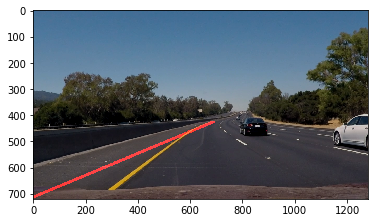

In [131]:
avg_pos_slope = 0
avg_neg_slope = 0
nFrames = 0
challenge_output = 'test_videos/modified_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))